# Setting an environment for analysis

## import packages

In [2]:
from os import path
from os.path import abspath, join
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

In [3]:
from scipy import stats
from matplotlib_venn import venn2
from matplotlib_venn import venn3, venn3_circles

In [4]:
import plotly.graph_objects as go
import plotly.express as px
from scipy.stats import pearsonr

In [5]:
from pymodulon.core import IcaData
from pymodulon.plotting import *
from pymodulon.compare import *
from pymodulon.io import *
from pymodulon.util import _parse_sample

In [6]:
plt.rcParams['svg.fonttype'] = 'none'

## Define functions

### gene2id

In [7]:
def gene2id(gene):
       return ica_data_1k36.gene_table[ica_data_1k36.gene_table.gene_name==gene].index[0]

### _plot_activities2

In [8]:
def _plot_activities2 (ica_data, iM1, iM2, highlights):
    plt.rcParams["figure.figsize"] = (6,6)
    x = ica_data.A.loc[iM1]
    y = ica_data.A.loc[iM2]

    fig = plt.subplot()
    ax = plt.scatter(x.drop(group_dict.index), y.drop(group_dict.index), color='#DCDCDC',
                    marker='.',
                    s=40)
    ax = plt.scatter(x[group_dict[group_dict.med=='G'].index], 
                     y[group_dict[group_dict.med=='G'].index], marker='o', s =200,
                    c = group_dict[group_dict.med=='S'].color_num, cmap ='Reds',
                     edgecolors='black', linewidth=.5,
                     label="Glucose"
                    )

    ax = plt.scatter(x[group_dict[group_dict.med=='N'].index], 
                     y[group_dict[group_dict.med=='N'].index], marker='v', s =200,
                    c = group_dict[group_dict.med=='S'].color_num, cmap ='Greens',
                       edgecolors='black', linewidth=.5,
                     label="Nitrogen"
                    )

    ax = plt.scatter(x[group_dict[group_dict.med=='S'].index], 
                     y[group_dict[group_dict.med=='S'].index], marker='s', s =200,
                    c = group_dict[group_dict.med=='S'].color_num, cmap ='Blues',
                       edgecolors='black', linewidth=.5,
                     label="Sulfur"
                    )
    
    ax = plt.scatter(x[highlights], 
                 y[highlights], marker='D', s =80,
                 c ='Yellow',
                   edgecolors='black', linewidth=.5,
                 label="highlights"
                )
    

    corr, rvalue = pearsonr(x, y)
    print("entire sample: ", round(corr, 2), rvalue)


    #iM only
    #regression
    m, b = np.polyfit(x, y, 1 )
    
    ax = plt.plot(x, m*x+b,
                 c = 'black')
    
    corr, rvalue = pearsonr( x.loc[group_dict.index],  y.loc[group_dict.index])
    print(round(corr, 2), rvalue)
    
    plt.axvline(x = 0, color = 'grey', ls=':', lw=1)
    plt.axhline(y = 0, color = 'grey', ls=':', lw=1)
    
    plt.xlabel(iM1+" activity", size=20)
    plt.ylabel(iM2+" activity", size=20)


    #fig..set_xlabel("ppGpp iM activity")

   # plt.legend()
    
    return fig

### _plot_activities_R2

In [9]:
def _plot_activities_R2 (ica_data, iM1, iM2, highlights):
    plt.rcParams["figure.figsize"] = (6,6)
    x = ica_data.A.loc[iM1]
    y = ica_data.A.loc[iM2]

    fig = plt.subplot()
    ax = plt.scatter(x.drop(group_dict.index), y.drop(group_dict.index), color='#DCDCDC',
                    marker='.',
                    s=40)
    ax = plt.scatter(x[group_dict[group_dict.med=='G'].index], 
                     y[group_dict[group_dict.med=='G'].index], marker='o', s =120,
                    c = group_dict[group_dict.med=='S'].color_num, cmap ='Reds',
                     edgecolors='black', linewidth=.5,
                     label="Glucose"
                    )

    ax = plt.scatter(x[group_dict[group_dict.med=='N'].index], 
                     y[group_dict[group_dict.med=='N'].index], marker='v', s =120,
                    c = group_dict[group_dict.med=='S'].color_num, cmap ='Greens',
                       edgecolors='black', linewidth=.5,
                     label="Nitrogen"
                    )

    ax = plt.scatter(x[group_dict[group_dict.med=='S'].index], 
                     y[group_dict[group_dict.med=='S'].index], marker='s', s =120,
                    c = group_dict[group_dict.med=='S'].color_num, cmap ='Blues',
                       edgecolors='black', linewidth=.5,
                     label="Sulfur"
                    )
    
    ax = plt.scatter(x[highlights], 
                 y[highlights], marker='D', s =80,
                 c ='Yellow',
                   edgecolors='black', linewidth=.5,
                 label="highlights"
                )
    

    corr, rvalue = pearsonr(x, y)
    print("entire sample: ", round(corr, 2), rvalue)


    #iM only
    #regression
    m, b = np.polyfit(x, y, 1 )
    
    ax = plt.plot(x.sort_values(), 
                  m*x.sort_values()+b, ls='--',
                 c = 'grey')
    
    m2, b2 = np.polyfit(x.loc[group_dict.index], y.loc[group_dict.index], 1 )
    
    ax = plt.plot(x, m2*x+b2,
                 c = 'black')    
    
    corr, rvalue = pearsonr( x.loc[group_dict.index],  y.loc[group_dict.index])
    print(round(corr, 2), rvalue)
    
    plt.axvline(x = 0, color = 'grey', ls=':', lw=1)
    plt.axhline(y = 0, color = 'grey', ls=':', lw=1)
    
    plt.xlabel(iM1+" activity", size=20)
    plt.ylabel(iM2+" activity", size=20)


    #fig..set_xlabel("ppGpp iM activity")

   # plt.legend()
    
    return fig

### _plot_time_activities

In [10]:
def _plot_time_activities(ica_data, iM_name, group_dict):
    df_temp = group_dict.copy()
    iM_activity = pd.DataFrame(index = group_dict.time.unique(),
                              columns = ['G_abs','G_err','N_abs','N_err','S_abs','S_err'])
    
    df_temp['iM'] = ica_data.A.loc[iM_name]
    
    ref_activity = (df_temp.loc['p1k_01056','iM']+df_temp.loc['p1k_01057','iM'])/2
    
    df_temp['iM'] = df_temp['iM'] - ref_activity
    
    
    for cond in df_temp.med.unique():
        for time in df_temp[df_temp.med ==cond].time.unique():
            temp = df_temp[(df_temp.med ==cond) & (df_temp.time ==time)].iM
            iM_activity.at[time,cond+'_abs'] = temp.mean()
            iM_activity.at[time,cond+'_err'] = abs(temp[0]-temp.mean())
            del temp
    
    fig= plt.subplots(figsize=(5, 5))
    plt.errorbar(iM_activity.index, iM_activity['G_abs'], yerr=iM_activity['G_err'],
                 marker='s', capsize=3, color='Brown', label='Glucose'
                )
    plt.errorbar(iM_activity.index, iM_activity['N_abs'], yerr=iM_activity['N_err'],
                 marker='s', capsize=3, color='Green'
                )
    plt.errorbar(iM_activity.index, iM_activity['S_abs'], yerr=iM_activity['S_err'],
                 marker='s', capsize=3, color='Blue'
                )
    plt.axhline(0, color='grey', linewidth=1)
    
    plt.xlabel("Time")
    plt.ylabel("iM activity")
    plt.title(str(iM_name)+" iM activity")
    plt.legend(['',"Glucose", "N", "S"])
    plt.xticks([0,3,4,6,8,12,24])
    plt.xlim(0, 24)

    return fig

In [11]:
def find_im(ica_data, gene):
    
    if gene[0]!='b':
        gene = ica_data.gene_table[ica_data.gene_table.gene_name==gene].index[0]
        
    checker=0
    for iM in ica_data.imodulon_table.index:
        if gene in ica_data.view_imodulon(iM).index:
            print(iM)
            checker =1
    if checker ==0:
        print("No iM found")

## compare_activities_plotly

In [12]:
def compare_activities_plotly(A1, A2):
    plotly_temp_df = pd.DataFrame()
    plotly_temp_df[A1] = ica_data_1k36.A.loc[A1]
    plotly_temp_df[A2] = ica_data_1k36.A.loc[A2]
    plotly_temp_df['info'] = ica_data_1k36.sample_table.index+ '_' + ica_data_1k36.sample_table.sample_id
    plotly_temp_df = plotly_temp_df.set_index('info')
    fig = px.scatter(x=plotly_temp_df[A1], y=plotly_temp_df[A2], hover_name=plotly_temp_df.index)
    return fig

## load jsons

In [13]:
ica_data_1k36=load_json_model('../../modulome_jsons/precise1k36_hgl.json')
ica_data_1k36_stationary=load_json_model('../../modulome_jsons/precise1k36_stationary_hgl.json')
precise1k=load_json_model('../../modulome_jsons/precise1k_Nov30_2022_exp.json')

## sample grouping

In [14]:
# Labeling dictionary

group_dict = pd.DataFrame(ica_data_1k36_stationary.sample_table[['condition','rep_id']])
for i in group_dict.index:
    condition= group_dict.loc[i,'condition']
    group_dict.loc[i,'time'] = condition.split('_')[2].replace("h","")
    
    if condition.split('_')[0]=='GlcM9':
        group_dict.loc[i,'med'] = "G"
        group_dict.loc[i,'med_time'] = "G_"+ group_dict.loc[i,'time']
    else:
        group_dict.loc[i,'med'] = condition.split('-')[0]
        group_dict.loc[i,'med_time'] = condition.split('-')[0]+"_"+ group_dict.loc[i,'time']
group_dict['rep_id'] = group_dict['rep_id'].astype("int32")
group_dict['time'] = group_dict['time'].astype("int32")

color_dict = {
    3:'black',
    4:'green',
    6:'yello',
    8:'blue',
    12:'red',
    24:'orange',
}

color_scale_dict = {
    3:1,
    4:2,
    6:3,
    8:4,
    12:5,
    24:6,
}

for i in group_dict.index:
    group_dict.loc[i, 'color'] = color_dict.get( group_dict.loc[i, 'time'] )
    group_dict.loc[i, 'color_num'] = color_scale_dict.get(group_dict.loc[i, 'time'] )
group_dict.color_num = group_dict.color_num.astype("int32")

In [15]:
group_dict.head()

condition  rep_id  time med med_time  color  color_num
p1k_01056  GlcM9_1_3h       1     3   G      G_3  black          1
p1k_01057  GlcM9_1_3h       2     3   G      G_3  black          1
p1k_01058  GlcM9_2_4h       1     4   G      G_4  green          2
p1k_01059  GlcM9_2_4h       2     4   G      G_4  green          2
p1k_01060  GlcM9_3_6h       1     6   G      G_6  yello          3

# PCA analysis

In [ ]:
pca = PCA(n_components=3)
pca.fit(ica_data_1k36_stationary.X.T)
X_pca = pca.transform(ica_data_1k36_stationary.X.T) 
Xax = X_pca[:,0]
Yax = X_pca[:,1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(Xax, Yax)

# Compare the new iM structure with PRECISE1K

In [38]:
dots,links = compare_ica(ica_data_1k36.M, precise1k.M, cutoff=0.1,
                         #ortho_file = '../example_data/eColi_full_protein_vs_pPutida_full_protein_parsed.csv'
                        )
dots

[('Resistance', 'Resistance', 0.9202633835705116),
 ('SSW SNPs', 'SSW SNPs', 0.9584676459748886),
 ('cspH', 'yqhI', 0.10708591529031417),
 ('cspH', 'Cold Shock', 0.12908068618195978),
 ('Galactose', 'Galactose', 0.7708140851432772),
 ('Galactose', 'PAL Amp', 0.13407979178963028),
 ('Galactose', 'pts KO', 0.2489925214148293),
 ('NtrC-1', 'NtrC-1', 0.9149496292685214),
 ('ROS TALE Amp', 'ROS TALE Amp', 0.9411701854028997),
 ('crp KO-1', 'crp KO-1', 0.9463816522820315),
 ('cyoB/kdpE/qseB KO', 'cyoB/kdpE/qseB KO', 0.9555039789853327),
 ('Rhamnose', 'Rhamnose', 0.9783202999879778),
 ('IS1', 'IS1', 0.8908794751956951),
 ('FlhDC-1', 'FlhDC-2', 0.10560162903161348),
 ('FlhDC-1', 'FlhDC-1', 0.9348634893116343),
 ('Nucleoside', 'Nucleoside', 0.9161404548359725),
 (12, 'IS Elements-2', 0.36378469070299063),
 (12, 'IS Elements-1', 0.41616118588335366),
 ('Molybdenum', 'Molybdenum', 0.8603216238111331),
 ('ykgR', 'ykgR', 0.9000481936040832),
 ('ykgR', 'LPS', 0.11228191665405109),
 ('Lysine/T2SS', '

In [39]:
links.format ='svg'
connectivity=pd.DataFrame(dots, columns=['precise1k36','precise1k','R'])
connectivity.to_csv("../temp_data/precise1k_1k36_comparison.csv")

In [40]:
connectivity

precise1k36   precise1k         R
0    Resistance  Resistance  0.920263
1      SSW SNPs    SSW SNPs  0.958468
2          cspH        yqhI  0.107086
3          cspH  Cold Shock  0.129081
4     Galactose   Galactose  0.770814
..          ...         ...       ...
358        TreR         IS5  0.336539
359        TreR     Acetate  0.122665
360     pts ALE        UC-4  0.114940
361     pts ALE     pts ALE  0.910018
362     pts ALE      pts KO  0.364486

[363 rows x 3 columns]

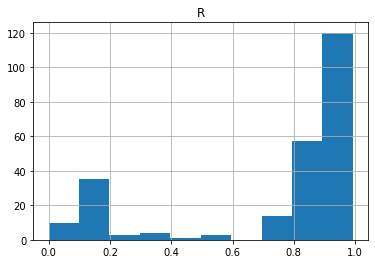

In [41]:
connectivity_df = pd.DataFrame(index=ica_data_1k36.imodulon_table.index)
connectivity_df['R'] =0

for i in connectivity_df.index:
    if i in connectivity['precise1k36'].values:
        connectivity_df.loc[i,'R'] = connectivity[connectivity.precise1k36==i].sort_values(by='R',ascending=False).iloc[0]['R']
        
connectivity_df.hist()
plt.savefig("../images/at.svg")

In [46]:
connectivity[connectivity.precise1k36=='RelB']

precise1k36 precise1k         R
25        RelB     Crp-1  0.176697
26        RelB      UC-7  0.391481
27        RelB      UC-8  0.269003

In [52]:
groupA = precise1k.view_imodulon("UC-7").index.to_list()

In [55]:
groupB = precise1k.view_imodulon("UC-8").index.to_list()

In [56]:
groupC = ica_data_1k36.view_imodulon("RelB").index.to_list()

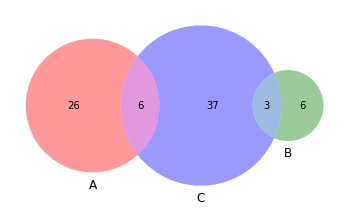

In [59]:
venn3([set(groupA), set(groupB), set(groupC)])

In [60]:
set(groupA) & set(groupC)

{'b0607', 'b0643', 'b0836', 'b1953', 'b2135', 'b4188'}

In [51]:
precise1k.view_imodulon("UC-8").index

Index(['b0146', 'b0389', 'b0435', 'b0674', 'b1512', 'b1838', 'b2344', 'b3494',
       'b4227'],
      dtype='object')

In [63]:
ica_data_1k36.view_imodulon("RelB").sort_values(by='gene_weight', ascending=False)

gene_weight gene_name        synonyms  \
b1205     0.135584      ychH            ychH   
b3494     0.130608      uspB       uspB;yhiO   
b2135     0.124316      yohC            yohC   
b4188     0.115347      yjfN            yjfN   
b3022     0.100695      mqsR       mqsR;ygiU   
b0836     0.100448      bssR       bssR;yliH   
b0699     0.098049      ybfA            ybfA   
b4199     0.097120      yjfY            yjfY   
b0435     0.096110      bolA            bolA   
b3021     0.092732      mqsA       mqsA;ygiT   
b4189     0.088155      bsmA       bsmA;yjfO   
b1188     0.087307      ycgB            ycgB   
b2597     0.079923      raiA       raiA;yfiA   
b1195     0.079613      ymgE        ymgE;tag   
b1953     0.077819      yodD            yodD   
b1020     0.076252      phoH       phoH;psiH   
b4496     0.074967      yedS            yedS   
b1747     0.074699      astA       astA;ydjV   
b0607     0.073115      uspG  uspG;ybdQ;yzzU   
b3687     0.073056      ibpA  ibpA;hslT;htpN   
b1060     0.072267      bssS       bssS;yceP   
b1746     0.072165      astD       astD;ydjU   
b0643     0.071545      ybeL            ybeL   
b4045     0.071391      yjbJ            yjbJ   
b1564     0.069092      relB            relB   
b3686     0.068770      ibpB  ibpB;hslS;htpE   
b1563     0.067192      relE            relE   
b3049     0.064241      glgS       glgS;scoR   
b1598     0.063367      ydgD            ydgD   
b1562     0.061762      hokD       hokD;relF   
b0018     0.061320      mokC       mokC;gefL   
b3448     0.060818      yhhA            yhhA   
b2377     0.060356      yfdY            yfdY   
b0786     0.059528      ybhL            ybhL   
b0966     0.057432      hspQ       hspQ;yccV   
b0119     0.056928      yacL            yacL   
b1783     0.056907      yeaG            yeaG   
b1376     0.056715      uspF  uspF;ynaF;yzzL   
b1784     0.056512      yeaH            yeaH   
b1223     0.055160      narK            narK   
b4554     0.054236      yibT            yibT   
b4118     0.054222      melR            melR   
b4227     0.053925      ytfQ            ytfQ   
b2015     0.053562      yeeY            yeeY   
b3263    -0.055155      yhdU            yhdU   
b1488    -0.062012      ddpX  ddpX;vanX;yddT   

                                            gene_product  \
b1205                             stress-induced protein   
b3494  putative universal stress (ethanol tolerance) ...   
b2135                    putative inner membrane protein   
b4188                                 protease activator   
b3022  mRNA interferase/toxin of the MqsR-MqsA toxin-...   
b0836                     regulator of biofilm formation   
b0699             DUF2517 domain-containing protein YbfA   
b4199             DUF1471 domain-containing protein YjfY   
b0435    DNA-binding transcriptional dual regulator BolA   
b3021  antitoxin of the MqsRA toxin-antitoxin system/...   
b4189  DUF1471 domain-containing putative lipoprotein...   
b1188                        PF04293 family protein YcgB   
b2597  stationary phase translation inhibitor and rib...   
b1195                        PF04226 family protein YmgE   
b1953                             stress-induced protein   
b1020                           ATP-binding protein PhoH   
b4496  putative outer membrane protein YedS%2C N-term...   
b1747                     arginine N-succinyltransferase   
b0607                         universal stress protein G   
b3687                      small heat shock protein IbpA   
b1060                     regulator of biofilm formation   
b1746                             aldehyde dehydrogenase   
b0643             DUF1451 domain-containing protein YbeL   
b4045                   putative stress response protein   
b1564  Qin prophage%3B antitoxin/DNA-binding transcri...   
b3686                      small heat shock protein IbpB   
b1563        Qin prophage%3B mRNA interferase toxin RelE   
b3049                      surface composition regulator   
b1598     

In [44]:
connectivity_df[connectivity_df.R<0.6].sort_values(by='R')

R
hokA           0.000000
ytiD           0.000000
yojO           0.000000
ymcE           0.000000
yjiS           0.000000
ydaF           0.000000
BtsR           0.000000
dicC           0.000000
SlyA           0.000000
CreB           0.000000
rcbA           0.102722
yzfA           0.103705
essQ           0.109509
yqgD           0.110287
Molybdopterin  0.115599
CueR           0.117467
ydfA           0.118445
198            0.118662
exoD           0.121495
yniD           0.125829
yfaH           0.125917
cspH           0.129081
yneL           0.129914
ynfT           0.130799
pyrL           0.131839
ymfR           0.137094
ymgJ           0.137494
yqgC           0.140378
LldR           0.142729
ryhB           0.143320
yedX           0.146572
dicB           0.146714
ghoT           0.148534
ralR           0.148897
yrhD           0.152876
NsrR           0.158023
233            0.159725
222            0.160683
yoaG           0.162384
pdhR           0.168829
gnd            0.171280
234            0.181370
LrhA           0.186083
ymjB           0.191353
CpxR-1         0.197726
icdC           0.205297
ynfN           0.226613
NadR           0.282497
127            0.304392
alaE           0.313002
TreR           0.336539
RelB           0.391481
12             0.416161
DcuR           0.507276
23             0.570372
ubiC           0.575536

# Basic information

In [15]:
print(ica_data_1k36.imodulon_table.index.size)

247


In [16]:
explained_variance(precise1k)

0.8179626432871699

In [17]:
explained_variance(ica_data_1k36)

0.8254169533354075

In [18]:
explained_variance(ica_data_1k36_stationary)

0.7821086849733425

In [19]:
rec_var = {}
for k in ica_data_1k36_stationary.imodulon_names:
    rec_var[k] = explained_variance(ica_data_1k36_stationary,imodulons=k)
df_rec_var = pd.Series(rec_var)
df_rec_var = df_rec_var.sort_values(ascending=False)

In [20]:
df_rec_var

RelB              0.066360
ppGpp             0.044796
Translation       0.032010
NsrR              0.030448
Pyrimidine        0.024009
                    ...   
yceO              0.000118
yzfA              0.000116
lsrB KO           0.000076
Thr/Ser-1         0.000075
ROS TALE Del-1    0.000072
Length: 247, dtype: float64

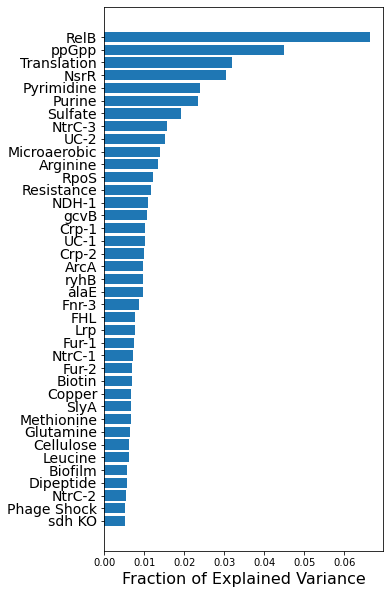

In [21]:
num2show = df_rec_var[df_rec_var > 0.005].size
plt.rcParams["figure.figsize"] = (5,10)

plt.barh(range(num2show,0,-1),df_rec_var.head(num2show),tick_label = df_rec_var.head(num2show).index)
plt.xlabel('Fraction of Explained Variance',fontsize=16)
# Rename uncharacterized-5 to ppGpp
new_labels = [x if x != 'uncharacterized-5' else 'ppGpp' for x in df_rec_var.head(num2show).index]
plt.yticks(range(num2show,0,-1),labels=new_labels,fontsize=14);
plt.savefig("../iM_1k36/explained_variance_36only_exp0_5percent.svg")

In [29]:
import pylab
from collections import Counter

/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_33000/1832363940.py:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')


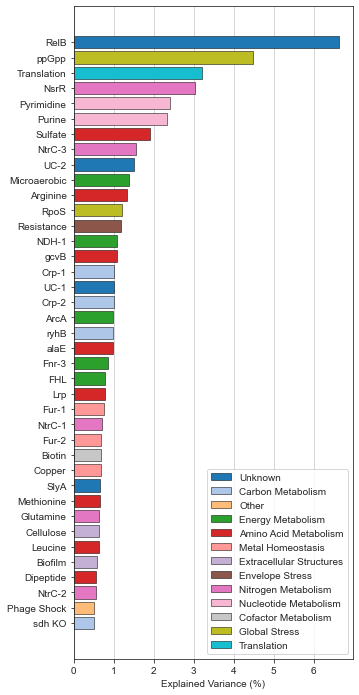

In [72]:
# combine some low-exp-var categories so there aren't too many colors in this plot

imod_table = pd.read_csv("../iM_1k36/iModulon_table_manual.csv", index_col=1)

for i in imod_table.index:
    imod_table.loc[i,'exp_var'] = rec_var.get(i)

func_cat_to_var = {}

for func_cat, func_cat_df in imod_table.groupby('functional_category'):
    func_cat_to_var[func_cat] = func_cat_df['exp_var'].sum()
sorted_cat_to_var = sorted(list(func_cat_to_var.items()), key=lambda tup: tup[1], reverse=True)

n_max = 12
other_cats = [tup[0] for tup in sorted_cat_to_var[n_max:]]
func_im_table = imod_table.copy()
func_im_table = func_im_table.assign(functional_category=func_im_table['functional_category'].apply(lambda cat: 'Other' if cat in other_cats else cat))

sorted_imod_table = func_im_table.sort_values(by='exp_var', ascending=False)

imod_cat_counts = Counter(func_im_table['functional_category'])
sorted_cats, sorted_counts = zip(*sorted(list(imod_cat_counts.items()), key=lambda tup: tup[1], reverse=True))
color_dict = dict(zip(sorted_cats, [pylab.get_cmap('tab20')(i/(len(sorted_cats))) for i in range(0,len(sorted_cats))]))


# Making color dictionary

color_dict_df = pd.DataFrame(index=sorted_cats, columns={'color'})
color_dict_df.color= color_dict_df.color.astype("object")

cnt = 0
for i in color_dict_df.index:
    color_dict_df.at[i, 'color'] = (pylab.get_cmap('tab20')(cnt*1/(len(sorted_cats))))
    cnt = cnt+1
    
# Making legend patches
import matplotlib.patches as mpatches
patches=[]
for i in range(color_dict_df.index.size):
    patches.append(mpatches.Patch(facecolor=color_dict_df.iloc[i].color, 
                                  label=color_dict_df.index[i],
                                 edgecolor = 'black',
                                    linewidth=0.5))
    

sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(5, 12))
n_top = df_rec_var[df_rec_var > 0.005].size
for i, im_row in enumerate(sorted_imod_table.itertuples()):

    if i < n_top:
        ax.barh(0-i, im_row.exp_var*100, 
                color=color_dict_df.loc[im_row.functional_category, 'color'],
                edgecolor = 'black',
                linewidth=0.5
               )
        
ax.set_xlabel('Explained Variance (%)')
ax.set_yticklabels(list(reversed(list(sorted_imod_table.index)[:n_top])), rotation=0, fontsize=10, ha='right')
ax.set_yticks(range(-n_top+1, 1))
ax.set_xticks(range(7))
ax.xaxis.grid(True)
for i in ax.spines.values():
    i.set_linewidth(0.8)
    
plt.legend(handles=patches, loc='best')    
plt.show()

fig.figure.savefig("../iM_1k36/EV_36sample_exp0_5_39iMs.svg")

In [39]:
#iM_structure of precise1k

G_iM_only = load_json_model("../jsons/precise1k36/G_iM_only.json")
N_iM_only = load_json_model("../jsons/precise1k36/N_iM_only.json")
S_iM_only = load_json_model("../jsons/precise1k36/S_iM_only.json")

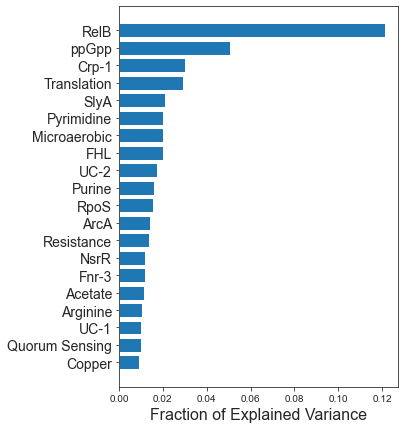

In [56]:
num2show = 20
plt.rcParams["figure.figsize"] = (5,7)
rec_var = {}
for k in G_iM_only.imodulon_names:
    rec_var[k] = explained_variance(G_iM_only,imodulons=k)
df_rec_var = pd.Series(rec_var)
df_rec_var = df_rec_var.sort_values(ascending=False)
df_rec_var.head(num2show)

plt.barh(range(num2show,0,-1),df_rec_var.head(num2show),tick_label = df_rec_var.head(num2show).index)
plt.xlabel('Fraction of Explained Variance',fontsize=16)
plt.yticks(range(num2show,0,-1),
           fontsize=14);
plt.savefig("../iM_1k36/EV_G_only_top20.svg")
G_iM_only_30_genes = df_rec_var.head(num2show).index

/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_33000/517927280.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(list(sorted_imod_table_G.index)[:num2show])), rotation=0, fontsize=10, ha='right')


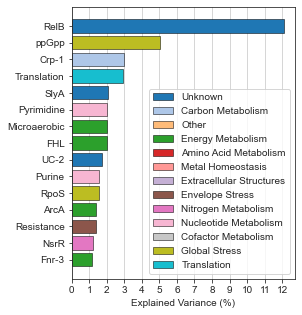

In [110]:
num2show = 15
rec_var = {}
for k in G_iM_only.imodulon_names:
    rec_var[k] = explained_variance(G_iM_only,imodulons=k)
df_rec_var = pd.Series(rec_var)
df_rec_var = df_rec_var.sort_values(ascending=False)
df_rec_var.head(num2show)

sorted_imod_table_G = sorted_imod_table.loc[df_rec_var.head(num2show).index]
for i in sorted_imod_table_G.index:
    sorted_imod_table_G.loc[i, 'exp_var'] = df_rec_var[i]

fig, ax = plt.subplots(figsize=(4, 5))
for i, im_row in enumerate(sorted_imod_table_G.itertuples()):

    if i < num2show:
        ax.barh(0-i, im_row.exp_var*100, 
                color=color_dict_df.loc[im_row.functional_category, 'color'],
                edgecolor = 'black',
                linewidth=0.5
               )
        
ax.set_xlabel('Explained Variance (%)')
ax.set_yticklabels(list(reversed(list(sorted_imod_table_G.index)[:num2show])), rotation=0, fontsize=10, ha='right')
ax.set_yticks(range(-num2show+1, 1))
ax.set_xticks(range(int(round(df_rec_var.iloc[0]*100,0))+1))
ax.xaxis.grid(True)
for i in ax.spines.values():
    i.set_linewidth(0.8)
    
plt.legend(handles=patches, loc='best')    
plt.savefig("../iM_1k36/EV_G_only_top20.svg")


/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_33000/1759106290.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(list(sorted_imod_table_N.index)[:num2show])), rotation=0, fontsize=10, ha='right')


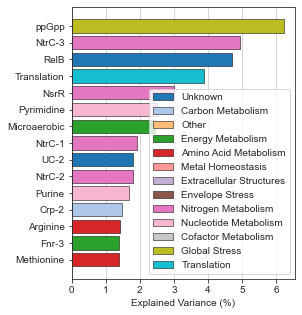

In [111]:
num2show = 15
rec_var = {}
for k in N_iM_only.imodulon_names:
    rec_var[k] = explained_variance(N_iM_only,imodulons=k)
df_rec_var = pd.Series(rec_var)
df_rec_var = df_rec_var.sort_values(ascending=False)
df_rec_var.head(num2show)

sorted_imod_table_N = sorted_imod_table.loc[df_rec_var.head(num2show).index]
for i in sorted_imod_table_N.index:
    sorted_imod_table_N.loc[i, 'exp_var'] = df_rec_var[i]

fig, ax = plt.subplots(figsize=(4, 5))
for i, im_row in enumerate(sorted_imod_table_N.itertuples()):

    if i < num2show:
        ax.barh(0-i, im_row.exp_var*100, 
                color=color_dict_df.loc[im_row.functional_category, 'color'],
                edgecolor = 'black',
                linewidth=0.5
               )
        
ax.set_xlabel('Explained Variance (%)')
ax.set_yticklabels(list(reversed(list(sorted_imod_table_N.index)[:num2show])), rotation=0, fontsize=10, ha='right')
ax.set_yticks(range(-num2show+1, 1))
ax.set_xticks(range(int(round(df_rec_var.iloc[0]*100,0))+1))
ax.xaxis.grid(True)
for i in ax.spines.values():
    i.set_linewidth(0.8)
    
plt.legend(handles=patches, loc='best')    
plt.savefig("../iM_1k36/EV_N_only_top20.svg")


/var/folders/lb/2grw3fwd7pbf9hc08c9r8t4h0000gn/T/ipykernel_33000/1129396901.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(list(reversed(list(sorted_imod_table_S.index)[:num2show])), rotation=0, fontsize=10, ha='right')


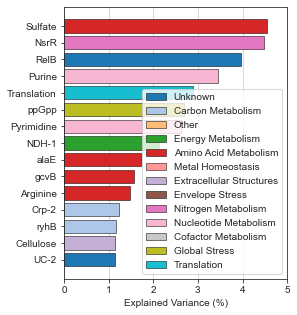

In [112]:
num2show = 15
rec_var = {}
for k in S_iM_only.imodulon_names:
    rec_var[k] = explained_variance(S_iM_only,imodulons=k)
df_rec_var = pd.Series(rec_var)
df_rec_var = df_rec_var.sort_values(ascending=False)
df_rec_var.head(num2show)

sorted_imod_table_S = sorted_imod_table.loc[df_rec_var.head(num2show).index]
for i in sorted_imod_table_S.index:
    sorted_imod_table_S.loc[i, 'exp_var'] = df_rec_var[i]

fig, ax = plt.subplots(figsize=(4, 5))
for i, im_row in enumerate(sorted_imod_table_S.itertuples()):

    if i < num2show:
        ax.barh(0-i, im_row.exp_var*100, 
                color=color_dict_df.loc[im_row.functional_category, 'color'],
                edgecolor = 'black',
                linewidth=0.5
               )
        
ax.set_xlabel('Explained Variance (%)')
ax.set_yticklabels(list(reversed(list(sorted_imod_table_S.index)[:num2show])), rotation=0, fontsize=10, ha='right')
ax.set_yticks(range(-num2show+1, 1))
ax.set_xticks(range(int(round(df_rec_var.iloc[0]*100,0))+1))
ax.xaxis.grid(True)
for i in ax.spines.values():
    i.set_linewidth(0.8)
    
plt.legend(handles=patches, loc='best')    
plt.savefig("../iM_1k36/EV_S_only_top20.svg")

In [44]:
iM_union_genes = set(G_iM_only_30_genes) | set(N_iM_only_30_genes) | set(S_iM_only_30_genes)

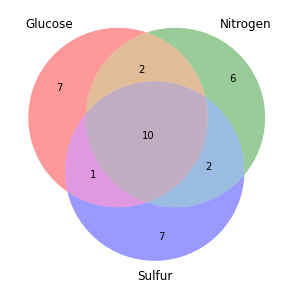

In [46]:
fig = venn3([set(G_iM_only_30_genes) , set(N_iM_only_30_genes), set(S_iM_only_30_genes)],
           ['Glucose','Nitrogen','Sulfur'])
plt.savefig("../iM_1k36//venn_30_each.svg")

# Heatmap

In [22]:
ref_samples = ['p1k_01056', 'p1k_01057']
ref_expr = ica_data_1k36_stationary.A[ref_samples].mean(axis = 1)
A_norm = ica_data_1k36_stationary.A.sub(ref_expr, axis = 0)

In [23]:
A_avg = pd.DataFrame(index=A_norm.index)
for i in ica_data_1k36_stationary.sample_table.full_name.unique():
    temp = pd.DataFrame(A_norm[ica_data_1k36_stationary.sample_table[ica_data_1k36_stationary.sample_table.full_name==i].index].mean(axis=1))
    temp=temp.rename(columns={0:i})
    if ((temp.columns[0] in A_avg.columns)==False):
        A_avg = pd.concat([A_avg, temp], axis=1)

In [25]:
stationary_cond = ica_data_1k36.sample_table[ica_data_1k36.sample_table.project=="stationary"].full_name.unique()
A_avg_stationary = A_avg[stationary_cond]
A_avg_stationary_sub=A_avg_stationary[A_avg_stationary.T[abs(A_avg_stationary.T)>15].any()]
abs(A_avg_stationary_sub).max(axis=1).sort_values(ascending=False).index

Index([          'RelB',           'ArcA',          'Crp-1',          'ppGpp',
              'Sulfate',         'NtrC-3',           'SlyA',    'Translation',
              'Acetate',         'NtrC-1',         'Purine',           'NsrR',
             'Glycerol',     'Fatty Acid',      'Glutamine',              127,
                 'RpoS',          'NDH-1',            'LPS',          'Crp-2',
       'nquinone ALE 3',          'GadXW',          'Fur-1',         'NtrC-2',
                  'FHL',      'NO Stress',        'Biofilm',          'Fnr-3',
       'Quorum Sensing'],
      dtype='object')

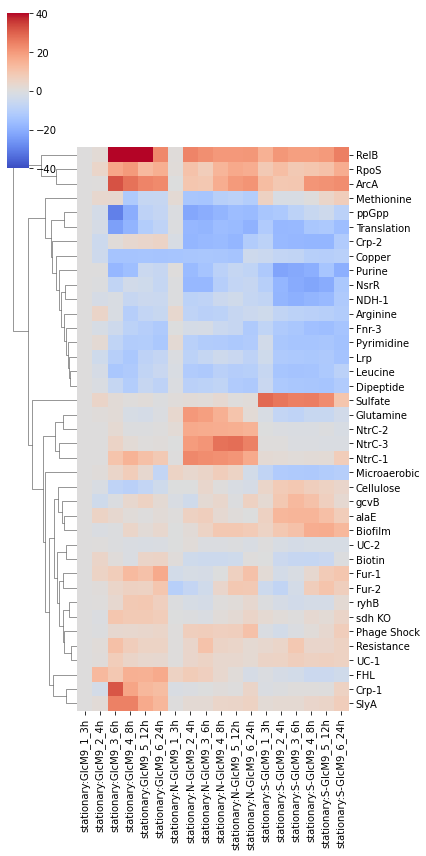

In [26]:
stationary_39_iMs = df_rec_var.head(39)
A_avg_stationary_39_df = A_avg_stationary.loc[stationary_39_iMs.index]
figure = sns.clustermap(A_avg_stationary_39_df, cmap='coolwarm',
                        figsize=(6,12),
                        vmin=-40,
                        vmax=40,
                        center=0,
              col_cluster=False)

In [31]:
len(ica_data_1k36.imodulon_table.loc[stationary_39_iMs.index].regulator.unique())

28

# iModulon characterization

## Fig 2B. RelB vs ppGpp

entire sample:  -0.75 2.1409356561650047e-191
-0.65 2.0316683057900426e-05


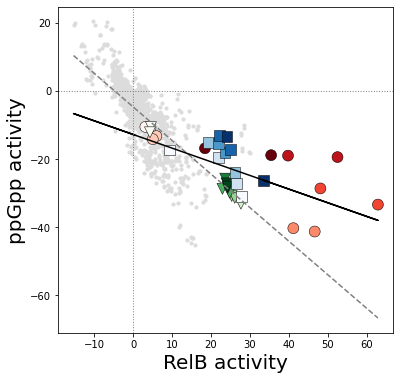

In [53]:
fig = _plot_activities_R2(ica_data_1k36,"RelB","ppGpp",[])
fig.get_figure().savefig("../images/1k36_ppGpp_RelB.svg")

In [34]:
find_im(precise1k,'yjfN')

CpxR
Crp-1
UC-7


In [31]:
find_im(precise1k,'b1205')

CpxR
Crp-1


In [66]:
ica_data_1k36.compute_regulon_enrichment("RelB", regulator='ppGpp')

pvalue             0.004181
precision          0.391304
recall             0.019912
f1score            0.037895
TP                18.000000
regulon_size     904.000000
imodulon_size     46.000000
n_regs             1.000000
Name: ppGpp, dtype: float64

In [68]:
ica_data_1k36.compute_regulon_enrichment("RelB", regulator='RelB')

pvalue            0.000001
precision         0.065217
recall            1.000000
f1score           0.122449
TP                3.000000
regulon_size      3.000000
imodulon_size    46.000000
n_regs            1.000000
Name: RelB, dtype: float64

In [30]:
ica_data_1k36.view_imodulon("RelB").sort_values(by='gene_weight', ascending=False)

gene_weight gene_name        synonyms  \
b1205     0.135584      ychH            ychH   
b3494     0.130608      uspB       uspB;yhiO   
b2135     0.124316      yohC            yohC   
b4188     0.115347      yjfN            yjfN   
b3022     0.100695      mqsR       mqsR;ygiU   
b0836     0.100448      bssR       bssR;yliH   
b0699     0.098049      ybfA            ybfA   
b4199     0.097120      yjfY            yjfY   
b0435     0.096110      bolA            bolA   
b3021     0.092732      mqsA       mqsA;ygiT   
b4189     0.088155      bsmA       bsmA;yjfO   
b1188     0.087307      ycgB            ycgB   
b2597     0.079923      raiA       raiA;yfiA   
b1195     0.079613      ymgE        ymgE;tag   
b1953     0.077819      yodD            yodD   
b1020     0.076252      phoH       phoH;psiH   
b4496     0.074967      yedS            yedS   
b1747     0.074699      astA       astA;ydjV   
b0607     0.073115      uspG  uspG;ybdQ;yzzU   
b3687     0.073056      ibpA  ibpA;hslT;htpN   
b1060     0.072267      bssS       bssS;yceP   
b1746     0.072165      astD       astD;ydjU   
b0643     0.071545      ybeL            ybeL   
b4045     0.071391      yjbJ            yjbJ   
b1564     0.069092      relB            relB   
b3686     0.068770      ibpB  ibpB;hslS;htpE   
b1563     0.067192      relE            relE   
b3049     0.064241      glgS       glgS;scoR   
b1598     0.063367      ydgD            ydgD   
b1562     0.061762      hokD       hokD;relF   
b0018     0.061320      mokC       mokC;gefL   
b3448     0.060818      yhhA            yhhA   
b2377     0.060356      yfdY            yfdY   
b0786     0.059528      ybhL            ybhL   
b0966     0.057432      hspQ       hspQ;yccV   
b0119     0.056928      yacL            yacL   
b1783     0.056907      yeaG            yeaG   
b1376     0.056715      uspF  uspF;ynaF;yzzL   
b1784     0.056512      yeaH            yeaH   
b1223     0.055160      narK            narK   
b4554     0.054236      yibT            yibT   
b4118     0.054222      melR            melR   
b4227     0.053925      ytfQ            ytfQ   
b2015     0.053562      yeeY            yeeY   
b3263    -0.055155      yhdU            yhdU   
b1488    -0.062012      ddpX  ddpX;vanX;yddT   

                                            gene_product  \
b1205                             stress-induced protein   
b3494  putative universal stress (ethanol tolerance) ...   
b2135                    putative inner membrane protein   
b4188                                 protease activator   
b3022  mRNA interferase/toxin of the MqsR-MqsA toxin-...   
b0836                     regulator of biofilm formation   
b0699             DUF2517 domain-containing protein YbfA   
b4199             DUF1471 domain-containing protein YjfY   
b0435    DNA-binding transcriptional dual regulator BolA   
b3021  antitoxin of the MqsRA toxin-antitoxin system/...   
b4189  DUF1471 domain-containing putative lipoprotein...   
b1188                        PF04293 family protein YcgB   
b2597  stationary phase translation inhibitor and rib...   
b1195                        PF04226 family protein YmgE   
b1953                             stress-induced protein   
b1020                           ATP-binding protein PhoH   
b4496  putative outer membrane protein YedS%2C N-term...   
b1747                     arginine N-succinyltransferase   
b0607                         universal stress protein G   
b3687                      small heat shock protein IbpA   
b1060                     regulator of biofilm formation   
b1746                             aldehyde dehydrogenase   
b0643             DUF1451 domain-containing protein YbeL   
b4045                   putative stress response protein   
b1564  Qin prophage%3B antitoxin/DNA-binding transcri...   
b3686                      small heat shock protein IbpB   
b1563        Qin prophage%3B mRNA interferase toxin RelE   
b3049                      surface composition regulator   
b1598     

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


<AxesSubplot:xlabel='Gene Start', ylabel='RelB Gene Weight'>

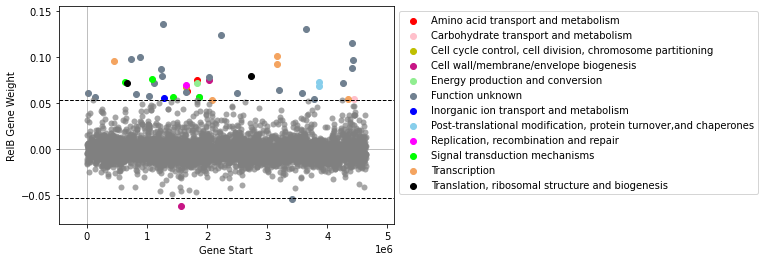

In [35]:
plot_gene_weights(ica_data_1k36,'RelB')

## Fig 2C. RpoS vs Translation

entire sample:  -0.59 4.238042907348007e-100
-0.77 4.01722360528018e-08


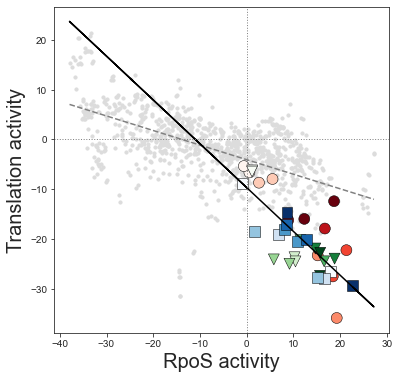

In [120]:
fig = _plot_activities_R2(ica_data_1k36,"RpoS","Translation",[])
fig.get_figure().savefig("../images/1k36_RpoS_Translation.svg")

## Fig 2D. Purine vs Pyrimidine

entire sample:  0.57 8.144995599377884e-95
0.71 1.365271029175012e-06


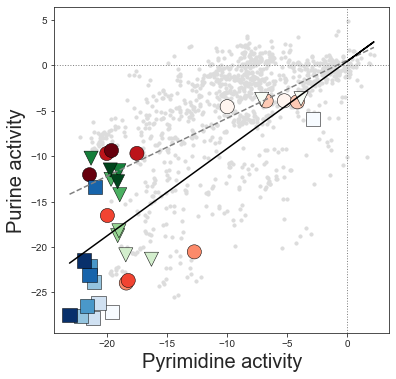

In [401]:
fig = _plot_activities_R2(ica_data_1k36,"Pyrimidine","Purine",[])
fig.get_figure().savefig("../images/1k36_Pyrimidine_Purine.svg")

## Fig 2E. Lrp vs Arginine

entire sample:  0.56 5.043533661452883e-89
0.64 2.184142731495686e-05


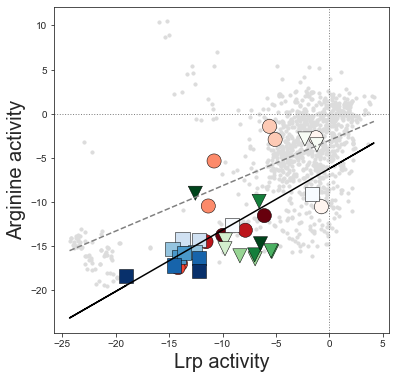

In [402]:
fig = _plot_activities_R2(ica_data_1k36,"Lrp","Arginine",[])
fig.get_figure().savefig("../images/1k36_Lrp_Arginine.svg")

## Fig 2F. ArcA vs Fnr-1

entire sample:  -0.62 5.054645722925515e-117
-0.55 0.0005130685478259684


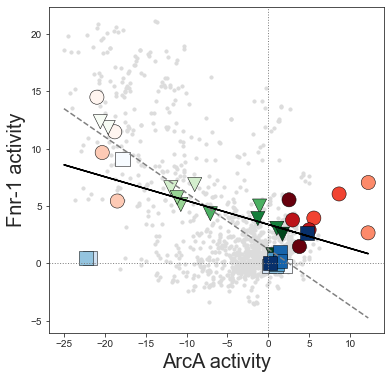

In [403]:
fig = _plot_activities_R2(ica_data_1k36,"ArcA","Fnr-1",[])
fig.get_figure().savefig("../images/1k36_ArcA_Fnr-1.svg")

## Fig 2G. Fur-1 vs Fur-2

entire sample:  0.79 1.7226105300207793e-227
0.83 4.737770982986123e-10


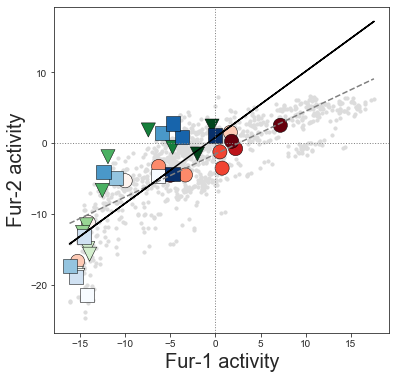

In [404]:
fig = _plot_activities_R2(ica_data_1k36,"Fur-1","Fur-2",[])
fig.get_figure().savefig("../images/1k36_Fur-1_Fur-2.svg")

## Fig 2H. NDH-1 vs NsrR

entire sample:  0.52 2.5983694844073086e-75
0.86 1.1238503210715679e-11


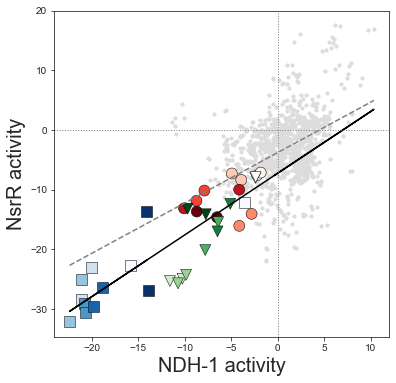

In [121]:
fig = _plot_activities_R2(ica_data_1k36,"NDH-1","NsrR",[])
fig.get_figure().savefig("../images/1k36_NDH_NsrR.svg")

# Fig 3. Global regulators

## Crp

entire sample:  0.67 6.037508126022841e-138
0.62 6.073068053194867e-05


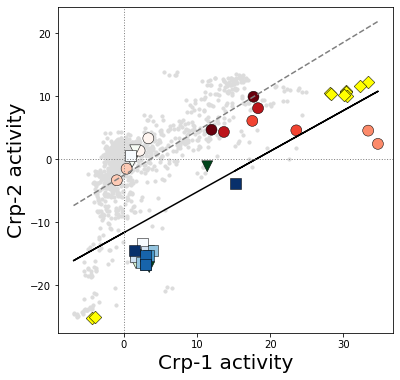

In [120]:
fig = _plot_activities_R2(ica_data_1k36,"Crp-1","Crp-2",
                         # ['p1k_00838','p1k_00839','p1k_00455','p1k_00456']
                          ['p1k_00838','p1k_00839']+
                          ica_data_1k36.sample_table[ica_data_1k36.sample_table.Supplement=='Ethanol(5%w/v)'].index.to_list()
                         )
fig.get_figure().savefig("../images/1k36_Crp1_Crp2.svg")

In [138]:
compare_activities_plotly('Crp-1','Crp-2')

## NtrC

entire sample:  0.45 7.250891220640285e-55
0.85 6.837326050278382e-11


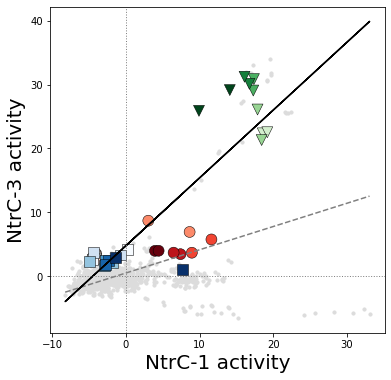

In [55]:
fig = _plot_activities_R2(ica_data_1k36,"NtrC-1","NtrC-3",[])
fig.get_figure().savefig("../images/1k36_NtrC1_NtrC3.svg")

<AxesSubplot:xlabel='NtrC-3 Gene Weight', ylabel='NtrC-2 Gene Weight'>

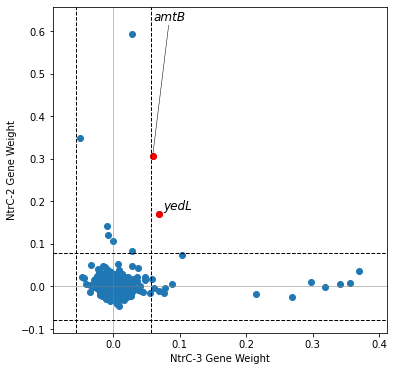

In [153]:
compare_gene_weights(ica_data_1k36, "NtrC-3", "NtrC-2")

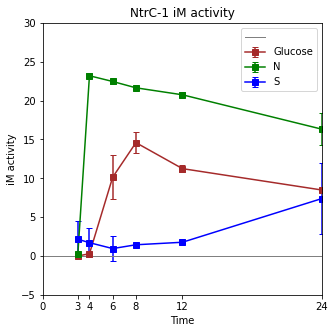

In [185]:
fig, ax = _plot_time_activities(ica_data_1k36, "NtrC-1", group_dict)
ax.set_ylim(bottom = -5, top=30)
fig.savefig("../images/ntrC1_time.svg")

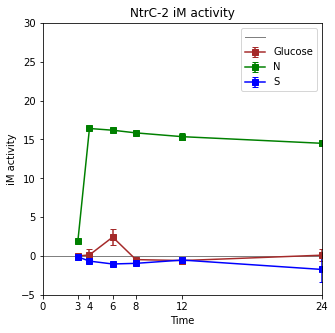

In [184]:
fig, ax = _plot_time_activities(ica_data_1k36, "NtrC-2", group_dict)
ax.set_ylim(bottom = -5, top=30)
fig.savefig("../images/ntrC2_time.svg")

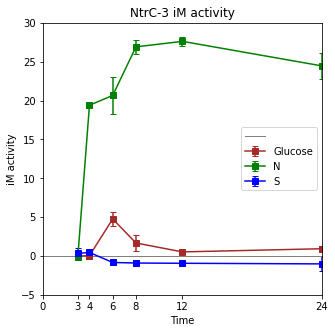

In [186]:
fig, ax = _plot_time_activities(ica_data_1k36, "NtrC-3", group_dict)
ax.set_ylim(bottom = -5, top=30)
fig.savefig("../images/ntrC3_time.svg")

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'NtrC-2 iM activity'}, xlabel='Time', ylabel='iM activity'>)

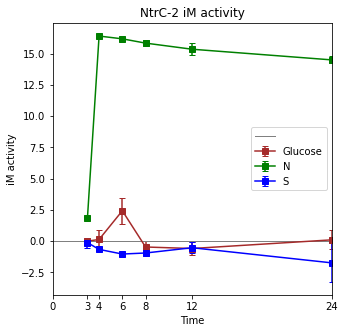

In [178]:
_plot_time_activities(ica_data_1k36, "NtrC-2", group_dict)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'NtrC-3 iM activity'}, xlabel='Time', ylabel='iM activity'>)

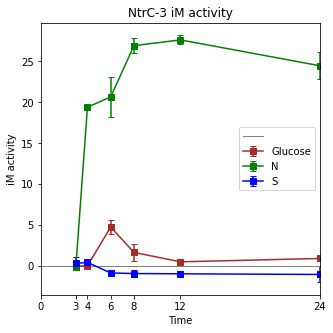

In [179]:
_plot_time_activities(ica_data_1k36, "NtrC-3", group_dict)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Nitrogen iM activity'}, xlabel='Time', ylabel='iM activity'>)

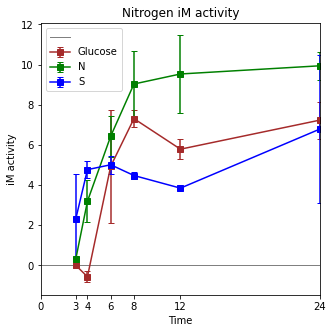

In [193]:
_plot_time_activities(ica_data_1k36, "Nitrogen", group_dict)

entire sample:  0.56 2.6084903601387053e-91
0.97 1.175162328127795e-22


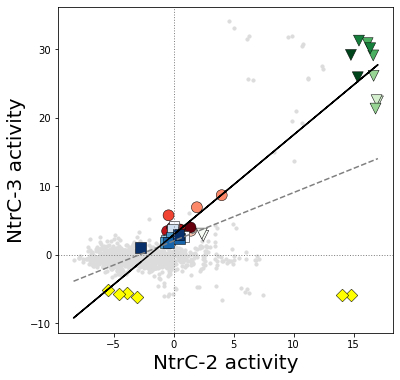

In [162]:
fig = _plot_activities_R2(ica_data_1k36,"NtrC-2","NtrC-3",
                          ['p1k_00836','p1k_00837',
                           'p1k_00842','p1k_00843',
                           'p1k_00848','p1k_00849',                          
                          ]
                         )
#fig.get_figure().savefig("../images/1k36_NtrC1_NtrC3.svg")

entire sample:  0.56 2.6084903601387053e-91
0.97 1.175162328127795e-22


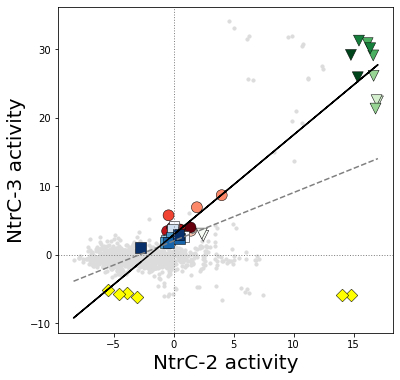

In [168]:
fig = _plot_activities_R2(ica_data_1k36,"NtrC-2","NtrC-3",
                          ['p1k_00836','p1k_00837',
                           'p1k_00842','p1k_00843',
                           'p1k_00848','p1k_00849',                          
                          ]
                         )
fig.get_figure().savefig("../images/1k36_NtrC2_NtrC3.svg")

entire sample:  0.25 3.496384013251582e-17
0.83 2.9499521213854744e-10


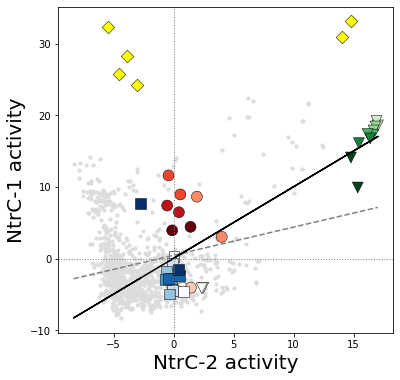

In [169]:
fig = _plot_activities_R2(ica_data_1k36,"NtrC-2","NtrC-1",
                          ['p1k_00836','p1k_00837',
                           'p1k_00842','p1k_00843',
                           'p1k_00848','p1k_00849',                          
                          ]
                         )
fig.get_figure().savefig("../images/1k36_NtrC1_NtrC2.svg")

entire sample:  0.56 2.6084903601387053e-91
0.97 1.175162328127795e-22


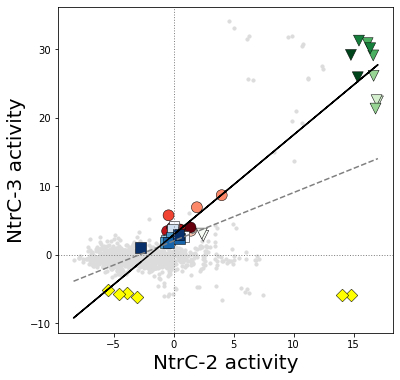

In [166]:
fig = _plot_activities_R2(ica_data_1k36,"NtrC-2","NtrC-3",
                          ['p1k_00836','p1k_00837', #minE_glyc
                           'p1k_00842','p1k_00843', #minE_N_starve
                           'p1k_00848','p1k_00849', #minE-pyr                         
                          ]
                         )
#fig.get_figure().savefig("../images/1k36_NtrC1_NtrC3.svg")

In [121]:
compare_activities_plotly('NtrC-1','NtrC-3')

In [151]:
compare_activities_plotly('NtrC-2','NtrC-3')

In [187]:
def _find_im(ica_data, gene_id):
    checker=0
    for iM in ica_data.imodulon_table.index:
        if gene_id in ica_data.view_imodulon(iM).index:
            print(iM)
            checker =1
    if checker ==0:
        print("No iM found")

In [188]:
_find_im(ica_data_1k36, gene2id('nac'))

NtrC-2
Nitrogen


<AxesSubplot:xlabel='Nitrogen iModulon Activity', ylabel='NtrC-1 iModulon Activity'>

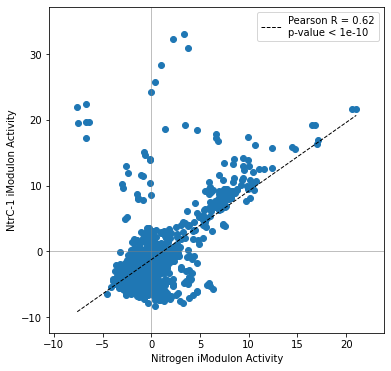

In [190]:
compare_activities(ica_data_1k36,'Nitrogen','NtrC-1')

<AxesSubplot:ylabel='Nitrogen iModulon\nActivity'>

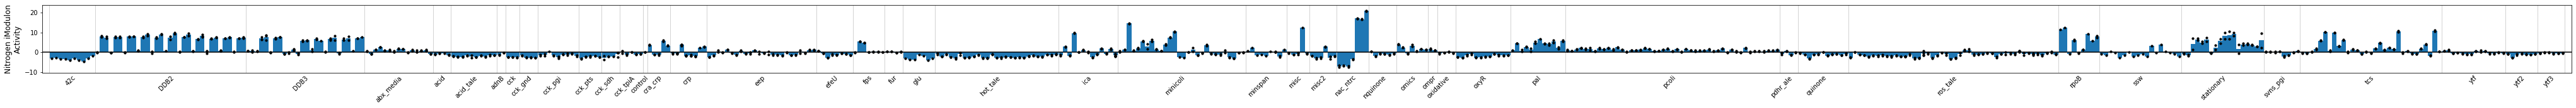

In [191]:
plot_activities(ica_data_1k36,"Nitrogen")

<AxesSubplot:ylabel='NtrC-1 iModulon\nActivity'>

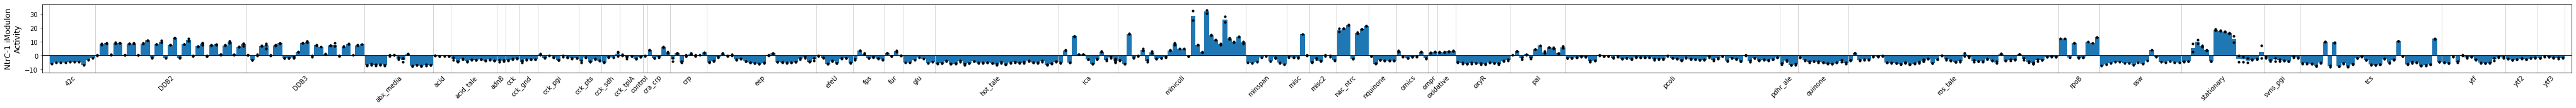

In [192]:
plot_activities(ica_data_1k36,"NtrC-1")

In [135]:
ica_data_1k36.sample_table.columns

Index(['sample_id', 'study', 'project', 'condition', 'rep_id',
       'Strain Description', 'Strain', 'Culture Type', 'Evolved Sample',
       'Base Media', 'Temperature (C)', 'pH', 'Carbon Source (g/L)',
       'Nitrogen Source (g/L)', 'Electron Acceptor', 'Trace Element Mixture',
       'Supplement', 'Antibiotic for selection', 'Growth Rate (1/hr)',
       'Isolate Type', 'Additional Details', 'project_reference',
       'Sequencing Machine', 'LibraryLayout', 'Platform',
       'Biological Replicates', 'DOI', 'GEO', 'SRX', 'Run', 'R1', 'R2',
       'contact', 'creator', 'passed_fastqc', 'passed_pct_reads_mapped',
       'passed_reads_mapped_to_CDS', 'passed_global_correlation', 'full_name',
       'passed_similar_replicates', 'passed_number_replicates', 'run_date'],
      dtype='object')

In [137]:
ica_data_1k36.sample_table.loc[  ['p1k_00836','p1k_00837',
                           'p1k_00842','p1k_00843',
                           'p1k_00848','p1k_00849']][['condition','Carbon Source (g/L)','Supplement']]

condition Carbon Source (g/L) Supplement
p1k_00836      minE_glyc                 NaN        NaN
p1k_00837      minE_glyc                 NaN        NaN
p1k_00842  minE_N_starve                 NaN        NaN
p1k_00843  minE_N_starve                 NaN        NaN
p1k_00848       minE-pyr                 NaN        NaN
p1k_00849       minE-pyr                 NaN        NaN

In [175]:
ica_data_1k36.sample_table[ica_data_1k36.sample_table.project=='minicoli'][['condition','DOI']]

condition  DOI
p1k_00826        aldA_f1c2  NaN
p1k_00827        aldA_minE  NaN
p1k_00828       mg1655_glc  NaN
p1k_00829       mg1655_glc  NaN
p1k_00830         minE_cyt  NaN
p1k_00831         minE_cyt  NaN
p1k_00832        minE_fruc  NaN
p1k_00833        minE_fruc  NaN
p1k_00834         minE_glc  NaN
p1k_00835         minE_glc  NaN
p1k_00836        minE_glyc  NaN
p1k_00837        minE_glyc  NaN
p1k_00838   minE_Fe_starve  NaN
p1k_00839   minE_Fe_starve  NaN
p1k_00840          minE_LB  NaN
p1k_00841          minE_LB  NaN
p1k_00842    minE_N_starve  NaN
p1k_00843    minE_N_starve  NaN
p1k_00844         minE_osm  NaN
p1k_00845         minE_osm  NaN
p1k_00846         minE_ph5  NaN
p1k_00847         minE_ph5  NaN
p1k_00848         minE-pyr  NaN
p1k_00849         minE-pyr  NaN
p1k_00850        minE_sorb  NaN
p1k_00851        minE_sorb  NaN
p1k_00852        minE_urid  NaN
p1k_00853        minE_urid  NaN
p1k_00854        W3110_cyt  NaN
p1k_00855        W3110_cyt  NaN
p1k_00858        W3110_glc  NaN
p1k_00859        W3110_glc  NaN
p1k_00860       W3110_glyc  NaN
p1k_00861       W3110_glyc  NaN
p1k_00862  W3110_Fe_starve  NaN
p1k_00863  W3110_Fe_starve  NaN
p1k_00864         W3110_LB  NaN
p1k_00865         W3110_LB  NaN
p1k_00866   W3110_N_starve  NaN
p1k_00867   W3110_N_starve  NaN
p1k_00868        W3110_osm  NaN
p1k_00869        W3110_osm  NaN
p1k_00870        W3110_ph5  NaN
p1k_00871        W3110_ph5  NaN
p1k_00872        W3110_pyr  NaN
p1k_00873        W3110_pyr  NaN
p1k_00874       W3110_sorb  NaN
p1k_00875       W3110_sorb  NaN
p1k_00876       W3110_urid  NaN
p1k_00877       W3110_urid  NaN
p1k_00878     W3110_WT_glc  NaN
p1k_00879     W3110_WT_glc  NaN
p1k_00880     W3110_WT_osm  NaN
p1k_00881     W3110_WT_osm  NaN

In [123]:
ica_data_1k36.sample_table[ica_data_1k36.sample_table.project=='nac_ntrc']

sample_id     study   project       condition  \
p1k_00027          nac_ntrc__wt_csn__1  Nac/NtrC  nac_ntrc          wt_csn   
p1k_00028          nac_ntrc__wt_csn__2  Nac/NtrC  nac_ntrc          wt_csn   
p1k_00029         nac_ntrc__wt_cytd__1  Nac/NtrC  nac_ntrc         wt_cytd   
p1k_00030         nac_ntrc__wt_cytd__2  Nac/NtrC  nac_ntrc         wt_cytd   
p1k_00031          nac_ntrc__wt_gln__1  Nac/NtrC  nac_ntrc          wt_gln   
p1k_00032          nac_ntrc__wt_gln__2  Nac/NtrC  nac_ntrc          wt_gln   
p1k_00033   nac_ntrc__bw_delnac_csn__1  Nac/NtrC  nac_ntrc   bw_delnac_csn   
p1k_00034   nac_ntrc__bw_delnac_csn__2  Nac/NtrC  nac_ntrc   bw_delnac_csn   
p1k_00035  nac_ntrc__bw_delnac_cytd__1  Nac/NtrC  nac_ntrc  bw_delnac_cytd   
p1k_00036  nac_ntrc__bw_delnac_cytd__2  Nac/NtrC  nac_ntrc  bw_delnac_cytd   
p1k_00037   nac_ntrc__bw_delnac_gln__1  Nac/NtrC  nac_ntrc   bw_delnac_gln   
p1k_00038   nac_ntrc__bw_delnac_gln__2  Nac/NtrC  nac_ntrc   bw_delnac_gln   
p1k_00039   nac_ntrc__bw_delnac_nh4__1  Nac/NtrC  nac_ntrc   bw_delnac_nh4   
p1k_00040   nac_ntrc__bw_delnac_nh4__2  Nac/NtrC  nac_ntrc   bw_delnac_nh4   

           rep_id                     Strain Description   Strain  \
p1k_00027       1           Escherichia coli K-12 MG1655   MG1655   
p1k_00028       2           Escherichia coli K-12 MG1655   MG1655   
p1k_00029       1           Escherichia coli K-12 MG1655   MG1655   
p1k_00030       2           Escherichia coli K-12 MG1655   MG1655   
p1k_00031       1           Escherichia coli K-12 MG1655   MG1655   
p1k_00032       2           Escherichia coli K-12 MG1655   MG1655   
p1k_00033       1  Escherichia coli K-12 BW25113 del_nac  BW25113   
p1k_00034       2  Escherichia coli K-12 BW25113 del_nac  BW25113   
p1k_00035       1  Escherichia coli K-12 BW25113 del_nac  BW25113   
p1k_00036       2  Escherichia coli K-12 BW25113 del_nac  BW25113   
p1k_00037       1  Escherichia coli K-12 BW25113 del_nac  BW25113   
p1k_00038       2  Escherichia coli K-12 BW25113 del_nac  BW25113   
p1k_00039       1  Escherichia coli K-12 BW25113 del_nac  BW25113   
p1k_00040       2  Escherichia coli K-12 BW25113 del_nac  BW25113   

          Culture Type Evolved Sample Base Media  ...       contact  \
p1k_00027        Batch             No         W2  ...  Donghyuk Kim   
p1k_00028        Batch             No         W2  ...  Donghyuk Kim   
p1k_00029        Batch             No         W2  ...  Donghyuk Kim   
p1k_00030        Batch             No         W2  ...  Donghyuk Kim   
p1k_00031        Batch             No         W2  ...  Donghyuk Kim   
p1k_00032        Batch             No         W2  ...  Donghyuk Kim   
p1k_00033        Batch             No         W2  ...  Donghyuk Kim   
p1k_00034        Batch             No         W2  ...  Donghyuk Kim   
p1k_00035        Batch             No         W2  ...  Donghyuk Kim   
p1k_00036        Batch             No         W2  ...  Donghyuk Kim   
p1k_00037        Batch             No         W2  ...  Donghyuk Kim   
p1k_00038        Batch             No         W2  ...  Donghyuk Kim   
p1k_00039        Batch             No         M9  ...  Donghyuk Kim   
p1k_00040        Batch             No         M9  ...  Donghyuk Kim   

                creator passed_fastqc passed_pct_reads_mapped  \
p1k_00027  Donghyuk Kim          True                    True   
p1k_00028  Donghyuk Kim          True                    True   
p1k_00029  Donghyuk Kim          True                    True   
p1k_00030  Donghyuk Kim          True                    True   
p1k_00031  Donghyuk Kim          True                    True   
p1k_00032  Donghyuk Kim          True                    True   
p1k_00033  Donghyuk Kim          True                    True   
p1k_00034  Donghyuk Kim          True                    True   
p1k_00035  Donghyuk Kim          True                    True   
p1k_00036  Donghyuk Kim          True                    True   
p1k_00037  Donghyuk Kim          True    

entire sample:  0.25 3.496384013251582e-17
0.83 2.9499521213854744e-10


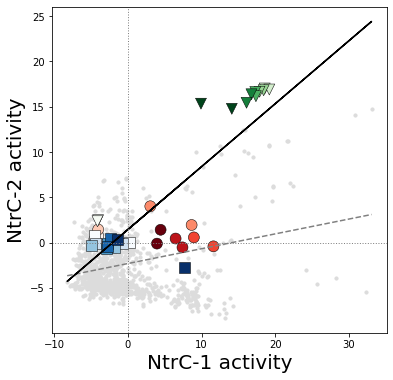

In [57]:
fig = _plot_activities_R2(ica_data_1k36,"NtrC-1","NtrC-2",[])


entire sample:  0.56 2.6084903601387053e-91
0.97 1.175162328127795e-22


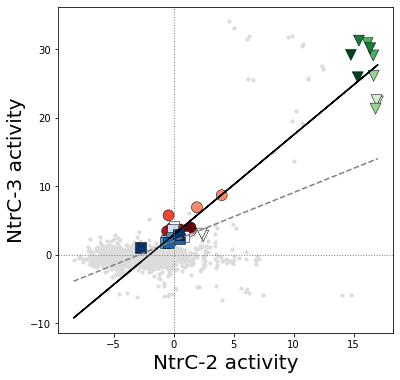

In [58]:
fig = _plot_activities_R2(ica_data_1k36,"NtrC-2","NtrC-3",[])


## CysB and Cbl

entire sample:  0.45 4.614693761049627e-54
0.81 2.4813893677637037e-09


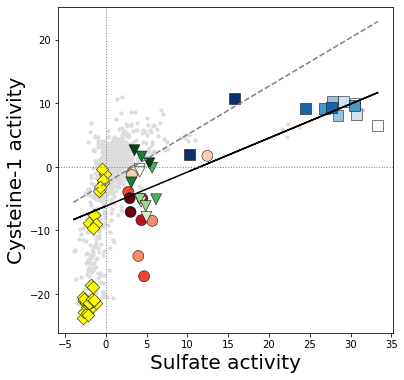

In [220]:
fig = _plot_activities_R2(ica_data_1k36,"Sulfate","Cysteine-1",
                        #  mylist
                         ica_data_1k36.sample_table[ica_data_1k36.sample_table.project=='abx_media'].index
                         )
#fig.get_figure().savefig("../images/1k36_Sulfate_Cys.svg")

entire sample:  0.45 4.614693761049627e-54
0.81 2.4813893677637037e-09


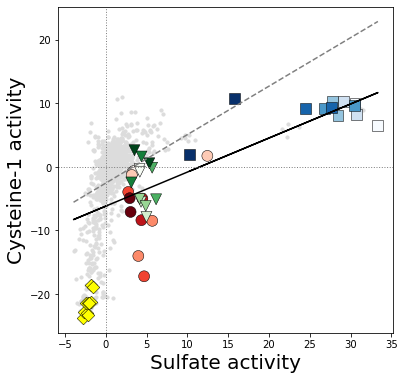

In [221]:
fig = _plot_activities_R2(ica_data_1k36,"Sulfate","Cysteine-1",
                        mylist
                         )

entire sample:  0.45 4.614693761049627e-54
0.81 2.4813893677637037e-09


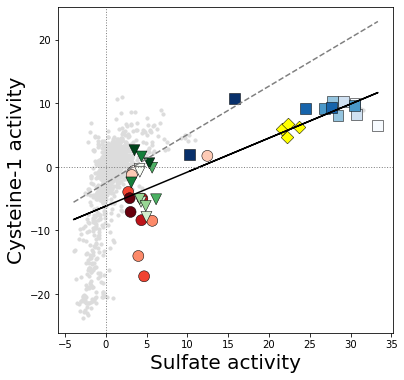

In [199]:
fig = _plot_activities_R2(ica_data_1k36,"Sulfate","Cysteine-1",
                          ['p1k_00394','p1k_00399','p1k_00400','p1k_00393'])
fig.get_figure().savefig("../images/1k36_Sulfate_Cys.svg")

In [ ]:
_plot_time_activities(ica_data_1k36)

In [196]:
compare_activities_plotly('Sulfate','Cysteine-1')

In [204]:
'RPMI' in ica_data_1k36.sample_table['Base Media']

False

In [210]:
i

'p1k_01056'

In [211]:
ica_data_1k36.sample_table.loc[i, 'Base Media']

nan

In [241]:
mylist=[]

for i in ica_data_1k36.sample_table.index:
    if ica_data_1k36.sample_table.loc[i, 'Base Media'] != ica_data_1k36.sample_table.loc[i, 'Base Media']:
        continue
            
    if 'RPMI' in ica_data_1k36.sample_table.loc[i, 'Base Media']:
        mylist.append(i)

In [242]:
mylist

['p1k_00359',
 'p1k_00360',
 'p1k_00365',
 'p1k_00366',
 'p1k_00371',
 'p1k_00372',
 'p1k_00377',
 'p1k_00378',
 'p1k_00383',
 'p1k_00384']

In [238]:
ica_data_1k36.A.loc['Cysteine-1'][mylist]

p1k_00357    -1.034375
p1k_00358    -0.358824
p1k_00359   -23.784539
p1k_00360   -22.806432
p1k_00361   -22.088992
p1k_00362   -22.139892
p1k_00622     4.058697
p1k_00623     3.870618
p1k_00684     4.537112
p1k_00685     2.862578
Name: Cysteine-1, dtype: float64

In [240]:
ica_data_1k36.sample_table.loc[mylist]

sample_id        study    project   condition  \
p1k_00357     abx_media__m9_ctrl__1  AntibiotICA  abx_media     m9_ctrl   
p1k_00358     abx_media__m9_ctrl__2  AntibiotICA  abx_media     m9_ctrl   
p1k_00359   abx_media__rpmi_ctrl__1  AntibiotICA  abx_media   rpmi_ctrl   
p1k_00360   abx_media__rpmi_ctrl__2  AntibiotICA  abx_media   rpmi_ctrl   
p1k_00361  abx_media__camhb_ctrl__1  AntibiotICA  abx_media  camhb_ctrl   
p1k_00362  abx_media__camhb_ctrl__2  AntibiotICA  abx_media  camhb_ctrl   
p1k_00622        pcoli__BRCActrl__1        pColi      pcoli    BRCActrl   
p1k_00623        pcoli__BRCActrl__2        pColi      pcoli    BRCActrl   
p1k_00684         pcoli__RFCctrl__1        pColi      pcoli     RFCctrl   
p1k_00685         pcoli__RFCctrl__2        pColi      pcoli     RFCctrl   

           rep_id                           Strain Description  Strain  \
p1k_00357       1                 Escherichia coli K-12 MG1655  MG1655   
p1k_00358       2                 Escherichia coli K-12 MG1655  MG1655   
p1k_00359       1                 Escherichia coli K-12 MG1655  MG1655   
p1k_00360       2                 Escherichia coli K-12 MG1655  MG1655   
p1k_00361       1                 Escherichia coli K-12 MG1655  MG1655   
p1k_00362       2                 Escherichia coli K-12 MG1655  MG1655   
p1k_00622       1  Escherichia coli K-12 MG1655 BRCA_optimized  MG1655   
p1k_00623       2  Escherichia coli K-12 MG1655 BRCA_optimized  MG1655   
p1k_00684       1   Escherichia coli K-12 MG1655 RFC_optimized  MG1655   
p1k_00685       2   Escherichia coli K-12 MG1655 RFC_optimized  MG1655   

          Culture Type Evolved Sample  Base Media  ...       contact  \
p1k_00357        Batch             No          M9  ...  Anand Sastry   
p1k_00358        Batch             No          M9  ...  Anand Sastry   
p1k_00359        Batch             No  RPMI+10%LB  ...  Anand Sastry   
p1k_00360        Batch             No  RPMI+10%LB  ...  Anand Sastry   
p1k_00361        Batch             No       CAMHB  ...  Anand Sastry   
p1k_00362        Batch             No       CAMHB  ...  Anand Sastry   
p1k_00622        Batch             No          M9  ...    Justin Tan   
p1k_00623        Batch             No          M9  ...    Justin Tan   
p1k_00684        Batch             No          M9  ...    Justin Tan   
p1k_00685        Batch             No          M9  ...    Justin Tan   

              creator passed_fastqc passed_pct_reads_mapped  \
p1k_00357    Julia Xu          True                    True   
p1k_00358    Julia Xu          True                    True   
p1k_00359    Julia Xu          True                    True   
p1k_00360    Julia Xu          True                    True   
p1k_00361    Julia Xu          True                   False   
p1k_00362    Julia Xu          True                    True   
p1k_00622  Justin Tan          True                    True   
p1k_00623  Justin Tan          True                    True   
p1k_00684  Justin Tan          True                    True   
p1k_00685  Justin Tan          True                    True   

          passed_reads_mapped_to_CDS passed_global_correlation  \
p1k_00357                       True                      True   
p1k_00358                       True                      True   
p1k_00359                       True                      True   
p1k_00360                       True                      True   
p1k_00361                       True                      True   
p1k_00362                       True                      True   
p1k_00622                       True                      True   
p1k_00623                       True                      True   
p1k_00684                       True                      True   
p1k_00685                       True                      True   

                      full_name passed_similar_replicates  \
p1k_00357     abx_media:m9_ctrl                      True   
p1k_00358     abx_media:m9_ctrl                  

<AxesSubplot:xlabel='Cysteine-1 Gene Weight', ylabel='Cysteine-2 Gene Weight'>

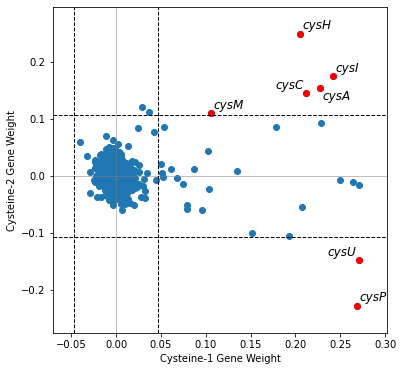

In [245]:
compare_gene_weights(ica_data_1k36, "Cysteine-1", "Cysteine-2")

entire sample:  0.45 4.614693761049627e-54
0.81 2.4813893677637037e-09


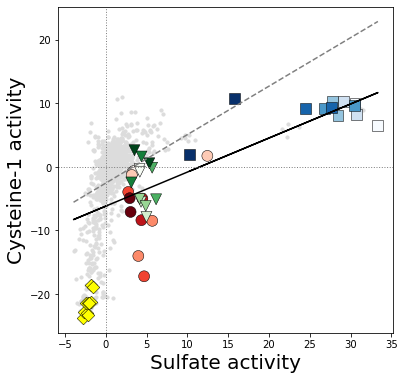

In [243]:
fig = _plot_activities_R2(ica_data_1k36,"Sulfate","Cysteine-1",
                          mylist
                         #ica_data_1k36.sample_table[ica_data_1k36.sample_table.project=='abx_media'].index
                         )
#fig.get_figure().savefig("../images/1k36_Sulfate_Cys.svg")

In [224]:
ica_data_1k36.sample_table[ica_data_1k36.A.loc['Cysteine-1'] < -20]

sample_id                  study    project  \
p1k_00019          oxidative__wt_pq__1              Oxidative  oxidative   
p1k_00020          oxidative__wt_pq__2              Oxidative  oxidative   
p1k_00021     oxidative__deloxyr_pq__1              Oxidative  oxidative   
p1k_00026     oxidative__delsoxs_pq__2              Oxidative  oxidative   
p1k_00167             ica__cytd_rib__1                    ICA        ica   
p1k_00168             ica__cytd_rib__2                    ICA        ica   
p1k_00176           ica__no3_anaero__2                    ICA        ica   
p1k_00359      abx_media__rpmi_ctrl__1            AntibiotICA  abx_media   
p1k_00360      abx_media__rpmi_ctrl__2            AntibiotICA  abx_media   
p1k_00361     abx_media__camhb_ctrl__1            AntibiotICA  abx_media   
p1k_00362     abx_media__camhb_ctrl__2            AntibiotICA  abx_media   
p1k_00365      abx_media__rpmi_mero__1            AntibiotICA  abx_media   
p1k_00366      abx_media__rpmi_mero__2            AntibiotICA  abx_media   
p1k_00367     abx_media__camhb_mero__1            AntibiotICA  abx_media   
p1k_00368     abx_media__camhb_mero__2            AntibiotICA  abx_media   
p1k_00373  abx_media__camhb_trisulf__1            AntibiotICA  abx_media   
p1k_00374  abx_media__camhb_trisulf__2            AntibiotICA  abx_media   
p1k_00377       abx_media__rpmi_cef__1            AntibiotICA  abx_media   
p1k_00378       abx_media__rpmi_cef__2            AntibiotICA  abx_media   
p1k_00379      abx_media__camhb_cef__1            AntibiotICA  abx_media   
p1k_00380      abx_media__camhb_cef__2            AntibiotICA  abx_media   
p1k_00383     abx_media__rpmi_cipro__1            AntibiotICA  abx_media   
p1k_00384     abx_media__rpmi_cipro__2            AntibiotICA  abx_media   
p1k_00385    abx_media__camhb_cipro__1            AntibiotICA  abx_media   
p1k_00386    abx_media__camhb_cipro__2            AntibiotICA  abx_media   
p1k_00457          tcs__del_baeR_lb__1  Two Component Systems        tcs   
p1k_00458          tcs__del_baeR_lb__2  Two Component Systems        tcs   
p1k_00461          tcs__del_btsR_lb__1  Two Component Systems        tcs   
p1k_00462          tcs__del_btsR_lb__2  Two Component Systems        tcs   
p1k_00467          tcs__del_cpxR_lb__1  Two Component Systems        tcs   
p1k_00468          tcs__del_cpxR_lb__2  Two Component Systems        tcs   
p1k_00483          tcs__del_rcsB_lb__1  Two Component Systems        tcs   
p1k_00484          tcs__del_rcsB_lb__2  Two Component Systems        tcs   
p1k_00485          tcs__del_zraR_lb__1  Two Component Systems        tcs   
p1k_00486          tcs__del_zraR_lb__2  Two Component Systems        tcs   
p1k_00584       ros_tale__2_0_750pq__1               ROS TALE   ros_tale   
p1k_00585       ros_tale__2_0_750pq__2               ROS TALE   ros_tale   
p1k_00597       ros_tale__3_1_250pq__2               ROS TALE   ros_tale   

               condition  rep_id                     Strain Description  \
p1k_00019          wt_pq       1           Escherichia coli K-12 MG1655   
p1k_00020          wt_pq       2           Escherichia coli K-12 MG1655   
p1k_00021     deloxyr_pq       1  Escherichia coli K-12 MG1655 del_oxyR   
p1k_00026     delsoxs_pq       2  Escherichia coli K-12 MG1655 del_soxS   
p1k_00167       cytd_rib       1           Escherichia coli K-12 MG1655   
p1k_00168       cytd_rib       2           Escherichia coli K-12 MG1655   
p1k_00176     no3_anaero       2           Escherichia coli K-12 MG1655   
p1k_00359      rpmi_ctrl       1           Escherichia coli K-12 MG1655   
p1k_00360      rpmi_ctrl       2           Escherichia coli K-12 MG1655   
p1k_00361     camhb_ctrl       1           Escherichia coli K-12 MG1655   
p1k_00362     camhb_ctrl       2           Escherichia coli K-12 MG1655   
p1k_00365      rpmi_mero       1           Escherichia coli K-12 MG1655   
p1k_00366      rpmi_mero       2           Escherichia coli K-12 MG1655   
p1k_00367     

In [230]:
ica_data_1k36.sample_table[ica_data_1k36.sample_table.project=='abx_media'][['Strain Description', 'condition','Supplement']]

Strain Description      condition  \
p1k_00357  Escherichia coli K-12 MG1655        m9_ctrl   
p1k_00358  Escherichia coli K-12 MG1655        m9_ctrl   
p1k_00359  Escherichia coli K-12 MG1655      rpmi_ctrl   
p1k_00360  Escherichia coli K-12 MG1655      rpmi_ctrl   
p1k_00361  Escherichia coli K-12 MG1655     camhb_ctrl   
p1k_00362  Escherichia coli K-12 MG1655     camhb_ctrl   
p1k_00363  Escherichia coli K-12 MG1655        m9_mero   
p1k_00364  Escherichia coli K-12 MG1655        m9_mero   
p1k_00365  Escherichia coli K-12 MG1655      rpmi_mero   
p1k_00366  Escherichia coli K-12 MG1655      rpmi_mero   
p1k_00367  Escherichia coli K-12 MG1655     camhb_mero   
p1k_00368  Escherichia coli K-12 MG1655     camhb_mero   
p1k_00369  Escherichia coli K-12 MG1655     m9_trisulf   
p1k_00370  Escherichia coli K-12 MG1655     m9_trisulf   
p1k_00371  Escherichia coli K-12 MG1655   rpmi_trisulf   
p1k_00372  Escherichia coli K-12 MG1655   rpmi_trisulf   
p1k_00373  Escherichia coli K-12 MG1655  camhb_trisulf   
p1k_00374  Escherichia coli K-12 MG1655  camhb_trisulf   
p1k_00375  Escherichia coli K-12 MG1655         m9_cef   
p1k_00376  Escherichia coli K-12 MG1655         m9_cef   
p1k_00377  Escherichia coli K-12 MG1655       rpmi_cef   
p1k_00378  Escherichia coli K-12 MG1655       rpmi_cef   
p1k_00379  Escherichia coli K-12 MG1655      camhb_cef   
p1k_00380  Escherichia coli K-12 MG1655      camhb_cef   
p1k_00381  Escherichia coli K-12 MG1655       m9_cipro   
p1k_00382  Escherichia coli K-12 MG1655       m9_cipro   
p1k_00383  Escherichia coli K-12 MG1655     rpmi_cipro   
p1k_00384  Escherichia coli K-12 MG1655     rpmi_cipro   
p1k_00385  Escherichia coli K-12 MG1655    camhb_cipro   
p1k_00386  Escherichia coli K-12 MG1655    camhb_cipro   

                                        Supplement  
p1k_00357                                      NaN  
p1k_00358                                      NaN  
p1k_00359                                      NaN  
p1k_00360                                      NaN  
p1k_00361                                      NaN  
p1k_00362                                      NaN  
p1k_00363                      meropenem(128ug/mL)  
p1k_00364                      meropenem(128ug/mL)  
p1k_00365                       meropenem(32ug/mL)  
p1k_00366                       meropenem(32ug/mL)  
p1k_00367                      meropenem(256ug/mL)  
p1k_00368                      meropenem(256ug/mL)  
p1k_00369  trimethoprim-sulfamethoxazole(131mg/mL)  
p1k_00370  trimethoprim-sulfamethoxazole(131mg/mL)  
p1k_00371   trimethoprim-sulfamethoxazole(16mg/mL)  
p1k_00372   trimethoprim-sulfamethoxazole(16mg/mL)  
p1k_00373   trimethoprim-sulfamethoxazole(16mg/mL)  
p1k_00374   trimethoprim-sulfamethoxazole(16mg/mL)  
p1k_00375                    ceftriaxone(4.1mg/mL)  
p1k_00376                    ceftriaxone(4.1mg/mL)  
p1k_00377                    ceftriaxone(256ug/mL)  
p1k_00378                    ceftriaxone(256ug/mL)  
p1k_00379                    ceftriaxone(256ug/mL)  
p1k_00380                    ceftriaxone(256ug/mL)  
p1k_00381                   ciprofloxacin(32ug/mL)  
p1k_00382                   ciprofloxacin(32ug/mL)  
p1k_00383                   ciprofloxacin(64ug/mL)  
p1k_00384                   ciprofloxacin(64ug/mL)  
p1k_00385                   ciprofloxacin(16ug/mL)  
p1k_00386                   ciprofloxacin(16ug/mL)

In [231]:
mylist=[]

for i in ica_data_1k36.sample_table.index:
    if ica_data_1k36.sample_table.loc[i, 'Base Media'] != ica_data_1k36.sample_table.loc[i, 'Base Media']:
        continue
            
    if 'ctrl' in ica_data_1k36.sample_table.loc[i, 'condition']:
        mylist.append(i)

In [232]:
mylist

['p1k_00357',
 'p1k_00358',
 'p1k_00359',
 'p1k_00360',
 'p1k_00361',
 'p1k_00362',
 'p1k_00622',
 'p1k_00623',
 'p1k_00684',
 'p1k_00685']

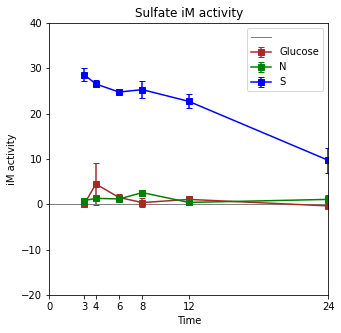

In [257]:
fig, ax = _plot_time_activities(ica_data_1k36, "Sulfate", group_dict)
ax.set_ylim(bottom = -20, top=40)
fig.savefig("../images/sulfate_time.svg")

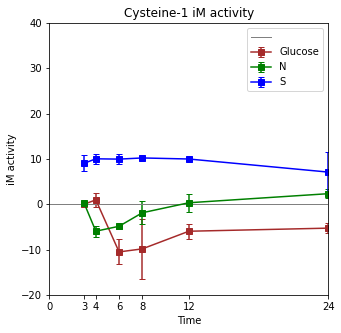

In [258]:
fig, ax = _plot_time_activities(ica_data_1k36, "Cysteine-1", group_dict)
ax.set_ylim(bottom = -20, top=40)
fig.savefig("../images/cysteine-1_time.svg")

(-20.0, 40.0)

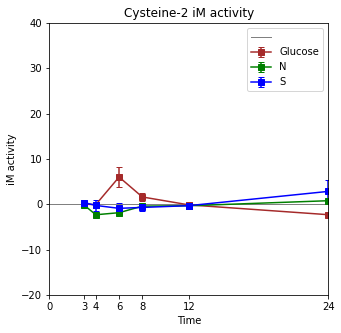

In [256]:
fig, ax = _plot_time_activities(ica_data_1k36, "Cysteine-2", group_dict)
ax.set_ylim(bottom = -20, top=40)
#fig.savefig("../images/ntrC1_time.svg")

In [217]:
ica_data_1k36.sample_table.loc[mylist]

sample_id        study    project     condition  \
p1k_00359     abx_media__rpmi_ctrl__1  AntibiotICA  abx_media     rpmi_ctrl   
p1k_00360     abx_media__rpmi_ctrl__2  AntibiotICA  abx_media     rpmi_ctrl   
p1k_00365     abx_media__rpmi_mero__1  AntibiotICA  abx_media     rpmi_mero   
p1k_00366     abx_media__rpmi_mero__2  AntibiotICA  abx_media     rpmi_mero   
p1k_00371  abx_media__rpmi_trisulf__1  AntibiotICA  abx_media  rpmi_trisulf   
p1k_00372  abx_media__rpmi_trisulf__2  AntibiotICA  abx_media  rpmi_trisulf   
p1k_00377      abx_media__rpmi_cef__1  AntibiotICA  abx_media      rpmi_cef   
p1k_00378      abx_media__rpmi_cef__2  AntibiotICA  abx_media      rpmi_cef   
p1k_00383    abx_media__rpmi_cipro__1  AntibiotICA  abx_media    rpmi_cipro   
p1k_00384    abx_media__rpmi_cipro__2  AntibiotICA  abx_media    rpmi_cipro   

           rep_id            Strain Description  Strain Culture Type  \
p1k_00359       1  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00360       2  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00365       1  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00366       2  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00371       1  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00372       2  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00377       1  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00378       2  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00383       1  Escherichia coli K-12 MG1655  MG1655        Batch   
p1k_00384       2  Escherichia coli K-12 MG1655  MG1655        Batch   

          Evolved Sample  Base Media  ...       contact   creator  \
p1k_00359             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00360             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00365             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00366             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00371             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00372             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00377             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00378             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00383             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   
p1k_00384             No  RPMI+10%LB  ...  Anand Sastry  Julia Xu   

          passed_fastqc passed_pct_reads_mapped passed_reads_mapped_to_CDS  \
p1k_00359          True                    True                       True   
p1k_00360          True                    True                       True   
p1k_00365          True                    True                       True   
p1k_00366          True                    True                       True   
p1k_00371          True                    True                       True   
p1k_00372          True                    True                       True   
p1k_00377          True                    True                       True   
p1k_00378          True                    True                       True   
p1k_00383          True                    True                       True   
p1k_00384          True                    True                       True   

          passed_global_correlation               full_name  \
p1k_00359                      True     abx_media:rpmi_ctrl   
p1k_00360                      True     abx_media:rpmi_ctrl   
p1k_00365                      True     abx_media:rpmi_mero   
p1k_00366                      True     abx_media:rpmi_mero   
p1k_00371                      True  abx_media:rpmi_trisulf   
p1k_00372                      True  abx_media:rpmi_trisulf   
p1k_00377                      True      abx_media:rpmi_cef   
p1k_00378                      True      abx_media:rpmi_cef   
p1k_00383                      True    abx_media:rpmi_cipro   
p1k_00384                      True    abx_media:rpmi_cipro   

          passed_similar_replicates  passed_number_r

# Gene weights

In [20]:
plt.rcParams["figure.figsize"] = (5,5)

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


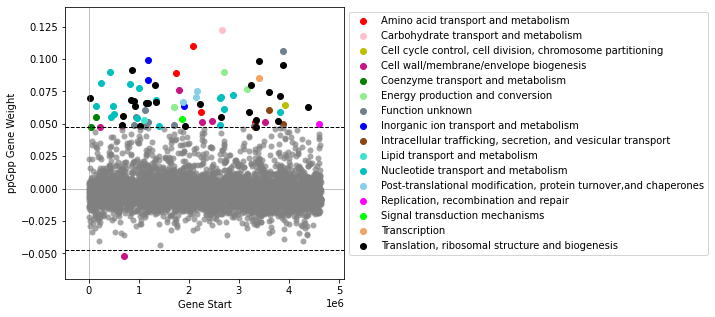

In [21]:
fig = plot_gene_weights(ica_data_1k36,"ppGpp")
fig.figure.savefig("../images/gene_weights/GW_ppGpp.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


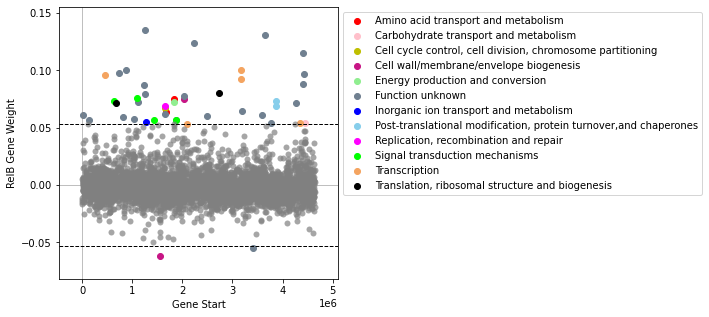

In [22]:
fig = plot_gene_weights(ica_data_1k36,"RelB")
fig.figure.savefig("../images/gene_weights/GW_RelB.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


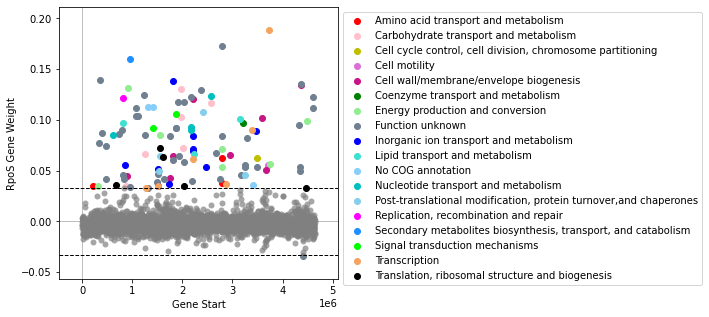

In [23]:
fig = plot_gene_weights(ica_data_1k36,"RpoS")
fig.figure.savefig("../images/gene_weights/GW_RpoS.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


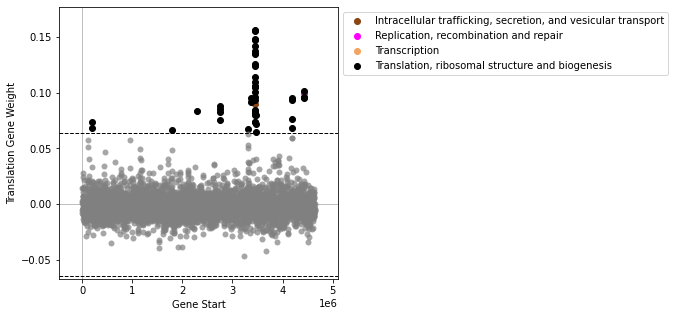

In [24]:
fig = plot_gene_weights(ica_data_1k36,"Translation")
fig.figure.savefig("../images/gene_weights/GW_Translation.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


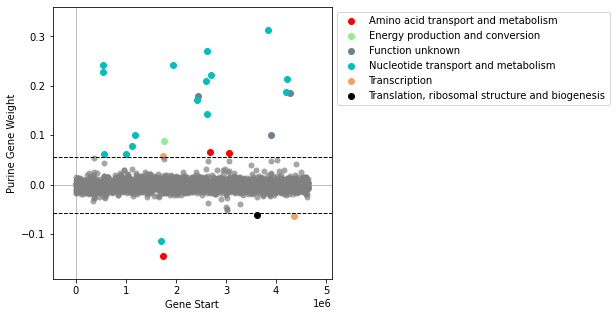

In [25]:
fig = plot_gene_weights(ica_data_1k36,"Purine")
fig.figure.savefig("../images/gene_weights/GW_Purine.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


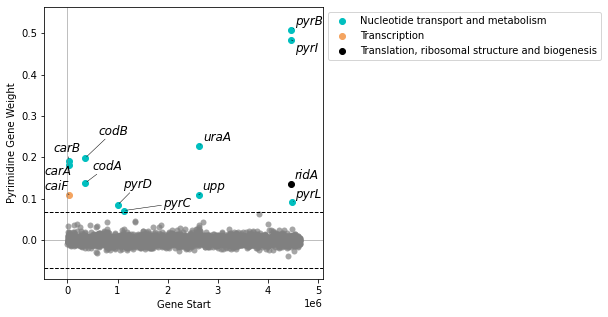

In [26]:
fig = plot_gene_weights(ica_data_1k36,"Pyrimidine")
fig.figure.savefig("../images/gene_weights/GW_Pyrimidine.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


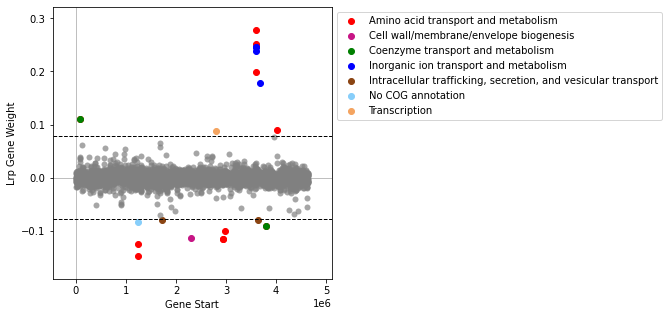

In [27]:
fig = plot_gene_weights(ica_data_1k36,"Lrp")
fig.figure.savefig("../images/gene_weights/GW_Lrp.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


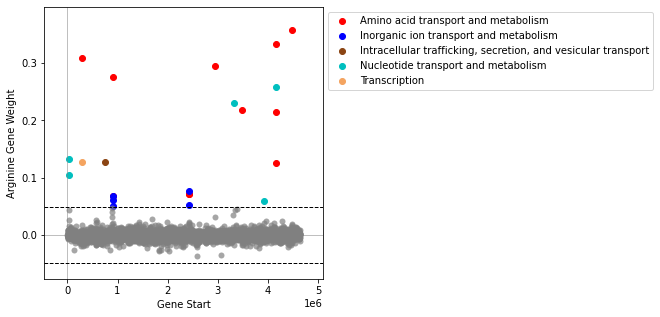

In [28]:
fig = plot_gene_weights(ica_data_1k36,"Arginine")
fig.figure.savefig("../images/gene_weights/GW_Arginine.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


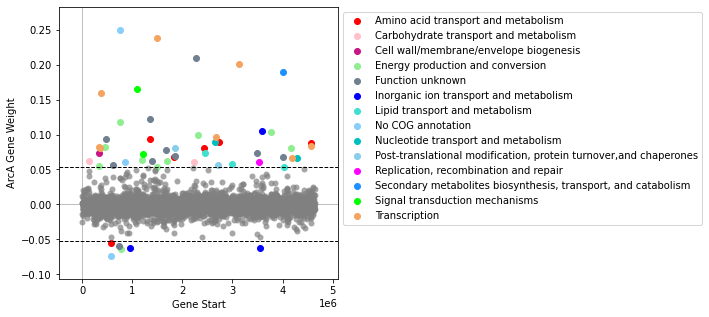

In [29]:
fig = plot_gene_weights(ica_data_1k36,"ArcA")
fig.figure.savefig("../images/gene_weights/GW_ArcA.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


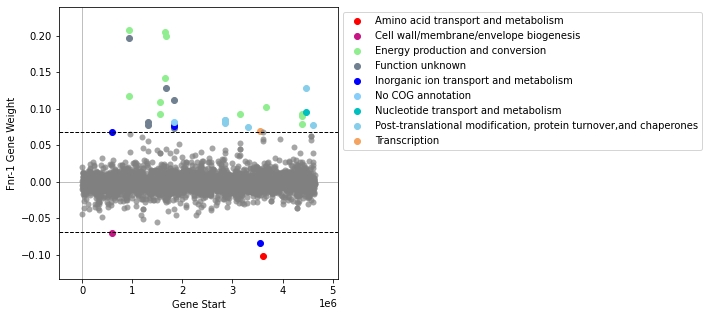

In [30]:
fig = plot_gene_weights(ica_data_1k36,"Fnr-1")
fig.figure.savefig("../images/gene_weights/GW_Fnr-1.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


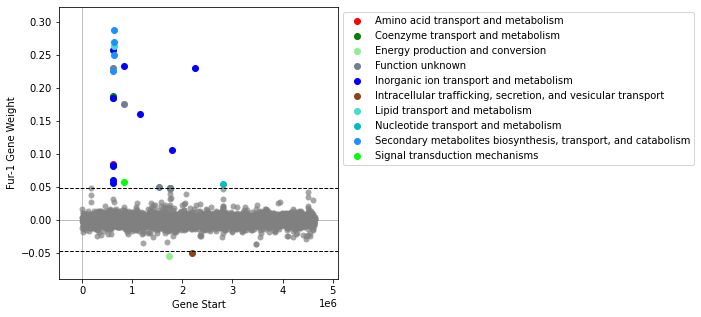

In [31]:
fig = plot_gene_weights(ica_data_1k36,"Fur-1")
fig.figure.savefig("../images/gene_weights/GW_Fur-1.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


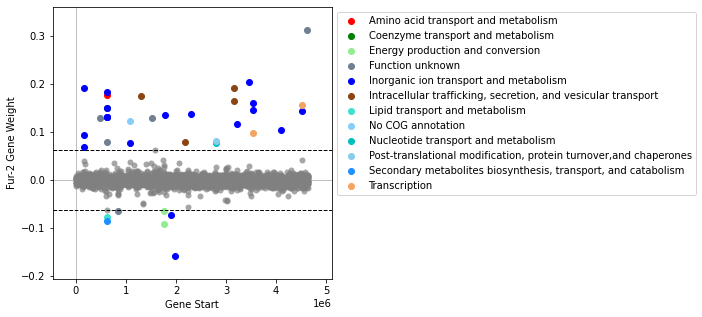

In [32]:
fig = plot_gene_weights(ica_data_1k36,"Fur-2")
fig.figure.savefig("../images/gene_weights/GW_Fur-2.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


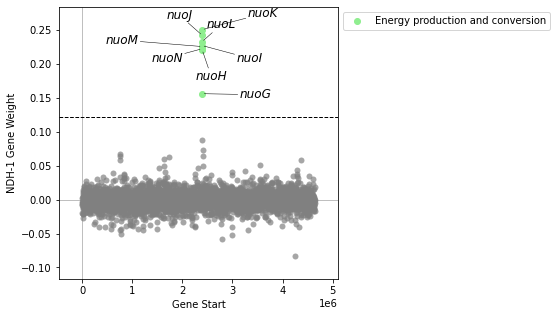

In [33]:
fig = plot_gene_weights(ica_data_1k36,"NDH-1")
fig.figure.savefig("../images/gene_weights/GW_NDH-1.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


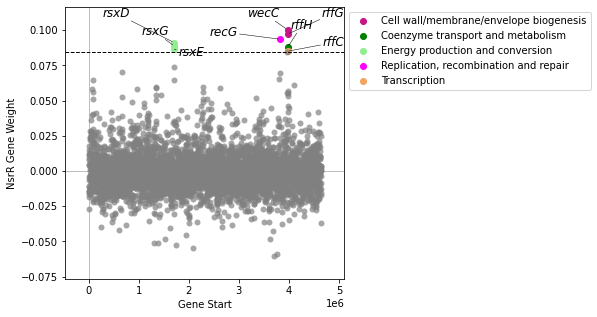

In [34]:
fig = plot_gene_weights(ica_data_1k36,"NsrR")
fig.figure.savefig("../images/gene_weights/GW_NsrR.svg")

# Expression of major regulators

In [14]:
df_reg_x = group_dict.copy()
for i in df_reg_x.index:
    df_reg_x.loc[i, 'crp_X'] = ica_data_1k36_stationary.X.loc[gene2id('crp')][i]
    df_reg_x.loc[i, 'ntrC_X'] = ica_data_1k36_stationary.X.loc[gene2id('glnG')][i]
    df_reg_x.loc[i, 'cysB_X'] = ica_data_1k36_stationary.X.loc[gene2id('cysB')][i]
    df_reg_x.loc[i, 'cbl_X'] = ica_data_1k36_stationary.X.loc[gene2id('cbl')][i]

In [15]:
from bioinfokit import analys, visuz

TypeError: general.get_figure() missing 1 required positional argument: 'theme'

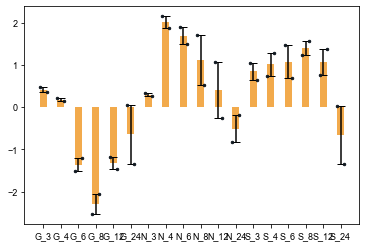

In [24]:
df = pd.DataFrame(index = range(0,2), columns = df_reg_x.med_time.unique())
temp_df = df_reg_x[['med_time', 'crp_X']]

for i in df.columns:
    df[i][0] = temp_df[temp_df.med_time==i].iloc[0,1]
    df[i][1] = temp_df[temp_df.med_time==i].iloc[1,1]
    
df = df.astype('float')
fig = visuz.stat.bardot(df=df)

TypeError: general.get_figure() missing 1 required positional argument: 'theme'

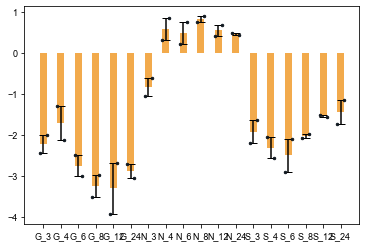

In [26]:
df = pd.DataFrame(index = range(0,2), columns = df_reg_x.med_time.unique())
temp_df = df_reg_x[['med_time', 'ntrC_X']]

for i in df.columns:
    df[i][0] = temp_df[temp_df.med_time==i].iloc[0,1]
    df[i][1] = temp_df[temp_df.med_time==i].iloc[1,1]
    
df = df.astype('float')
fig = visuz.stat.bardot(df=df)

TypeError: general.get_figure() missing 1 required positional argument: 'theme'

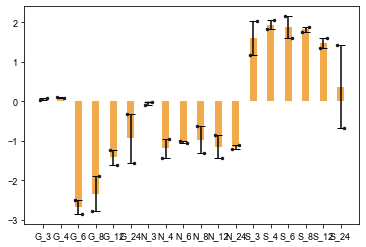

In [27]:
df = pd.DataFrame(index = range(0,2), columns = df_reg_x.med_time.unique())
temp_df = df_reg_x[['med_time', 'cysB_X']]

for i in df.columns:
    df[i][0] = temp_df[temp_df.med_time==i].iloc[0,1]
    df[i][1] = temp_df[temp_df.med_time==i].iloc[1,1]
    
df = df.astype('float')
fig = visuz.stat.bardot(df=df)

TypeError: general.get_figure() missing 1 required positional argument: 'theme'

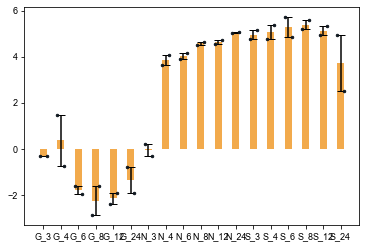

In [28]:
df = pd.DataFrame(index = range(0,2), columns = df_reg_x.med_time.unique())
temp_df = df_reg_x[['med_time', 'cbl_X']]

for i in df.columns:
    df[i][0] = temp_df[temp_df.med_time==i].iloc[0,1]
    df[i][1] = temp_df[temp_df.med_time==i].iloc[1,1]
    
df = df.astype('float')
fig = visuz.stat.bardot(df=df)

In [156]:
df_reg_x2 = group_dict.copy()
for i in df_reg_x2.index:
    df_reg_x2.loc[i, 'gatR_X'] = ica_data_1k36_stationary.X.loc[gene2id('gatR')][i]
    df_reg_x2.loc[i, 'galR_X'] = ica_data_1k36_stationary.X.loc[gene2id('galR')][i]
    df_reg_x2.loc[i, 'galS_X'] = ica_data_1k36_stationary.X.loc[gene2id('galS')][i]
#    df_reg_x.loc[i, 'manR_X'] = ica_data_1k36_stationary.X.loc[gene2id('manR')][i]

TypeError: general.get_figure() missing 1 required positional argument: 'theme'

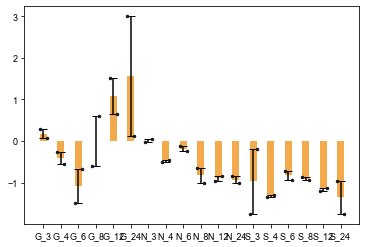

In [161]:
df = pd.DataFrame(index = range(0,2), columns = df_reg_x2.med_time.unique())
temp_df = df_reg_x2[['med_time', 'gatR_X']]

for i in df.columns:
    df[i][0] = temp_df[temp_df.med_time==i].iloc[0,1]
    df[i][1] = temp_df[temp_df.med_time==i].iloc[1,1]
    
df = df.astype('float')
fig = visuz.stat.bardot(df=df)

TypeError: general.get_figure() missing 1 required positional argument: 'theme'

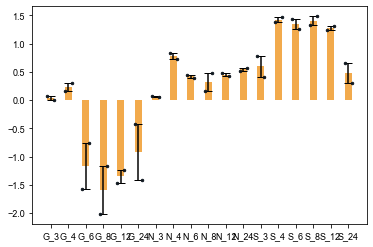

In [160]:
df = pd.DataFrame(index = range(0,2), columns = df_reg_x2.med_time.unique())
temp_df = df_reg_x2[['med_time', 'galR_X']]

for i in df.columns:
    df[i][0] = temp_df[temp_df.med_time==i].iloc[0,1]
    df[i][1] = temp_df[temp_df.med_time==i].iloc[1,1]
    
df = df.astype('float')
fig = visuz.stat.bardot(df=df)

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



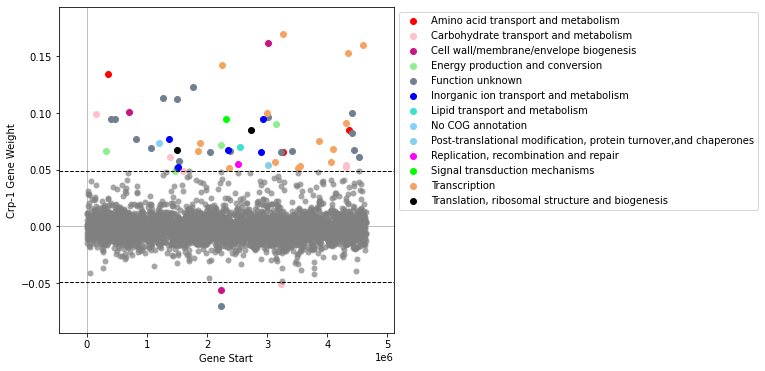

In [139]:
fig = plot_gene_weights(ica_data_1k36,"Crp-1")
fig.figure.savefig("../images/gene_weights/GW_Crp-1.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



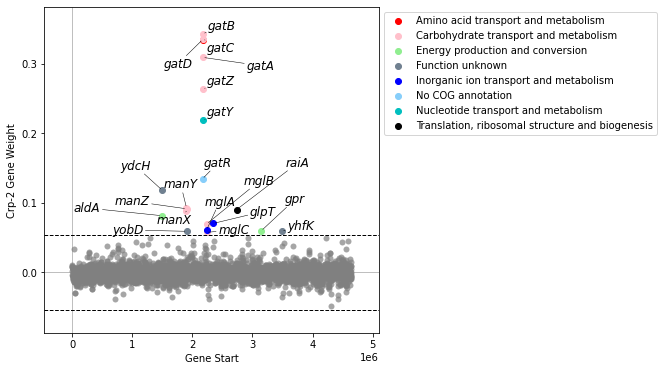

In [140]:
fig = plot_gene_weights(ica_data_1k36,"Crp-2")
fig.figure.savefig("../images/gene_weights/GW_Crp-2.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



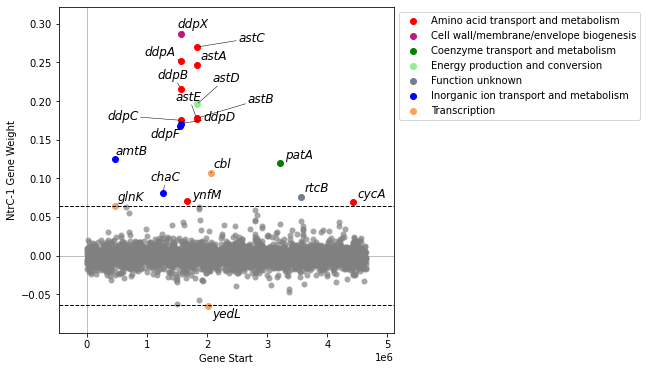

In [141]:
fig = plot_gene_weights(ica_data_1k36,"NtrC-1")
fig.figure.savefig("../images/gene_weights/GW_NtrC-1.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



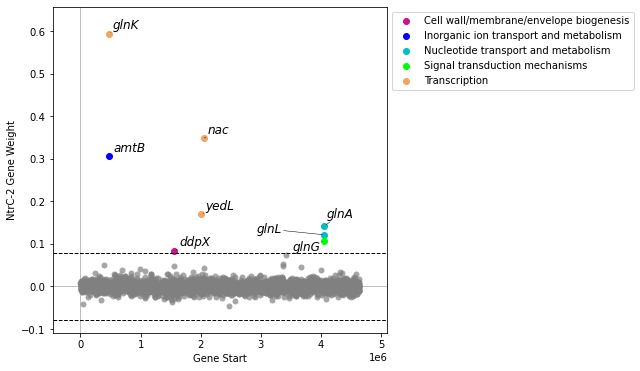

In [142]:
fig = plot_gene_weights(ica_data_1k36,"NtrC-2")
fig.figure.savefig("../images/gene_weights/GW_NtrC-2.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



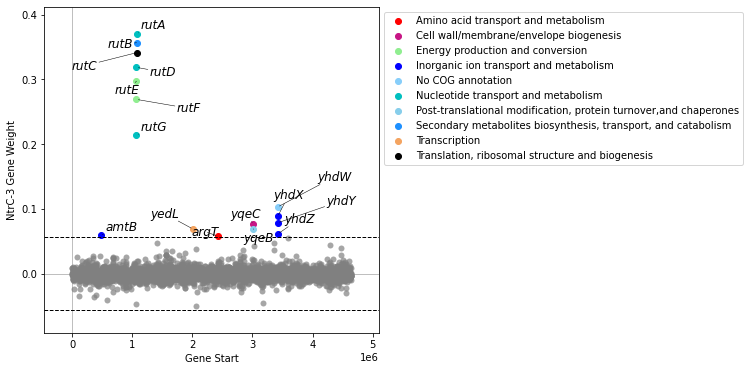

In [143]:
fig = plot_gene_weights(ica_data_1k36,"NtrC-3")
fig.figure.savefig("../images/gene_weights/GW_NtrC-3.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



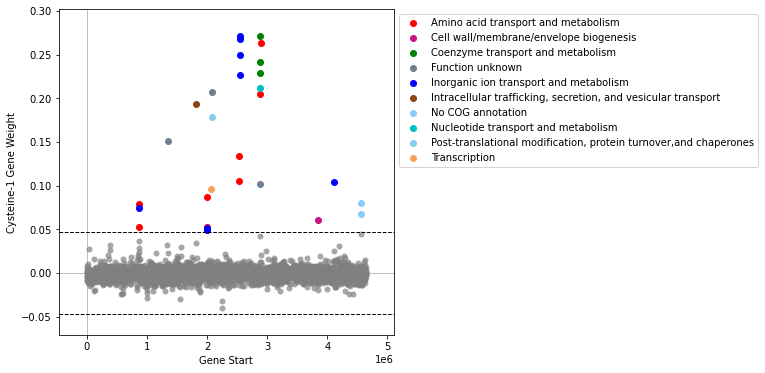

In [144]:
fig = plot_gene_weights(ica_data_1k36,"Cysteine-1")
fig.figure.savefig("../images/gene_weights/GW_Cysteine-1.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



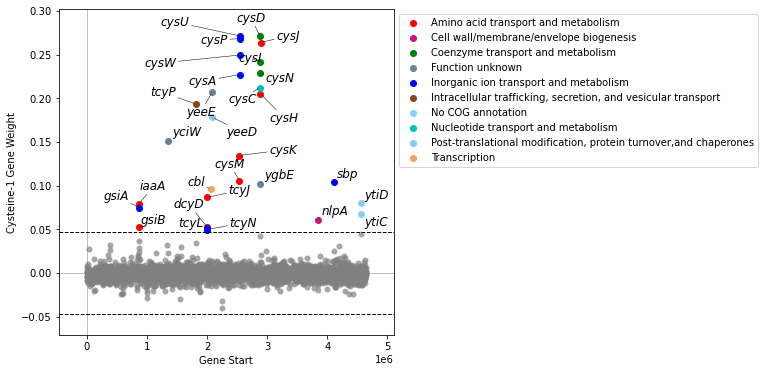

In [195]:
fig = plot_gene_weights(ica_data_1k36,"Cysteine-1", show_labels=True)

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



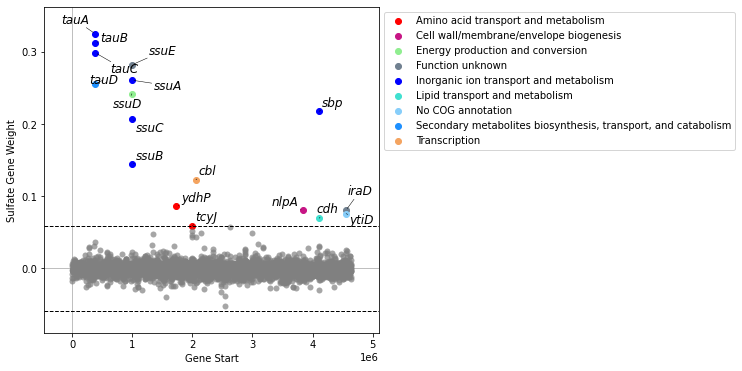

In [145]:
fig = plot_gene_weights(ica_data_1k36,"Sulfate")
fig.figure.savefig("../images/gene_weights/GW_Sulfate.svg")

# Extracellular polymer proudction 

In [230]:
pol_iMs = ['Curli-1','Curli-2','Cellulose','Biofilm']

## Curli-1

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


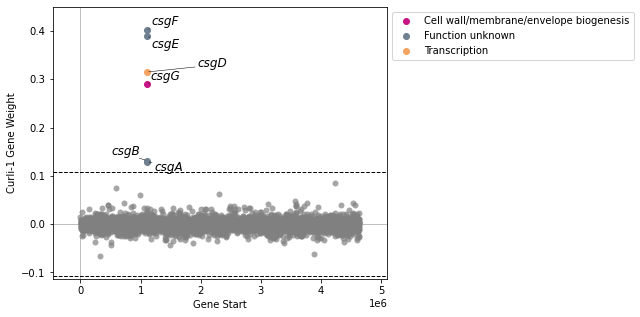

In [86]:
fig=plot_gene_weights(ica_data_1k36,pol_iMs[0])
fig.figure.set_size_inches(6,5)

In [238]:
ica_data_1k36.sample_table[ica_data_1k36.A.loc['Curli-1'] == ica_data_1k36.A.loc['Curli-1'].max()]

sample_id             study     project     condition  \
p1k_01082  S-GlcM9_2_4h__1  Stationary_phase  stationary  S-GlcM9_2_4h   

           rep_id            Strain Description  Strain Culture Type  \
p1k_01082       1  Escherichia coli K-12 MG1655  MG1655        Batch   

          Evolved Sample Base Media  ...      contact      creator  \
p1k_01082            NaN        NaN  ...  Hyungyu Lim  Hyungyu Lim   

          passed_fastqc passed_pct_reads_mapped passed_reads_mapped_to_CDS  \
p1k_01082          True                    True                       True   

          passed_global_correlation                full_name  \
p1k_01082                      True  stationary:S-GlcM9_2_4h   

          passed_similar_replicates  passed_number_replicates run_date  
p1k_01082                      True                      True  2/10/22  

[1 rows x 42 columns]

In [237]:
ica_data_1k36.A.loc['Curli-1'].max()

12.05719492449558

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



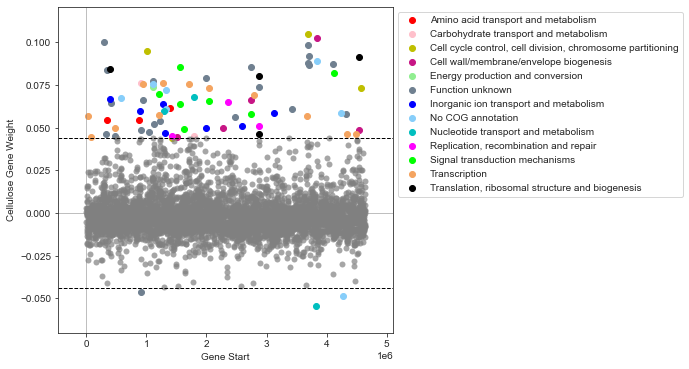

In [243]:
fig=plot_gene_weights(ica_data_1k36,'Cellulose')

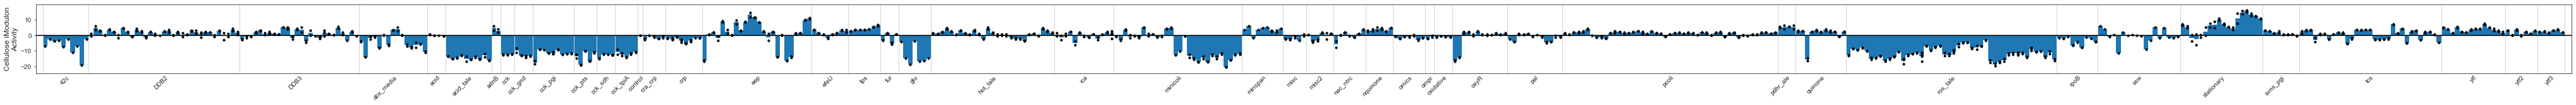

In [245]:
plot_activities(ica_data_1k36, 'Cellulose')
plt.savefig("../images/cellulose_A.svg")

In [242]:
ica_data_1k36.view_imodulon('Cellulose').sort_values(by='gene_weight', ascending=False).head(20)

gene_weight gene_name         synonyms  \
b3534     0.104911      bcsQ        bcsQ;yhjQ   
b3661     0.102668      nlpA             nlpA   
b0287     0.099948      yagU             yagU   
b3535     0.098528      yhjR             yhjR   
b0946     0.095017      zapC        zapC;ycbW   
b3537     0.092089      bcsF        bcsF;yhjT   
b4657     0.091205      yjhZ              NaN   
b4555     0.089064      yicS             yicS   
b3536     0.087699      bcsE        bcsE;yhjS   
b3922     0.087028      yiiS             yiiS   
b3538     0.086583      bcsG        bcsG;yhjU   
b2603     0.085649      yfiR             yfiR   
b1490     0.085588      dosC   dosC;dgcO;yddV   
b0382     0.084372      iraP        iraP;yaiB   
b0329     0.083740      yahO             yahO   
b3923     0.081797      uspD        uspD;yiiT   
b2756     0.080468      casE  casE;cas6e;ygcH   
b1915     0.078807      yecF             yecF   
b1056     0.077183      yceI             yceI   
b0875     0.076249      aqpZ        aqpZ;bniP   

                                            gene_product  \
b3534                     cellulose biosynthesis protein   
b3661                                     lipoprotein-28   
b0287  inner membrane protein that contributes to aci...   
b3535                        PF10945 family protein YhjR   
b0946                         cell division protein ZapC   
b3537       putative cellulose biosynthesis protein BcsF   
b4657  KpLE2 phage-like element%3B putative acetyltra...   
b4555                       uncharacterized protein YicS   
b3536                      c-di-GMP-binding protein BcsE   
b3922              DUF406 domain-containing protein YiiS   
b3538          cellulose phosphoethanolamine transferase   
b2603             DUF4154 domain-containing protein YfiR   
b1490                           diguanylate cyclase DosC   
b0382    anti-adaptor protein for sigma(S) stabilization   
b0329             DUF1471 domain-containing protein YahO   
b3923                         universal stress protein D   
b2756                        pre-CRISPR RNA endonuclease   
b1915             DUF2594 domain-containing protein YecF   
b1056                                       protein YceI   
b0875                                 water channel AqpZ   

                                                     COG  \
b3534  Cell cycle control, cell division, chromosome ...   
b3661             Cell wall/membrane/envelope biogenesis   
b0287                                   Function unknown   
b3535                                   Function unknown   
b0946  Cell cycle control, cell division, chromosome ...   
b3537                                   Function unknown   
b4657    Translation, ribosomal structure and biogenesis   
b4555                                  No COG annotation   
b3536                                   Function unknown   
b3922                                   Function unknown   
b3538                                   Function unknown   
b2603                                   Function unknown   
b1490                     Signal transduction mechanisms   
b0382    Translation, ribosomal structure and biogenesis   
b0329                                   Function unknown   
b3923                     Signal transduction mechanisms   
b2756    Translation, ribosomal structure and biogenesis   
b1915                                   Function unknown   
b1056                                   Function unknown   
b0875              Carbohydrate transport and metabolism   

                                     regulator uniprot    start      end  \
b3534                                      NaN     NaN  3695233  3695985   
b3661                     ppGpp,CsgD,GlaR,gcvB  P04846  3839175  3839993   
b0287                  YfeC,YfeD,ppGpp,Lrp,Nac  P0AAA1   302991   303605   
b3535                                 RpoD,Lrp  P0ADJ3  3695997  3696185   
b0946                                      NaN  P75862  1005952  1006494   

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



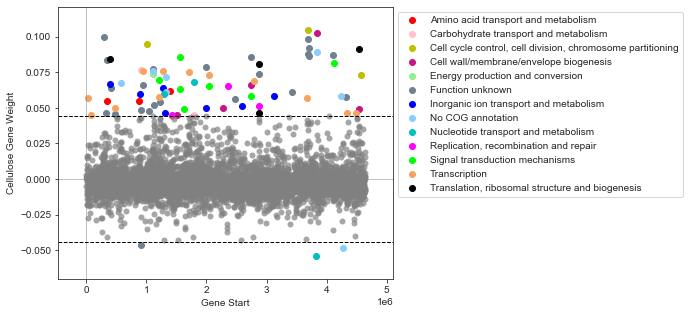

In [228]:
fig=plot_gene_weights(ica_data_1k36,'Cellulose')
fig.figure.set_size_inches(6,5)

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Curli-1 iM activity'}, xlabel='Time', ylabel='iM activity'>)

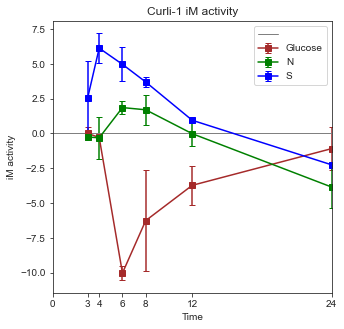

In [227]:
_plot_time_activities(ica_data_1k36_stationary, 'Curli-1', group_dict)

<AxesSubplot:ylabel='Curli-1 iModulon\nActivity'>

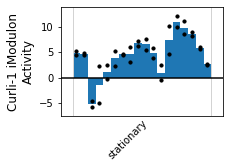

In [123]:
plot_activities(ica_data_1k36_stationary, 'Curli-1')

## Curli-1 vs Curli-2

In [139]:
curli1 = ica_data_1k36.view_imodulon('Curli-1').index
curli2 = ica_data_1k36.view_imodulon('Curli-2').index

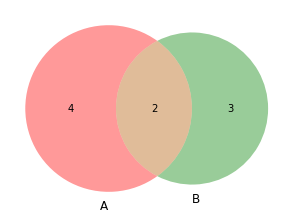

In [142]:
venn2([set(curli1), set(curli2)])

In [271]:
ica_data_1k36.view_imodulon('Curli-1')

gene_weight gene_name synonyms  \
b1037     0.290527      csgG     csgG   
b1038     0.402464      csgF     csgF   
b1039     0.388611      csgE     csgE   
b1040     0.314767      csgD     csgD   
b1041     0.131503      csgB     csgB   
b1042     0.129328      csgA     csgA   

                                          gene_product  \
b1037                          curli secretion channel   
b1038                         curli assembly component   
b1039               curli transport specificity factor   
b1040  DNA-binding transcriptional dual regulator CsgD   
b1041                          curlin%2C minor subunit   
b1042                          curlin%2C major subunit   

                                          COG  \
b1037  Cell wall/membrane/envelope biogenesis   
b1038                        Function unknown   
b1039                        Function unknown   
b1040                           Transcription   
b1041                        Function unknown   
b1042                        Function unknown   

                                               regulator uniprot    start  \
b1037  RpoD,RcsAB,RpoS,Crp,BasR,OmpR,ppGpp,CpxR,Cra,M...  P0AEA2  1100851   
b1038  RpoD,RcsAB,omrA,omrB,RpoS,Crp,BasR,OmpR,ppGpp,...  P0AE98  1101711   
b1039  RpoD,RcsAB,RpoS,Crp,BasR,OmpR,ppGpp,CpxR,Cra,M...  P0AE95  1102152   
b1040  RpoD,RcsAB,omrB,omrA,mcaS,RpoS,Crp,BasR,OmpR,p...  P52106  1102546   
b1041                      RpoD,RpoS,FliZ,CpxR,CsgD,BtsR  P0ABK7  1103951   
b1042                 RpoD,YciT,RpoS,FliZ,CpxR,CsgD,BtsR  P28307  1104447   

           end strand  ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b1037  1101684      -  ...  False  False              NaN               NaN   
b1038  1102127      -  ...  False  False              NaN               NaN   
b1039  1102541      -  ...  False  False              NaN               NaN   
b1040  1103196      -  ...  False  False              NaN               NaN   
b1041  1104406      +  ...  False  False              NaN               NaN   
b1042  1104902      +  ...  False  False              NaN               NaN   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b1037      False  True         5.295119           4.304241        1.286970   
b1038      False  True         5.067120           3.672297        2.000326   
b1039      False  True         4.947597           4.023362        1.973469   
b1040      False  True         6.009047           5.283614        1.751190   
b1041      False  True         2.314444           1.772064        1.048198   
b1042      False  True         4.193624           3.793070        1.061764   

       in_iM  
b1037   True  
b1038   True  
b1039   True  
b1040   True  
b1041   True  
b1042   True  

[6 rows x 27 columns]

In [143]:
ica_data_1k36.view_imodulon('Curli-2')

gene_weight gene_name synonyms                         gene_product  \
b1041     0.439262      csgB     csgB              curlin%2C minor subunit   
b1042     0.345759      csgA     csgA              curlin%2C major subunit   
b1043     0.225397      csgC     csgC  inhibitor of CsgA amyloid formation   
b3907     0.142052      rhaT     rhaT       rhamnose/lyxose:H(+) symporter   
b4620     0.203368      yjbT     yjbT          PF17089 family protein YjbT   

                                          COG  \
b1041                        Function unknown   
b1042                        Function unknown   
b1043  Cell wall/membrane/envelope biogenesis   
b3907     Amino acid transport and metabolism   
b4620                        Function unknown   

                                regulator uniprot    start      end strand  \
b1041       RpoD,RpoS,FliZ,CpxR,CsgD,BtsR  P0ABK7  1103951  1104406      +   
b1042  RpoD,YciT,RpoS,FliZ,CpxR,CsgD,BtsR  P28307  1104447  1104902      +   
b1043       RpoD,RpoS,FliZ,CpxR,CsgD,BtsR  P52107  1104961  1105293      +   
b3907            RpoD,Crp,ArcA,ppGpp,RhaS  P27125  4099491  4100525      -   
b4620                                 NaN  A5A628  4239777  4240055      -   

       ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med proteomics   p1k  \
b1041  ...  False  False              NaN               NaN      False  True   
b1042  ...  False  False              NaN               NaN      False  True   
b1043  ...   True  False              NaN               NaN      False  True   
b3907  ...  False  False              NaN               NaN      False  True   
b4620  ...   True  False              NaN               NaN      False  True   

      p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  in_iM  
b1041         2.314444           1.772064        1.048198   True  
b1042         4.193624           3.793070        1.061764   True  
b1043         2.353490           1.960788        1.017108   True  
b3907         2.739071           2.651913        0.748176   True  
b4620         2.689564           2.513924        0.977518   True  

[5 rows x 27 columns]

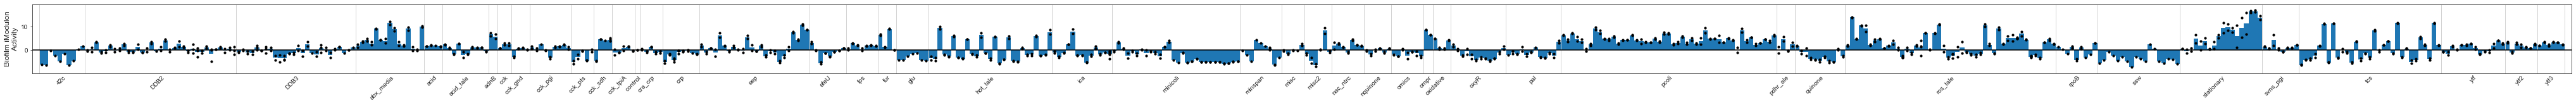

In [288]:
plot_activities(ica_data_1k36, 'Biofilm')
plt.savefig("../images/Biofilm_A.svg")

<AxesSubplot:ylabel='Curli-2 iModulon\nActivity'>

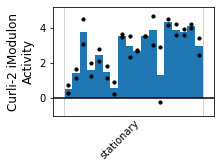

In [124]:
plot_activities(ica_data_1k36_stationary, 'Curli-2')

<AxesSubplot:ylabel='Curli-2 iModulon\nActivity'>

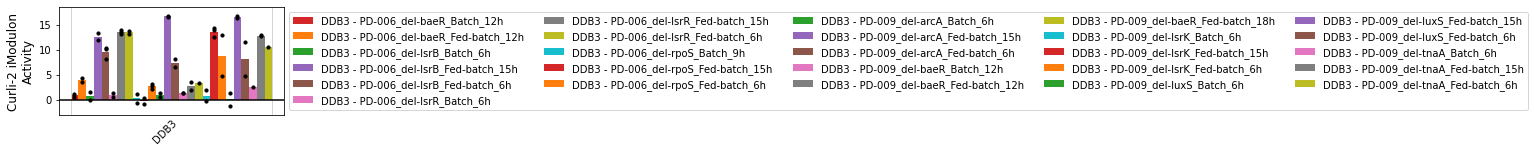

In [135]:
plot_activities(ica_data_1k36, 'Curli-2', projects='DDB3')

In [133]:
ica_data_1k36.sample_table[ica_data_1k36.sample_table.project=='DDB2']

sample_id study project  \
p1k_00934               DDB2__PD-005_BW25113_Batch_6h__1  DDB2    DDB2   
p1k_00935               DDB2__PD-005_BW25113_Batch_6h__2  DDB2    DDB2   
p1k_00936               DDB2__PD-003_BW25113_Batch_9h__1  DDB2    DDB2   
p1k_00937               DDB2__PD-003_BW25113_Batch_9h__2  DDB2    DDB2   
p1k_00938           DDB2__PD-003_BW25113_Fed-batch_6h__1  DDB2    DDB2   
...                                                  ...   ...     ...   
p1k_00998       DDB2__PD-005_MG1655-del-fhuA_Batch_6h__3  DDB2    DDB2   
p1k_00999   DDB2__PD-005_MG1655-del-fhuA_Fed-batch_6h__1  DDB2    DDB2   
p1k_01000   DDB2__PD-005_MG1655-del-fhuA_Fed-batch_6h__2  DDB2    DDB2   
p1k_01001  DDB2__PD-005_MG1655-del-fhuA_Fed-batch_15h__1  DDB2    DDB2   
p1k_01002  DDB2__PD-005_MG1655-del-fhuA_Fed-batch_15h__2  DDB2    DDB2   

                                      condition  rep_id  \
p1k_00934               PD-005_BW25113_Batch_6h       1   
p1k_00935               PD-005_BW25113_Batch_6h       2   
p1k_00936               PD-003_BW25113_Batch_9h       1   
p1k_00937               PD-003_BW25113_Batch_9h       2   
p1k_00938           PD-003_BW25113_Fed-batch_6h       1   
...                                         ...     ...   
p1k_00998       PD-005_MG1655-del-fhuA_Batch_6h       3   
p1k_00999   PD-005_MG1655-del-fhuA_Fed-batch_6h       1   
p1k_01000   PD-005_MG1655-del-fhuA_Fed-batch_6h       2   
p1k_01001  PD-005_MG1655-del-fhuA_Fed-batch_15h       1   
p1k_01002  PD-005_MG1655-del-fhuA_Fed-batch_15h       2   

                              Strain Description   Strain Culture Type  \
p1k_00934               Escherichia coli BW25113  BW25113        Batch   
p1k_00935               Escherichia coli BW25113  BW25113        Batch   
p1k_00936               Escherichia coli BW25113  BW25113        Batch   
p1k_00937               Escherichia coli BW25113  BW25113        Batch   
p1k_00938               Escherichia coli BW25113  BW25113    Fed-batch   
...                                          ...      ...          ...   
p1k_00998  Escherichia coli K-12 MG1655 del_fhuA   MG1655        Batch   
p1k_00999  Escherichia coli K-12 MG1655 del_fhuA   MG1655    Fed-batch   
p1k_01000  Escherichia coli K-12 MG1655 del_fhuA   MG1655    Fed-batch   
p1k_01001  Escherichia coli K-12 MG1655 del_fhuA   MG1655    Fed-batch   
p1k_01002  Escherichia coli K-12 MG1655 del_fhuA   MG1655    Fed-batch   

          Evolved Sample Base Media  ...                   contact  \
p1k_00934             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_00935             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_00936             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_00937             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_00938             No   Medium C  ...  sursud@biosustain.dtu.dk   
...                  ...        ...  ...                       ...   
p1k_00998             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_00999             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_01000             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_01001             No   Medium C  ...  sursud@biosustain.dtu.dk   
p1k_01002             No   Medium C  ...  sursud@biosustain.dtu.dk   

                   creator passed_fastqc passed_pct_reads_mapped  \
p1k_00934  Suresh Sudarsan          True                    True   
p1k_00935  Suresh Sudarsan          True                    True   
p1k_00936  Suresh Sudarsan          True                    True   
p1k_00937  Suresh Sudarsan          True                    True   
p1k_00938  Suresh Sudarsan          True                    True   
...                    ...           ...                     ...   
p1k_00998  Suresh Sudarsan          True                    True   
p1k_00999  Suresh Sudarsan          True                    True   
p1k_01000  Suresh Sudarsan          True                    True   
p1k_01001  Suresh Sudarsan          Tru

<AxesSubplot:ylabel='Curli-2 iModulon\nActivity'>

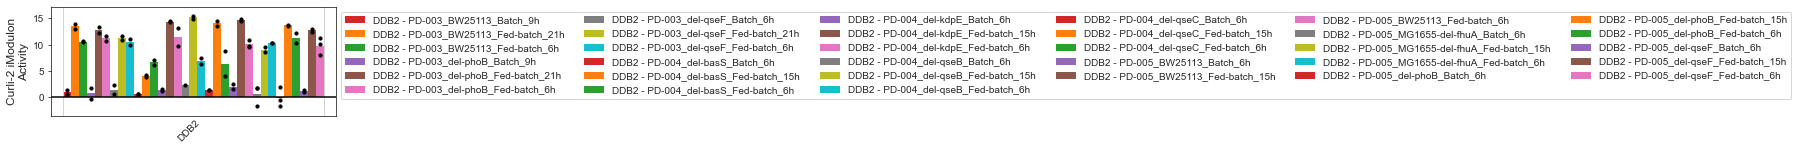

In [270]:
plot_activities(ica_data_1k36, 'Curli-2', projects='DDB2')

entire sample:  0.48 7.881869341440443e-62
0.16 0.3509118999881672


<AxesSubplot:xlabel='Curli-1 activity', ylabel='Curli-2 activity'>

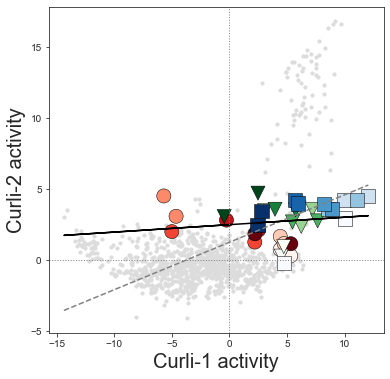

In [268]:
_plot_activities_R2(ica_data_1k36,  'Curli-1', 'Curli-2', highlights=[])

entire sample:  0.19 1.3446702420414452e-10
0.57 0.0002472941117867982


<AxesSubplot:xlabel='alaE activity', ylabel='Biofilm activity'>

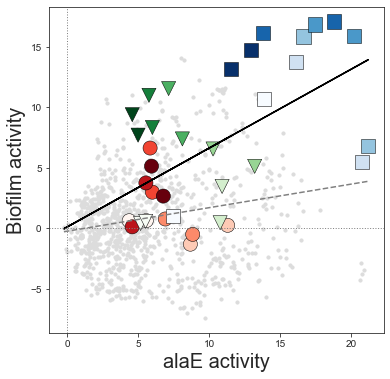

In [274]:
_plot_activities_R2(ica_data_1k36,  'alaE', 'Biofilm', highlights=[])

<AxesSubplot:xlabel='Curli-1 iModulon Activity', ylabel='Curli-2 iModulon Activity'>

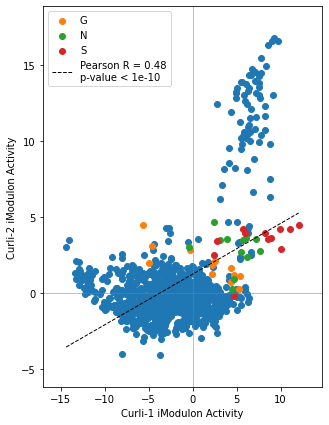

In [131]:
compare_activities(ica_data_1k36, 'Curli-1', 'Curli-2', groups=group_dict.med.to_dict())

<AxesSubplot:xlabel='b1042 Expression', ylabel='b1041 Expression'>

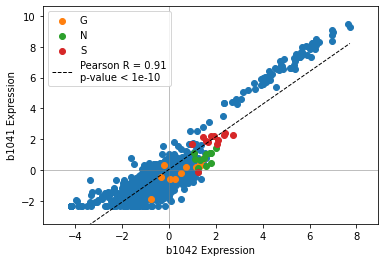

In [23]:
compare_expression(ica_data_1k36,gene2id('csgA'),gene2id('csgB'),
                  groups=group_dict.med.to_dict())

<AxesSubplot:xlabel='b1039 Expression', ylabel='b1038 Expression'>

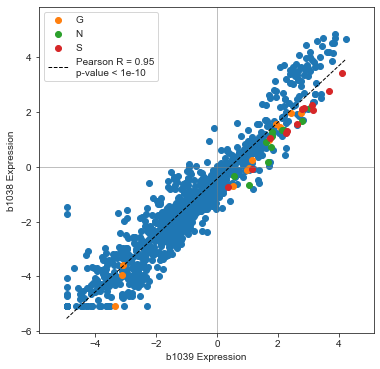

In [272]:
compare_expression(ica_data_1k36,gene2id('csgE'),gene2id('csgF'),
                  groups=group_dict.med.to_dict())

<AxesSubplot:xlabel='b1040 Expression', ylabel='b1041 Expression'>

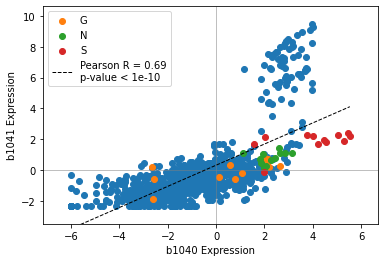

In [21]:
compare_expression(ica_data_1k36,gene2id('csgD'),gene2id('csgB'), groups=group_dict.med.to_dict())

In [224]:
_plot_time_activities(ica_data_1k36,"Curli-1", group_dict)

NameError: name '_plot_time_activities' is not defined

In [59]:
DDB2_samples = ica_data_1k36.sample_table[(ica_data_1k36.sample_table.project=='DDB2') | (ica_data_1k36.sample_table.project=='DDB3')][['sample_id','condition','rep_id']]
for i in DDB2_samples.index:
    DDB2_samples.loc[i,'mode'] = DDB2_samples.loc[i,'condition'].split('_')[2]
    DDB2_samples.loc[i,'time'] = DDB2_samples.loc[i,'condition'].split('_')[3].replace("h","")
    DDB2_samples.loc[i,'mod_time'] = DDB2_samples.loc[i,'mode'] + '_' + DDB2_samples.loc[i,'time']
DDB2_samples.time = DDB2_samples.time.astype('int32')

In [60]:
DDB2_samples

sample_id  \
p1k_00934        DDB2__PD-005_BW25113_Batch_6h__1   
p1k_00935        DDB2__PD-005_BW25113_Batch_6h__2   
p1k_00936        DDB2__PD-003_BW25113_Batch_9h__1   
p1k_00937        DDB2__PD-003_BW25113_Batch_9h__2   
p1k_00938    DDB2__PD-003_BW25113_Fed-batch_6h__1   
...                                           ...   
p1k_01051  DDB3__PD-006_del-rpoS_Fed-batch_15h__2   
p1k_01052       DDB3__PD-009_del-tnaA_Batch_6h__1   
p1k_01053   DDB3__PD-009_del-tnaA_Fed-batch_6h__1   
p1k_01054  DDB3__PD-009_del-tnaA_Fed-batch_15h__1   
p1k_01055  DDB3__PD-009_del-tnaA_Fed-batch_15h__2   

                               condition  rep_id       mode  time  \
p1k_00934        PD-005_BW25113_Batch_6h       1      Batch     6   
p1k_00935        PD-005_BW25113_Batch_6h       2      Batch     6   
p1k_00936        PD-003_BW25113_Batch_9h       1      Batch     9   
p1k_00937        PD-003_BW25113_Batch_9h       2      Batch     9   
p1k_00938    PD-003_BW25113_Fed-batch_6h       1  Fed-batch     6   
...                                  ...     ...        ...   ...   
p1k_01051  PD-006_del-rpoS_Fed-batch_15h       2  Fed-batch    15   
p1k_01052       PD-009_del-tnaA_Batch_6h       1      Batch     6   
p1k_01053   PD-009_del-tnaA_Fed-batch_6h       1  Fed-batch     6   
p1k_01054  PD-009_del-tnaA_Fed-batch_15h       1  Fed-batch    15   
p1k_01055  PD-009_del-tnaA_Fed-batch_15h       2  Fed-batch    15   

               mod_time  
p1k_00934       Batch_6  
p1k_00935       Batch_6  
p1k_00936       Batch_9  
p1k_00937       Batch_9  
p1k_00938   Fed-batch_6  
...                 ...  
p1k_01051  Fed-batch_15  
p1k_01052       Batch_6  
p1k_01053   Fed-batch_6  
p1k_01054  Fed-batch_15  
p1k_01055  Fed-batch_15  

[122 rows x 6 columns]

<AxesSubplot:xlabel='b1040 Expression', ylabel='b1041 Expression'>

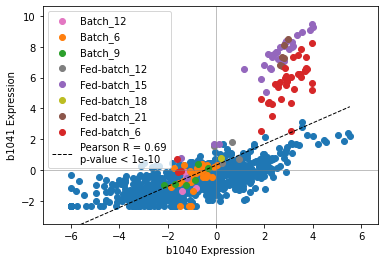

In [61]:
compare_expression(ica_data_1k36,gene2id('csgD'),gene2id('csgB'), groups=DDB2_samples.mod_time.to_dict())

<AxesSubplot:xlabel='RpoS iModulon Activity', ylabel='Curli-1 iModulon Activity'>

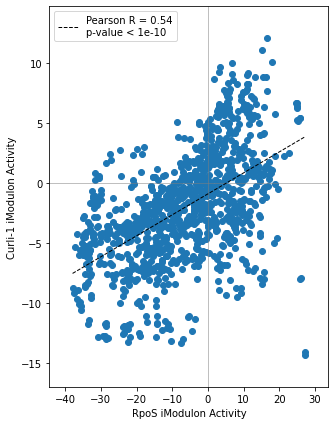

In [87]:
compare_activities(ica_data_1k36,'RpoS','Curli-1')

## Cellulose

In [98]:
ica_data_1k36.view_imodulon(pol_iMs[2]).sort_values(by='gene_weight', ascending=False).head(10)

gene_weight gene_name   synonyms  \
b3534     0.104911      bcsQ  bcsQ;yhjQ   
b3661     0.102668      nlpA       nlpA   
b0287     0.099948      yagU       yagU   
b3535     0.098528      yhjR       yhjR   
b0946     0.095017      zapC  zapC;ycbW   
b3537     0.092089      bcsF  bcsF;yhjT   
b4657     0.091205      yjhZ        NaN   
b4555     0.089064      yicS       yicS   
b3536     0.087699      bcsE  bcsE;yhjS   
b3922     0.087028      yiiS       yiiS   

                                            gene_product  \
b3534                     cellulose biosynthesis protein   
b3661                                     lipoprotein-28   
b0287  inner membrane protein that contributes to aci...   
b3535                        PF10945 family protein YhjR   
b0946                         cell division protein ZapC   
b3537       putative cellulose biosynthesis protein BcsF   
b4657  KpLE2 phage-like element%3B putative acetyltra...   
b4555                       uncharacterized protein YicS   
b3536                      c-di-GMP-binding protein BcsE   
b3922              DUF406 domain-containing protein YiiS   

                                                     COG  \
b3534  Cell cycle control, cell division, chromosome ...   
b3661             Cell wall/membrane/envelope biogenesis   
b0287                                   Function unknown   
b3535                                   Function unknown   
b0946  Cell cycle control, cell division, chromosome ...   
b3537                                   Function unknown   
b4657    Translation, ribosomal structure and biogenesis   
b4555                                  No COG annotation   
b3536                                   Function unknown   
b3922                                   Function unknown   

                     regulator uniprot    start      end strand  ...  y_ome  \
b3534                      NaN     NaN  3695233  3695985      -  ...  False   
b3661     ppGpp,CsgD,GlaR,gcvB  P04846  3839175  3839993      -  ...   True   
b0287  YfeC,YfeD,ppGpp,Lrp,Nac  P0AAA1   302991   303605      +  ...   True   
b3535                 RpoD,Lrp  P0ADJ3  3695997  3696185      -  ...   True   
b0946                      NaN  P75862  1005952  1006494      +  ...  False   
b3537                     RpoD  P0ADJ5  3698026  3698217      +  ...   True   
b4657                      NaN     NaN  4534430  4534675      -  ...  False   
b4555                      NaN  Q2M7X4  3840215  3840508      +  ...   True   
b3536               RpoD,ppGpp  P37657  3696458  3698029      +  ...  False   
b3922     YeiE,RpoE,YdeO,ppGpp  P32162  4112967  4113266      +  ...   True   

       k_eff schmidt_prot_med heckmann_prot_med proteomics   p1k  \
b3534  False              NaN               NaN      False  True   
b3661   True           1079.0             629.0       True  True   
b0287   True            626.0             361.0       True  True   
b3535  False              NaN               NaN      False  True   
b0946  False              NaN               NaN      False  True   
b3537  False              NaN               NaN      False  True   
b4657  False              NaN               NaN      False  True   
b4555  False              0.0               NaN       True  True   
b3536  False              NaN               NaN      False  True   
b3922  False            367.5               NaN       True  True   

      p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  in_iM  
b3534         4.809333           3.998454        0.891821   True  
b3661         8.105649           7.559412        1.074537   True  
b0287         8.343247           7.574807        1.409900   True  
b3535         6.345232           6.252615        1.125266   True  
b0946         6.346988           6.606713        0.793531   True  
b3537         6.076168           5.227361        1.071350   True  
b4657         1.419620           1.804620        0.891298   True  
b4555         3.977730           3.955949        1.24886

In [392]:
ica_data_1k36.view_imodulon('Cellulose').to_csv("../cellulose.csv")

In [161]:
'bcsG' in ica_data_1k36.view_imodulon(pol_iMs[2]).gene_name.to_list()

True

In [150]:
ica_data_1k36.view_imodulon(pol_iMs[2])

gene_weight gene_name synonyms  \
b0034     0.056712      caiF     caiF   
b0076     0.044678      leuO     leuO   
b0287     0.099948      yagU     yagU   
b0318     0.046339      yahD     yahD   
b0328     0.054534      yahN     yahN   
...            ...       ...      ...   
b4522     0.061134      ymiA     ymiA   
b4523     0.071805      yciX     yciX   
b4555     0.089064      yicS     yicS   
b4621    -0.048822      yjbS     yjbS   
b4657     0.091205      yjhZ      NaN   

                                            gene_product  \
b0034         DNA-binding transcriptional activator CaiF   
b0076    DNA-binding transcriptional dual regulator LeuO   
b0287  inner membrane protein that contributes to aci...   
b0318             ankyrin repeat-containing protein YahD   
b0328                       putative amino acid exporter   
...                                                  ...   
b4522                       uncharacterized protein YmiA   
b4523                       uncharacterized protein YciX   
b4555                       uncharacterized protein YicS   
b4621                       uncharacterized protein YjbS   
b4657  KpLE2 phage-like element%3B putative acetyltra...   

                                                   COG  \
b0034                                    Transcription   
b0076                                    Transcription   
b0287                                 Function unknown   
b0318                                 Function unknown   
b0328              Amino acid transport and metabolism   
...                                                ...   
b4522                                No COG annotation   
b4523                                No COG annotation   
b4555                                No COG annotation   
b4621                                No COG annotation   
b4657  Translation, ribosomal structure and biogenesis   

                                               regulator uniprot    start  \
b0034                    RpoD,YdcN,H-NS,Fnr,Crp,NarL,Nac  P0AE58    34300   
b0076  RpoD,StpA,LeuO,LrhA,RcsB-BglJ,SlyA,H-NS,Lrp,Na...  P10151    84368   
b0287                            YfeC,YfeD,ppGpp,Lrp,Nac  P0AAA1   302991   
b0318                                                NaN  P77736   335280   
b0328                                                Crp  P75693   345666   
...                                                  ...     ...      ...   
b4522                                          RpoD,YjjQ  P0CB62  1335124   
b4523                                          RpoD,YjjQ  P58094  1335291   
b4555                                                NaN  Q2M7X4  3840215   
b4621                                                NaN  P58036  4268809   
b4657                                                NaN     NaN  4534430   

           end strand  ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b0034    34695      +  ...  False  False              NaN               NaN   
b0076    85312      +  ...  False  False              NaN               NaN   
b0287   303605      +  ...   True   True            626.0             361.0   
b0318   335885      +  ...   True  False              NaN               NaN   
b0328   346337      -  ...   True  False              NaN               NaN   
...        ...    ...  ...    ...    ...              ...               ...   
b4522  1335288      +  ...   True  False              NaN               NaN   
b4523  1335458      +  ...   True  False              NaN               NaN   
b4555  3840508      +  ...   True  False              0.0               NaN   
b4621  4269012      -  ...   True  False              NaN               NaN   
b4657  4534675      -  ...  False  False              NaN               NaN   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b0034      False  True         5.725698           4.851363        1.313784   
b0076      False  True         2.694798           2.963269        

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


<AxesSubplot:xlabel='Gene Start', ylabel='Cellulose Gene Weight'>

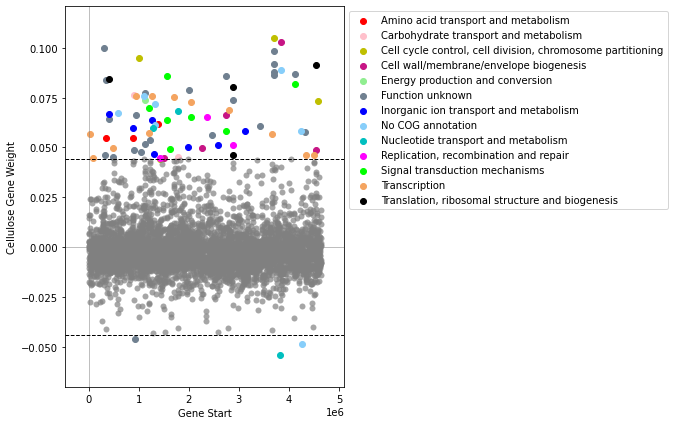

In [152]:
plot_gene_weights(ica_data_1k36,pol_iMs[2])

<AxesSubplot:ylabel='Cellulose iModulon\nActivity'>

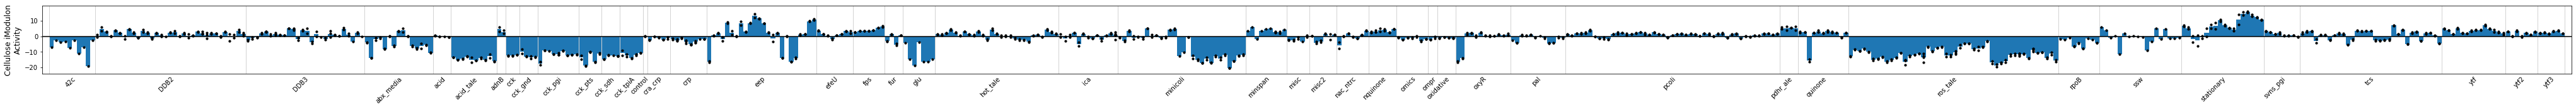

In [71]:
plot_activities(ica_data_1k36,pol_iMs[2])

<AxesSubplot:ylabel='Cellulose iModulon\nActivity'>

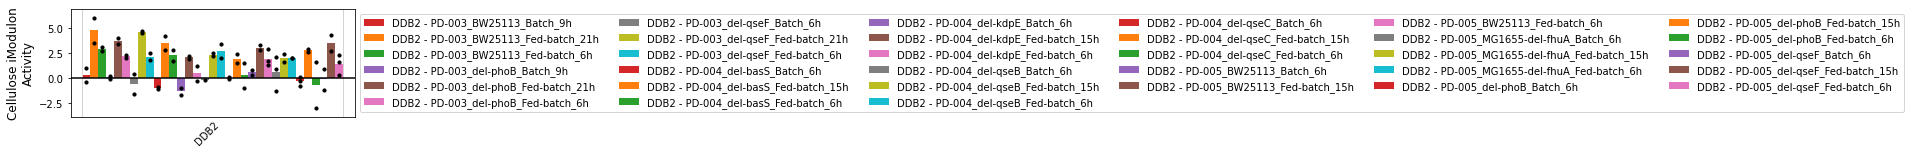

In [146]:
plot_activities(ica_data_1k36, 'Cellulose', projects='DDB2')

## Curli vs Cellulose

entire sample:  0.59 4.0840187567843104e-101
0.87 5.31034696891521e-12


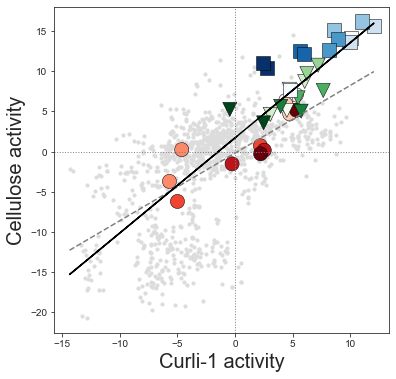

In [221]:
fig = _plot_activities_R2(ica_data_1k36,"Curli-1","Cellulose",[])
fig.get_figure().savefig("../images/Cellulose_Curli.svg")

entire sample:  0.35 1.66456764204702e-31
0.47 0.004156848120429124


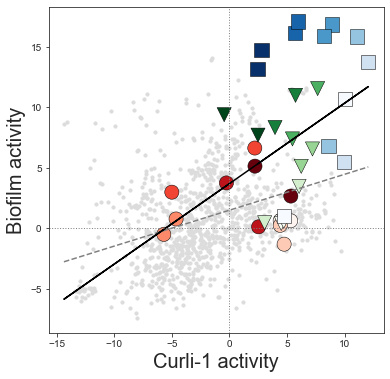

In [250]:
fig = _plot_activities_R2(ica_data_1k36,"Curli-1","Biofilm",[])
fig.get_figure().savefig("../images/Cellulose_biofilm.svg")

entire sample:  0.17 1.6695842528544908e-08
0.63 4.0211160689755385e-05


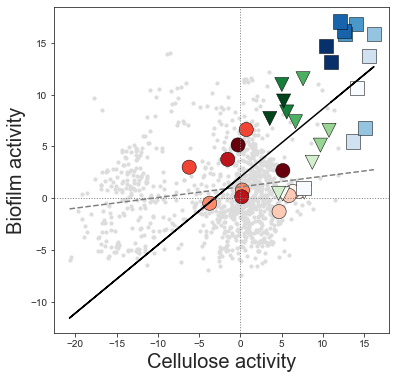

In [262]:
fig = _plot_activities_R2(ica_data_1k36,"Cellulose","Biofilm",[])
fig.get_figure().savefig("../images/Cellulose_biofilm.svg")

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



<AxesSubplot:xlabel='Gene Start', ylabel='Curli-1 Gene Weight'>

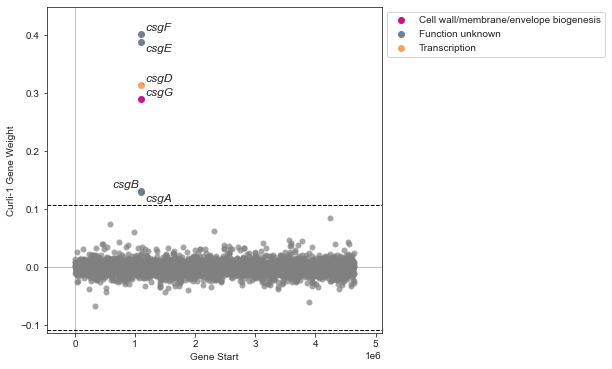

In [222]:
plot_gene_weights(ica_data_1k36, 'Curli-1')

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



<AxesSubplot:xlabel='Gene Start', ylabel='Cellulose Gene Weight'>

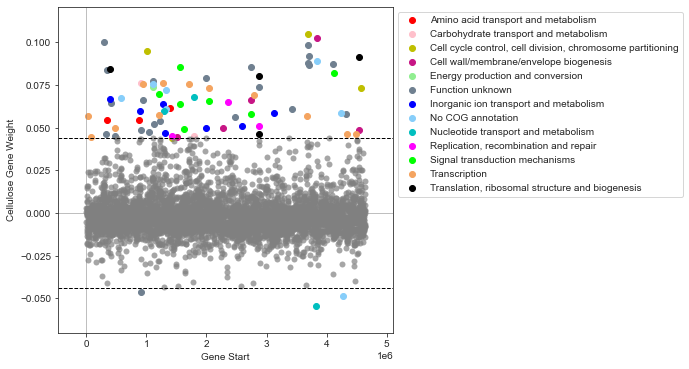

In [223]:
plot_gene_weights(ica_data_1k36, 'Cellulose')

## Biofilm

In [260]:
ica_data_1k36.view_imodulon('Biofilm')

gene_weight gene_name   synonyms  \
b1164     0.305310      ycgZ       ycgZ   
b1165     0.354137      ymgA       ymgA   
b1166     0.391557      ariR  ariR;ymgB   
b1167     0.457286      ymgC       ymgC   
b1168     0.111372      pdeG  pdeG;ycgG   

                                            gene_product  \
b1164  putative two-component system connector protei...   
b1165  putative two-component system connector protei...   
b1166  regulator of acid resistance%2C influenced by ...   
b1167                                       protein YmgC   
b1168           putative c-di-GMP phosphodiesterase PdeG   

                                  COG                       regulator uniprot  \
b1164                Function unknown       RpoD,RpoS,BluR,ppGpp,MarA  P75991   
b1165                Function unknown       RpoD,RpoS,BluR,ppGpp,MarA  P75992   
b1166                   Transcription  RpoD,RpoS,BluR,ppGpp,CysB,MarA  P75993   
b1167               No COG annotation       RpoD,RpoS,ppGpp,BluR,MarA  P75994   
b1168  Signal transduction mechanisms                       YfeD,GlaR  P75995   

         start      end strand  ... y_ome  k_eff schmidt_prot_med  \
b1164  1215789  1216025      +  ...  True  False              NaN   
b1165  1216068  1216340      +  ...  True  False              NaN   
b1166  1216369  1216635      +  ...  True  False              NaN   
b1167  1216748  1216996      +  ...  True  False              NaN   
b1168  1217328  1218851      +  ...  True  False              NaN   

      heckmann_prot_med proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm  \
b1164               NaN      False  True         4.616867           4.836060   
b1165               NaN      False  True         4.218277           4.430020   
b1166               NaN      False  True         4.410449           4.057825   
b1167               NaN      False  True         3.047523           3.492918   
b1168               NaN      False  True         1.586179           1.454547   

      p1k_mad_log_tpm  in_iM  
b1164        1.598038   True  
b1165        1.672008   True  
b1166        1.659982   True  
b1167        1.823934   True  
b1168        0.709868   True  

[5 rows x 27 columns]

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Biofilm iM activity'}, xlabel='Time', ylabel='iM activity'>)

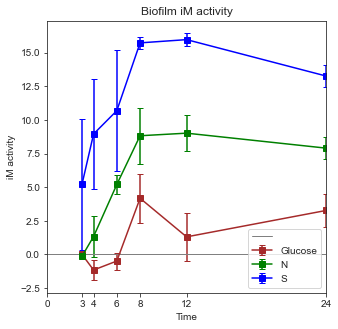

In [261]:
_plot_time_activities(ica_data_1k36_stationary, 'Biofilm', group_dict)

<AxesSubplot:xlabel='Curli-1 iModulon Activity', ylabel='Biofilm iModulon Activity'>

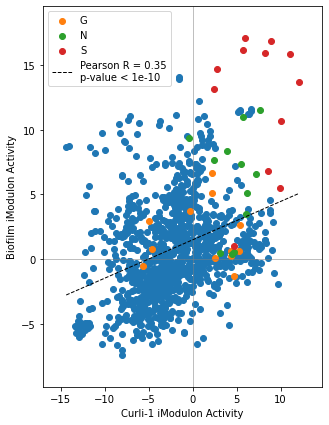

In [95]:
compare_activities(ica_data_1k36, 'Curli-1', 'Biofilm', groups = group_dict.med.to_dict())

<AxesSubplot:xlabel='Cellulose iModulon Activity', ylabel='Biofilm iModulon Activity'>

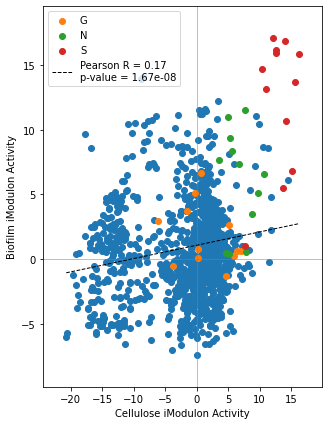

In [94]:
compare_activities(ica_data_1k36, 'Cellulose', 'Biofilm', groups = group_dict.med.to_dict())

In [119]:
round(df_rec_var['Cellulose']*100, 2)

0.42

In [120]:
round(df_rec_var['Biofilm']*100, 2)

0.41

In [121]:
round(df_rec_var['Curli-1']*100 + df_rec_var['Curli-2']*100, 2)

0.3

# Toxin-antitoxin

<AxesSubplot:ylabel='hokA iModulon\nActivity'>

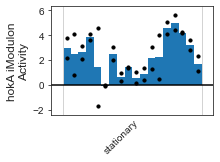

In [246]:
plot_activities(ica_data_1k36_stationary, "hokA")

<AxesSubplot:ylabel='12 iModulon\nActivity'>

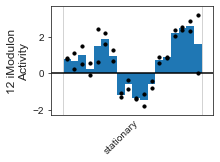

In [249]:
plot_activities(ica_data_1k36_stationary, 12)

In [248]:
ica_data_1k36.view_imodulon(12)

gene_weight gene_name   synonyms  \
b0057    -0.087258      yabQ        NaN   
b0327    -0.115157      yahM       yahM   
b0991     0.092218      ymcE   ymcE;sfa   
b1331    -0.188833    insH-4      insH4   
b1420     0.121524      mokB       mokB   
b1826     0.085924      mgrB  mgrB;yobG   
b2982    -0.147359    insH-9      insH9   
b3107     0.104120      yhaL       yhaL   
b3638     0.127906      yicR       yicR   
b4410    -0.109727      ecnA       ecnA   
b4522     0.100362      ymiA       ymiA   
b4542     0.195600      yohO       yohO   
b4686     0.101344      yshB       yshB   
b4711    -0.192613    insH21        NaN   
b4735     0.136009      ybgU        NaN   

                                            gene_product  \
b0057                                       protein YabQ   
b0327                       uncharacterized protein YahM   
b0991                                       protein YmcE   
b1331                IS5 transposase and trans-activator   
b1420                   putative regulatory protein MokB   
b1826                              PhoQ kinase inhibitor   
b2982                IS5 transposase and trans-activator   
b3107                       uncharacterized protein YhaL   
b3638       RadC-like JAB domain-containing protein YicR   
b4410  entericidin A lipoprotein%2C antidote to enter...   
b4522                       uncharacterized protein YmiA   
b4542                        UPF0387 family protein YohO   
b4686                       uncharacterized protein YshB   
b4711                IS5 transposase and trans-activator   
b4735                                       protein YbgU   

                                         COG  regulator        uniprot  \
b0057                      No COG annotation        Lrp  UPI000013A010   
b0327                      No COG annotation        NaN         P75692   
b0991                       Function unknown        NaN         P0AAA5   
b1331  Replication, recombination and repair        NaN     A0A385XJE6   
b1420                      No COG annotation   sokB,Crp         P76096   
b1826                       Function unknown       PhoP         P64512   
b2982  Replication, recombination and repair        NaN     A0A385XJE6   
b3107                      No COG annotation       YhaJ         P42625   
b3638    Amino acid transport and metabolism        NaN         P25531   
b4410                       Function unknown        Nac         P0ADB4   
b4522                      No COG annotation  RpoD,YjjQ         P0CB62   
b4542                      No COG annotation        Nac         Q2EES6   
b4686                      No COG annotation        NaN         C1P620   
b4711  Replication, recombination and repair        NaN  UPI0000000969   
b4735                      No COG annotation        NaN  UPI0001A5C00D   

         start      end strand  ...  y_ome  k_eff schmidt_prot_med  \
b0057    59121    59279      +  ...   True  False              NaN   
b0327   345404   345649      +  ...   True  False              NaN   
b0991  1051847  1052077      +  ...   True  False              NaN   
b1331  1396076  1397092      +  ...  False  False              NaN   
b1420  1491962  1492129      -  ...   True  False              NaN   
b1826  1908623  1908766      -  ...  False  False              NaN   
b2982  3130178  3131194      +  ...  False  False              NaN   
b3107  3255043  3255207      +  ...   True  False              NaN   
b3638  3811891  3812559      -  ...   True  False              NaN   
b4410  4376317  4376442      +  ...  False  False              NaN   
b4522  1335124  1335288      +  ...   True  False              NaN   
b4542  2215657  2215764      +  ...   True  False              NaN   
b4686  4053647  4053757      -  ...   True  False              NaN   
b4711  1299531  1300547      +  ...  False  False              NaN   
b4735   754674   754781      -  ...  False  False              NaN   

      heckmann_prot_med proteomics   p1k p1k_ctrl_l

In [ ]:
ica_data_1k36.view_imodulon(12)

# SlyA

<AxesSubplot:xlabel='Quorum Sensing iModulon Activity', ylabel='SlyA iModulon Activity'>

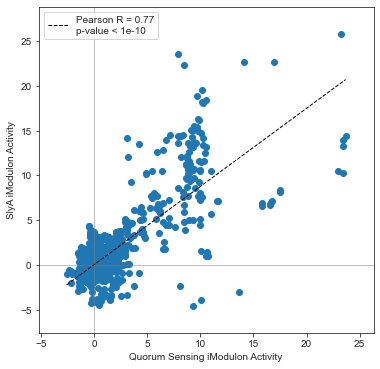

In [252]:
compare_activities(ica_data_1k36,'Quorum Sensing','SlyA')

<AxesSubplot:xlabel='Quorum Sensing iModulon Activity', ylabel='SlyA iModulon Activity'>

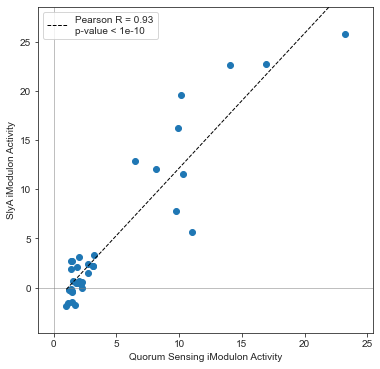

In [253]:
compare_activities(ica_data_1k36_stationary,'Quorum Sensing','SlyA')

In [256]:
ica_data_1k36.view_imodulon('SlyA')

gene_weight gene_name   synonyms  \
b4302     0.131867      sgcA  sgcA;yjhL   
b4303     0.187429      sgcQ  sgcQ;yjhM   
b4304     0.178653      sgcC  sgcC;yjhN   
b4305     0.158575      sgcX  sgcX;yjhO   
b4565     0.315788      sgcB       sgcB   

                                            gene_product  \
b4302             putative PTS enzyme IIA component SgcA   
b4303  KpLE2 phage-like element%3B putative nucleosid...   
b4304             putative PTS enzyme IIC component SgcC   
b4305  KpLE2 phage-like element%3B putative endogluca...   
b4565             putative PTS enzyme IIB component SgcB   

                                         COG      regulator uniprot    start  \
b4302  Carbohydrate transport and metabolism       Crp,SlyA  P39363  4527549   
b4303                       Function unknown       Crp,SlyA  P39364  4528111   
b4304  Carbohydrate transport and metabolism  Crp,SlyA,GlaR  P39365  4528930   
b4305  Carbohydrate transport and metabolism       Crp,SlyA  P39366  4530530   
b4565  Carbohydrate transport and metabolism       Crp,SlyA  P58035  4530255   

           end strand  ... y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b4302  4527980      -  ...  True  False              NaN               NaN   
b4303  4528917      -  ...  True  False              1.0               NaN   
b4304  4530243      -  ...  True  False              NaN               NaN   
b4305  4531651      -  ...  True  False              5.0               NaN   
b4565  4530533      -  ...  True  False              NaN               NaN   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b4302      False  True         4.049249           3.701362        0.781555   
b4303       True  True         2.173873           2.812029        0.582868   
b4304      False  True         2.126537           2.394817        0.639868   
b4305       True  True         1.969921           2.215832        0.851619   
b4565      False  True         1.343749           1.931621        0.962446   

       in_iM  
b4302   True  
b4303   True  
b4304   True  
b4305   True  
b4565   True  

[5 rows x 27 columns]

In [258]:
ica_data_1k36.view_imodulon('Copper')

gene_weight gene_name             synonyms  \
b0123     0.084222      cueO            cueO;yacK   
b0484     0.105305      copA  copA;atcU;f834;ybaR   
b0570     0.166186      cusS            cusS;ybcZ   
b0571     0.181303      cusR            cusR;ylcA   
b0572     0.497414      cusC       cusC;ibeB;ylcB   
b0573     0.512061      cusF       cusF;cusX;ylcC   
b0574     0.461859      cusB            cusB;ylcD   
b0575     0.343939      cusA            cusA;ybdE   
b0576     0.060278      pheP                 pheP   
b1968     0.050989      hprS            hprS;yedV   
b1969     0.048316      hprR            hprR;yedW   

                                            gene_product  \
b0123  cuprous oxidase/multicopper oxidase with role ...   
b0484                      Cu(+) exporting P-type ATPase   
b0570                      sensory histidine kinase CusS   
b0571         DNA-binding transcriptional activator CusR   
b0572  copper/silver export system outer membrane cha...   
b0573  copper/silver export system periplasmic bindin...   
b0574  copper/silver export system membrane fusion pr...   
b0575           copper/silver export system RND permease   
b0576                  phenylalanine:H(+) symporter PheP   
b1968                      sensory histidine kinase HprS   
b1969    DNA-binding transcriptional dual regulator HprR   

                                                     COG  \
b0123  Secondary metabolites biosynthesis, transport,...   
b0484             Inorganic ion transport and metabolism   
b0570                     Signal transduction mechanisms   
b0571                                      Transcription   
b0572             Cell wall/membrane/envelope biogenesis   
b0573                                   Function unknown   
b0574             Cell wall/membrane/envelope biogenesis   
b0575             Inorganic ion transport and metabolism   
b0576             Inorganic ion transport and metabolism   
b1968                     Signal transduction mechanisms   
b1969                                      Transcription   

                      regulator uniprot    start      end strand  ...  y_ome  \
b0123                 ryhB,CueR  P36649   137083   138633      +  ...  False   
b0484            RpoD,OmpR,CueR  Q59385   508875   511379      -  ...  False   
b0570       RpoD,PhoB,CusR,HprR  P77485   593328   594770      -  ...  False   
b0571       RpoD,PhoB,CusR,HprR  P0ACZ8   594760   595443      -  ...  False   
b0572  RpoD,YciT,PhoB,CusR,HprR  P77211   595600   596973      +  ...  False   
b0573       RpoD,PhoB,CusR,HprR  P77214   597131   597463      +  ...  False   
b0574       RpoD,PhoB,CusR,HprR  P77239   597479   598702      +  ...  False   
b0575       RpoD,PhoB,CusR,HprR  P38054   598714   601857      +  ...  False   
b0576           RpoD,YcjW,ppGpp  P24207   601959   603335      +  ...  False   
b1968                       NaN  P76339  2036794  2038152      -  ...  False   
b1969                       Nac  P76340  2038152  2038823      -  ...  False   

       k_eff schmidt_prot_med heckmann_prot_med proteomics   p1k  \
b0123   True            690.5             797.0       True  True   
b0484   True           3104.5             986.0       True  True   
b0570   True            207.5             132.0       True  True   
b0571   True            523.0             297.0       True  True   
b0572   True            984.0            1035.0       True  True   
b0573   True          14031.0             943.0       True  True   
b0574   True           1459.0            1249.0       True  True   
b0575   True            307.5             581.0       True  True   
b0576   True              9.5             114.0       True  True   
b1968  False              4.0               NaN       True  True   
b1969  False              NaN               NaN      False  True   

      p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  in_iM  
b0123         7.500609           6.926969        1.220091   True  
b0484         7.

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



<AxesSubplot:xlabel='Gene Start', ylabel='SlyA Gene Weight'>

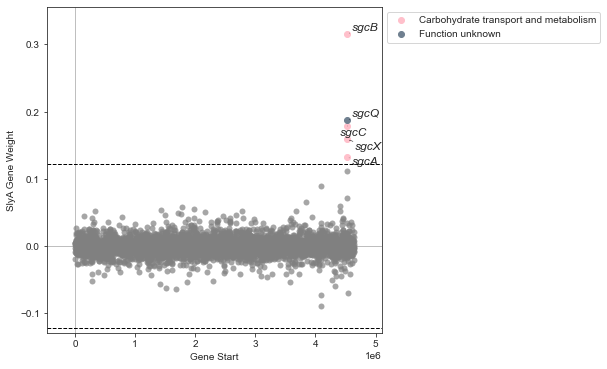

In [257]:
plot_gene_weights(ica_data_1k36, 'SlyA')

In [255]:
ica_data_1k36.view_imodulon('Quorum Sensing')

gene_weight gene_name       synonyms  \
b1511     0.343237      lsrK      lsrK;ydeV   
b1512    -0.216127      lsrR      lsrR;ydeW   
b1513     0.335056      lsrA  lsrA;ego;ydeX   
b1514     0.301176      lsrC      lsrC;ydeY   
b1515     0.317921      lsrD      lsrD;ydeZ   
b1516     0.414260      lsrB      lsrB;yneA   
b1517     0.229857      lsrF      lsrF;yneB   
b1518     0.222474      lsrG      lsrG;yneC   
b1519     0.076268       tam       tam;yneD   

                                            gene_product  \
b1511                               autoinducer-2 kinase   
b1512         DNA-binding transcriptional repressor LsrR   
b1513  Autoinducer-2 ABC transporter ATP binding subunit   
b1514  Autoinducer-2 ABC transporter membrane subunit...   
b1515  Autoinducer-2 ABC transporter membrane subunit...   
b1516  Autoinducer-2 ABC transporter periplasmic bind...   
b1517    3-hydroxy-2%2C4-pentadione 5-phosphate thiolase   
b1518  (4S)-4-hydroxy-5-phosphonooxypentane-2%2C3-dio...   
b1519                trans-aconitate 2-methyltransferase   

                                                     COG  \
b1511              Carbohydrate transport and metabolism   
b1512                                      Transcription   
b1513              Carbohydrate transport and metabolism   
b1514  Intracellular trafficking, secretion, and vesi...   
b1515  Intracellular trafficking, secretion, and vesi...   
b1516              Carbohydrate transport and metabolism   
b1517                  Coenzyme transport and metabolism   
b1518                                   Function unknown   
b1519    Translation, ribosomal structure and biogenesis   

                      regulator uniprot    start      end strand  ...  y_ome  \
b1511             RpoD,Crp,LsrR  P77432  1598617  1600209      -  ...  False   
b1512             RpoD,Crp,LsrR  P76141  1600288  1601241      -  ...  False   
b1513             RpoS,Crp,LsrR  P77257  1601490  1603025      +  ...  False   
b1514             RpoS,Crp,LsrR  P77672  1603019  1604047      +  ...  False   
b1515        YcjW,RpoS,Crp,LsrR  P0AFS1  1604047  1605039      +  ...  False   
b1516             RpoS,Crp,LsrR  P76142  1605051  1606073      +  ...  False   
b1517             RpoS,Crp,LsrR  P76143  1606100  1606975      +  ...  False   
b1518        RpoS,Crp,LsrR,GlaR  P64461  1606999  1607289      +  ...  False   
b1519  RpoS,Crp,ppGpp,LsrR,GlaR  P76145  1607346  1608104      +  ...  False   

       k_eff schmidt_prot_med heckmann_prot_med proteomics   p1k  \
b1511  False              9.5               NaN       True  True   
b1512  False              NaN               NaN      False  True   
b1513  False              0.0               NaN       True  True   
b1514  False              NaN               NaN      False  True   
b1515  False              NaN               NaN      False  True   
b1516  False            132.5               NaN       True  True   
b1517  False            134.5               NaN       True  True   
b1518  False              5.0               NaN       True  True   
b1519  False            175.0               NaN       True  True   

      p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  in_iM  
b1511         3.134032           3.348775        0.553182   True  
b1512         3.730493           4.211101        0.592108   True  
b1513         1.804921           1.746169        0.731717   True  
b1514         1.539432           1.688594        0.667490   True  
b1515         0.874106           1.699827        0.631408   True  
b1516         2.539532           2.600328        0.697642   True  
b1517         2.844984           3.283912        0.735770   True  
b1518         3.925440           3.780506        0.879930   True  
b1519         6.056290           5.061423        1.635873   True  

[9 rows x 27 columns]

entire sample:  0.77 6.629542830178776e-214
0.93 1.6223351006948847e-16


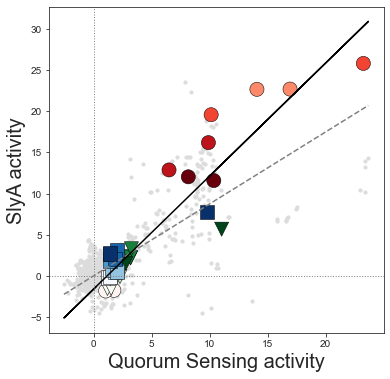

In [254]:
fig = _plot_activities_R2(ica_data_1k36,'Quorum Sensing','SlyA',[])


# Copper

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Copper iM activity'}, xlabel='Time', ylabel='iM activity'>)

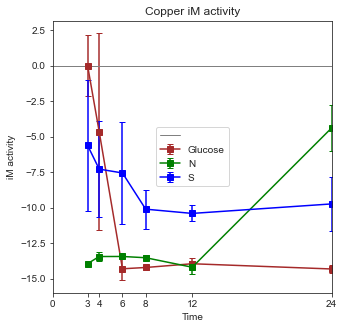

In [259]:
_plot_time_activities(ica_data_1k36_stationary, 'Copper', group_dict)

entire sample:  0.22 6.530883194669494e-13
0.64 2.4099064778390196e-05


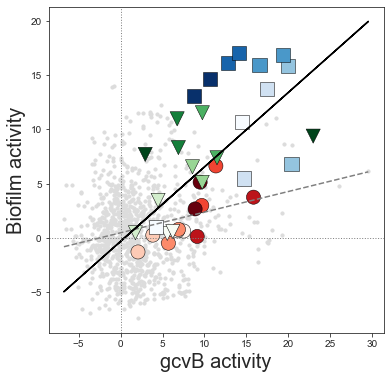

In [263]:
fig = _plot_activities_R2(ica_data_1k36,"gcvB","Biofilm",[])


In [265]:
ica_data_1k36.view_imodulon('gcvB').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name             synonyms  \
b3818     0.149539      yigG                 yigG   
b2851     0.149049      ygeG                 ygeG   
b2849     0.145207      yqeK                 yqeK   
b4586     0.131847      ykfM                 ykfM   
b4621     0.128857      yjbS                 yjbS   
b2850     0.124466      ygeF                 ygeF   
b2650     0.122079      ypjC                 ypjC   
b4047     0.117311      yjbL                 yjbL   
b2855     0.117261      ygeK                  NaN   
b2858     0.105332      ygeN            ygeN;ygeM   
b3504     0.103150      yhiS                 yhiS   
b2649     0.096399      ypjB                  NaN   
b4612     0.095862      yrhD                  NaN   
b1457     0.091746      ydcD                 ydcD   
b4495     0.089923      yedN                  NaN   
b4745     0.088094      yncO                  NaN   
b3443     0.087840      yrhA                 yrhA   
b3889     0.087516      yiiE                 yiiE   
b0501     0.084413      ybbD                 ybbD   
b2852     0.082701      ygeH                 ygeH   
b4660     0.081335      yhiL                 yhiL   
b4038     0.077911      yjbI                 yjbI   
b4257     0.077401      yjgN                 yjgN   
b0499     0.077145      ylbH                 ylbH   
b3596     0.076848      yibG                 yibG   
b3121     0.074047      yhaC                 yhaC   
b3027     0.069799      ygiZ                 ygiZ   
b3442     0.069786      yhhZ                 yhhZ   
b4733     0.068373      ylcJ                  NaN   
b4215     0.068319      ytfI                 ytfI   
b0279     0.067147      yagM                 yagM   
b0218     0.067070      yafU                 yafU   
b2856     0.066069      ygeL            ygeK;ygeL   
b4462     0.065907      ygaQ  ygaQ;ygaR;yqaC;yqaD   
b4682     0.065588      yqcG                 yqcG   
b4205     0.064575      ytfA                 ytfA   
b0558     0.063934      ybcV                 ybcV   
b4615     0.063876      yibV                 yibV   
b4066     0.063652      yjcF                 yjcF   
b4017     0.063452      arpA        arpA;arp;yjaC   
b2625     0.062142      yfjI                 yfjI   
b1160     0.059896      iraM  iraM;elb1;elbA;ycgW   
b4325     0.058523      yjiC                 yjiC   
b3512     0.056904      gadE       gadE;yhiE;yhiT   
b3120     0.056865      yhaB                 yhaB   
b1471     0.056434      yddK                 yddK   
b2269     0.055210      elaD                 elaD   
b0012     0.055158      mbiA                  NaN   
b2345     0.054646      yfdF                 yfdF   
b0326     0.054139      yahL                 yahL   
b0317    -0.055454      yahC                 yahC   
b1751    -0.057759      ydjY                 ydjY   

                                            gene_product  \
b3818                             inner membrane protein   
b2851      TPR repeat-containing putative chaperone YgeG   
b2849                                       protein YqeK   
b4586                       uncharacterized protein YkfM   
b4621                       uncharacterized protein YjbS   
b2850                                       protein YgeF   
b2650             DUF5507 domain-containing protein YpjC   
b4047                       uncharacterized protein YjbL   
b2855  putative DNA-binding transcriptional regulator...   
b2858         putative type III secretion system protein   
b3504              putative uncharacterized protein YhiS   
b2649             DUF5508 domain-containing protein YpjB   
b4612                       uncharacterized protein YrhD   
b1457                       uncharacterized protein YdcD   
b4495  putative type III secreted effector%2C N-termi...   
b4745                                       protein YncO   
b3443              putative uncharacterized protein YrhA   
b3889  putative DNA-binding transcriptional regulator...   
b0501              putative uncharacterized protein YbbD 

In [275]:
ica_data_1k36.view_imodulon('gcvB').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name             synonyms  \
b3818     0.149539      yigG                 yigG   
b2851     0.149049      ygeG                 ygeG   
b2849     0.145207      yqeK                 yqeK   
b4586     0.131847      ykfM                 ykfM   
b4621     0.128857      yjbS                 yjbS   
b2850     0.124466      ygeF                 ygeF   
b2650     0.122079      ypjC                 ypjC   
b4047     0.117311      yjbL                 yjbL   
b2855     0.117261      ygeK                  NaN   
b2858     0.105332      ygeN            ygeN;ygeM   
b3504     0.103150      yhiS                 yhiS   
b2649     0.096399      ypjB                  NaN   
b4612     0.095862      yrhD                  NaN   
b1457     0.091746      ydcD                 ydcD   
b4495     0.089923      yedN                  NaN   
b4745     0.088094      yncO                  NaN   
b3443     0.087840      yrhA                 yrhA   
b3889     0.087516      yiiE                 yiiE   
b0501     0.084413      ybbD                 ybbD   
b2852     0.082701      ygeH                 ygeH   
b4660     0.081335      yhiL                 yhiL   
b4038     0.077911      yjbI                 yjbI   
b4257     0.077401      yjgN                 yjgN   
b0499     0.077145      ylbH                 ylbH   
b3596     0.076848      yibG                 yibG   
b3121     0.074047      yhaC                 yhaC   
b3027     0.069799      ygiZ                 ygiZ   
b3442     0.069786      yhhZ                 yhhZ   
b4733     0.068373      ylcJ                  NaN   
b4215     0.068319      ytfI                 ytfI   
b0279     0.067147      yagM                 yagM   
b0218     0.067070      yafU                 yafU   
b2856     0.066069      ygeL            ygeK;ygeL   
b4462     0.065907      ygaQ  ygaQ;ygaR;yqaC;yqaD   
b4682     0.065588      yqcG                 yqcG   
b4205     0.064575      ytfA                 ytfA   
b0558     0.063934      ybcV                 ybcV   
b4615     0.063876      yibV                 yibV   
b4066     0.063652      yjcF                 yjcF   
b4017     0.063452      arpA        arpA;arp;yjaC   
b2625     0.062142      yfjI                 yfjI   
b1160     0.059896      iraM  iraM;elb1;elbA;ycgW   
b4325     0.058523      yjiC                 yjiC   
b3512     0.056904      gadE       gadE;yhiE;yhiT   
b3120     0.056865      yhaB                 yhaB   
b1471     0.056434      yddK                 yddK   
b2269     0.055210      elaD                 elaD   
b0012     0.055158      mbiA                  NaN   
b2345     0.054646      yfdF                 yfdF   
b0326     0.054139      yahL                 yahL   
b0317    -0.055454      yahC                 yahC   
b1751    -0.057759      ydjY                 ydjY   

                                            gene_product  \
b3818                             inner membrane protein   
b2851      TPR repeat-containing putative chaperone YgeG   
b2849                                       protein YqeK   
b4586                       uncharacterized protein YkfM   
b4621                       uncharacterized protein YjbS   
b2850                                       protein YgeF   
b2650             DUF5507 domain-containing protein YpjC   
b4047                       uncharacterized protein YjbL   
b2855  putative DNA-binding transcriptional regulator...   
b2858         putative type III secretion system protein   
b3504              putative uncharacterized protein YhiS   
b2649             DUF5508 domain-containing protein YpjB   
b4612                       uncharacterized protein YrhD   
b1457                       uncharacterized protein YdcD   
b4495  putative type III secreted effector%2C N-termi...   
b4745                                       protein YncO   
b3443              putative uncharacterized protein YrhA   
b3889  putative DNA-binding transcriptional regulator...   
b0501              putative uncharacterized protein YbbD 

# Phage schock

In [297]:
ica_data_1k36.view_imodulon('Phage Shock')

gene_weight gene_name   synonyms           gene_product  \
b1304     0.237004      pspA       pspA  phage shock protein A   
b1305     0.206274      pspB       pspB  phage shock protein B   
b1306     0.172950      pspC       pspC  phage shock protein C   
b1307     0.204522      pspD       pspD  phage shock protein D   
b4050     0.311559      pspG  pspG;yjbO  phage shock protein G   

                    COG                regulator uniprot    start      end  \
b1304     Transcription            RpoN,IHF,PspF  P0AFM6  1368079  1368747   
b1305  Function unknown            RpoN,IHF,PspF  P0AFM9  1368801  1369025   
b1306     Transcription            RpoN,IHF,PspF  P0AFN2  1369025  1369384   
b1307  Function unknown       YidZ,RpoN,IHF,PspF  P0AFV8  1369393  1369614   
b4050  Function unknown  RpoN,IHF,ppGpp,PspF,Lrp  P32696  4262840  4263082   

      strand  ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med proteomics  \
b1304      +  ...  False   True            760.0             299.0       True   
b1305      +  ...  False  False            216.5               NaN       True   
b1306      +  ...  False  False              NaN               NaN      False   
b1307      +  ...   True  False              NaN               NaN      False   
b4050      +  ...   True  False              NaN               NaN      False   

        p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  in_iM  
b1304  True         6.517205           6.406615        0.490427   True  
b1305  True         4.261272           5.069181        0.512990   True  
b1306  True         4.537284           5.045014        0.517234   True  
b1307  True         3.080645           4.440649        0.572185   True  
b4050  True         2.579861           3.842695        0.644792   True  

[5 rows x 27 columns]

In [292]:
ica_data_1k36.view_imodulon('Phage Shock').sort_values('gene_weight', ascending=False)

gene_weight gene_name   synonyms           gene_product  \
b4050     0.311559      pspG  pspG;yjbO  phage shock protein G   
b1304     0.237004      pspA       pspA  phage shock protein A   
b1305     0.206274      pspB       pspB  phage shock protein B   
b1307     0.204522      pspD       pspD  phage shock protein D   
b1306     0.172950      pspC       pspC  phage shock protein C   

                    COG                regulator uniprot    start      end  \
b4050  Function unknown  RpoN,IHF,ppGpp,PspF,Lrp  P32696  4262840  4263082   
b1304     Transcription            RpoN,IHF,PspF  P0AFM6  1368079  1368747   
b1305  Function unknown            RpoN,IHF,PspF  P0AFM9  1368801  1369025   
b1307  Function unknown       YidZ,RpoN,IHF,PspF  P0AFV8  1369393  1369614   
b1306     Transcription            RpoN,IHF,PspF  P0AFN2  1369025  1369384   

      strand  ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med proteomics  \
b4050      +  ...   True  False              NaN               NaN      False   
b1304      +  ...  False   True            760.0             299.0       True   
b1305      +  ...  False  False            216.5               NaN       True   
b1307      +  ...   True  False              NaN               NaN      False   
b1306      +  ...  False  False              NaN               NaN      False   

        p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  in_iM  
b4050  True         2.579861           3.842695        0.644792   True  
b1304  True         6.517205           6.406615        0.490427   True  
b1305  True         4.261272           5.069181        0.512990   True  
b1307  True         3.080645           4.440649        0.572185   True  
b1306  True         4.537284           5.045014        0.517234   True  

[5 rows x 27 columns]

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



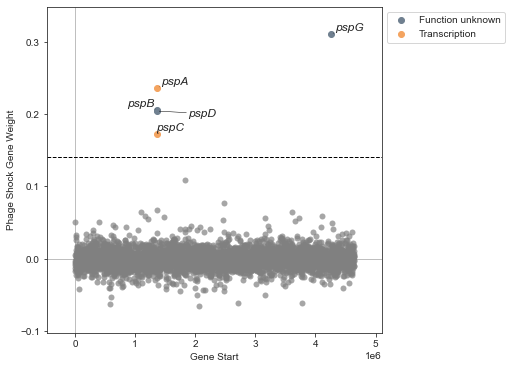

In [304]:
fig = plot_gene_weights(ica_data_1k36,"Phage Shock")
fig.figure.savefig("../images/phage_gw.svg")

<AxesSubplot:ylabel='Phage Shock iModulon\nActivity'>

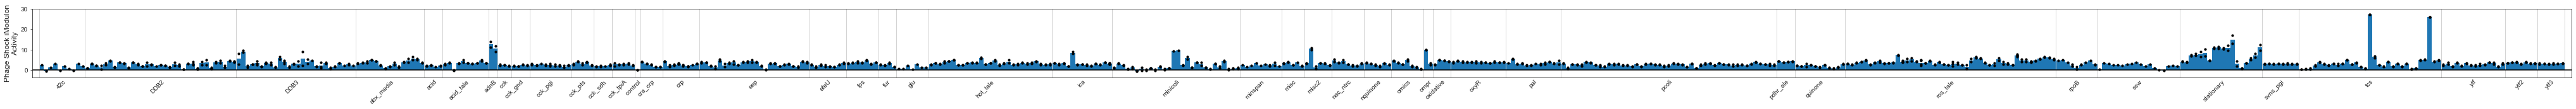

In [294]:
plot_activities(ica_data_1k36, 'Phage Shock')

<AxesSubplot:ylabel='Phage Shock iModulon\nActivity'>

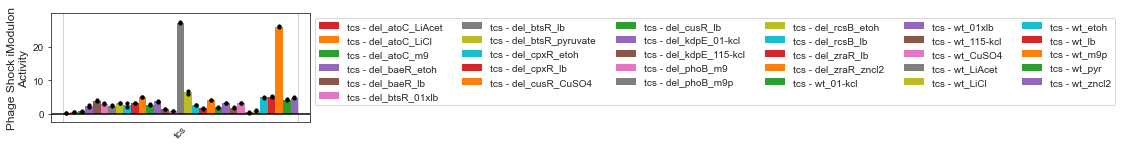

In [296]:
plot_activities(ica_data_1k36, 'Phage Shock', projects="tcs")
#del_phoB_m9p
#wt_m9p

entire sample:  -0.15 5.133072234218047e-07
-0.42 0.0115665500708031


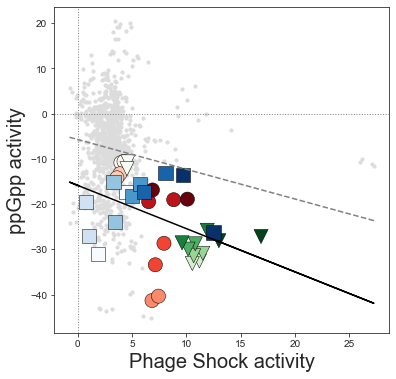

In [306]:
fig = _plot_activities_R2(ica_data_1k36,'Phage Shock','ppGpp',[])


entire sample:  -0.25 2.701804883191332e-17
-0.65 1.649055375726122e-05


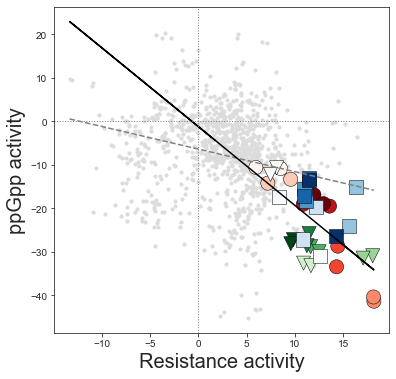

In [307]:
fig = _plot_activities_R2(ica_data_1k36,'Resistance','ppGpp',[])


entire sample:  0.24 1.1693388895890638e-15
0.18 0.2928367562624244


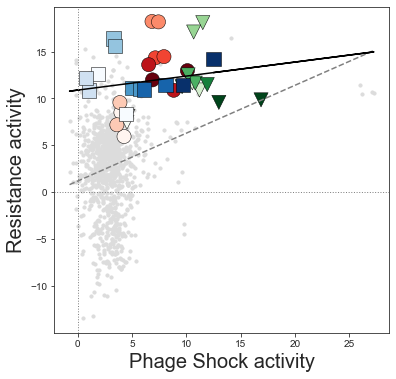

In [295]:
fig = _plot_activities_R2(ica_data_1k36,'Phage Shock','Resistance',[])


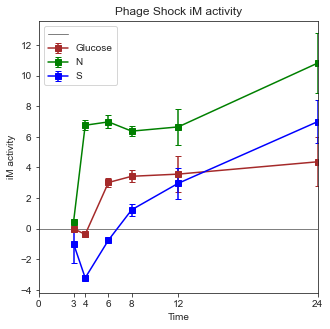

In [397]:
fig, ax = _plot_time_activities(ica_data_1k36_stationary, 'Phage Shock', group_dict)
fig.savefig("../images/phage_time_A.svg")

(<Figure size 360x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Resistance iM activity'}, xlabel='Time', ylabel='iM activity'>)

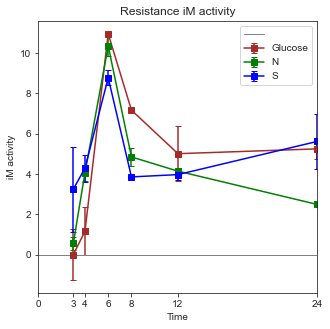

In [394]:
_plot_time_activities(ica_data_1k36_stationary, 'Resistance', group_dict)

# Resistance

In [309]:
ica_data_1k36.compute_trn_enrichment('Resistance', fdr=.1, max_regs=1)

imodulon regulator    pvalue    qvalue  precision    recall   f1score  \
0  Resistance      YcaN  0.002210  0.061873   0.037736  0.333333  0.067797   
1  Resistance      McbR  0.002210  0.061873   0.037736  0.333333  0.067797   
2  Resistance      cyaR  0.004059  0.075777   0.037736  0.250000  0.065574   
3  Resistance      sokB  0.012450  0.099601   0.018868  1.000000  0.037037   
4  Resistance      PdeL  0.012450  0.099601   0.018868  1.000000  0.037037   
5  Resistance       Nac  0.009370  0.099601   0.245283  0.025048  0.045455   
6  Resistance      MicL  0.012450  0.099601   0.018868  1.000000  0.037037   

     TP  regulon_size  imodulon_size  n_regs  
0   2.0           6.0           53.0     1.0  
1   2.0           6.0           53.0     1.0  
2   2.0           8.0           53.0     1.0  
3   1.0           1.0           53.0     1.0  
4   1.0           1.0           53.0     1.0  
5  13.0         519.0           53.0     1.0  
6   1.0           1.0           53.0     1.0

In [398]:
ica_data_1k36.view_imodulon('Resistance').sort_values('gene_weight', ascending=False).to_csv("./resistance_iM_table.csv")

In [299]:
ica_data_1k36.view_imodulon('Resistance').sort_values('gene_weight', ascending=False)[['gene_name', 'gene_product']]

gene_name                                       gene_product
b4662      sgrT  putative inhibitor of the PtsG glucose transpo...
b4595      yciY                       uncharacterized protein YciY
b0762      acrZ       multidrug efflux pump accessory protein AcrZ
b0953       rmf                         ribosome modulation factor
b4411      ecnB            bacteriolytic entericidin B lipoprotein
b4705      mntS                                 small protein MntS
b1677       lpp                                 murein lipoprotein
b4409       blr                     beta-lactam resistance protein
b1550      gnsB                       Qin prophage%3B protein GnsB
b4501      torI  CPS-53 (KpLE1) prophage%3B prophage CPS-53 rec...
b2666      yqaE                                Pmp3 family protein
b3369      yhfL         DUF4223 domain-containing lipoprotein YhfL
b0623      cspE  transcription antiterminator and regulator of ...
b4217      ytfK             DUF1107 domain-containing protein YtfK
b1480       sra                  30S ribosomal subunit protein S22
b4045      yjbJ                   putative stress response protein
b0917      ycaR                        UPF0434 family protein YcaR
b0849      grxA                             reduced glutaredoxin 1
b3782      rhoL                          rho operon leader peptide
b2504      yfgG                                       protein YfgG
b1332      ynaJ             DUF2534 domain-containing protein YnaJ
b0295      ykgL                       uncharacterized protein YkgL
b1675      fumD                                         fumarase D
b3049      glgS                      surface composition regulator
b1562      hokD                 Qin prophage%3B toxic protein HokD
b0699      ybfA             DUF2517 domain-containing protein YbfA
b2833      ygdR          DUF903 domain-containing lipoprotein YgdR
b4688      ykgS                     CP4-6 prophage%3B protein YkgS
b1420      mokB                   putative regulatory protein MokB
b3107      yhaL                       uncharacterized protein YhaL
b2809      ygdI          DUF903 domain-containing lipoprotein YgdI
b3703      rpmH                  50S ribosomal subunit protein L34
b0627      tatE  twin arginine protein translocation system - T...
b1824      yobF             DUF2527 domain-containing protein YobF
b1906      yecH             DUF2492 domain-containing protein YecH
b1915      yecF             DUF2594 domain-containing protein YecF
b4246      pyrL                        pyrBI operon leader peptide
b1952      dsrB                                       protein DsrB
b1795      yeaQ                        PF04226 family protein YeaQ
b4428      hokB                                         toxin HokB
b1826      mgrB                              PhoQ kinase inhibitor
b4756      yqiD                                       protein YqiD
b3263      yhdU             DUF2556 domain-containing protein YhdU
b4550      arfA               alternative ribosome-rescue factor A
b1259      yciG                                       protein YciG
b3556      cspA                            cold shock protein CspA
b4514      ybfQ                          inactive transposase YbfQ
b3535      yhjR                        PF10945 family protein YhjR
b3928      zapB                          cell division factor ZapB
b1705      ydiE                        PF10636 family protein YdiE
b4517      gnsA  putative phosphatidylethanolamine synthesis re...
b1685      ydiH                                       protein YdiH
b0315      pdeL  DNA-binding transcriptional activator/c-di-GMP...

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



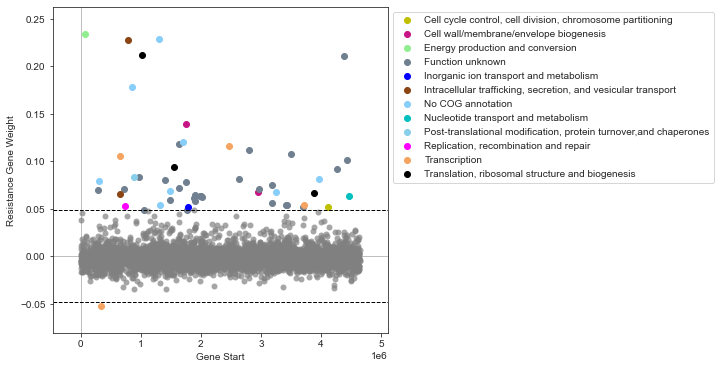

In [300]:
fig = plot_gene_weights(ica_data_1k36,"Resistance")
fig.figure.savefig("../images/resistance_gw.svg")

<AxesSubplot:ylabel='Resistance iModulon\nActivity'>

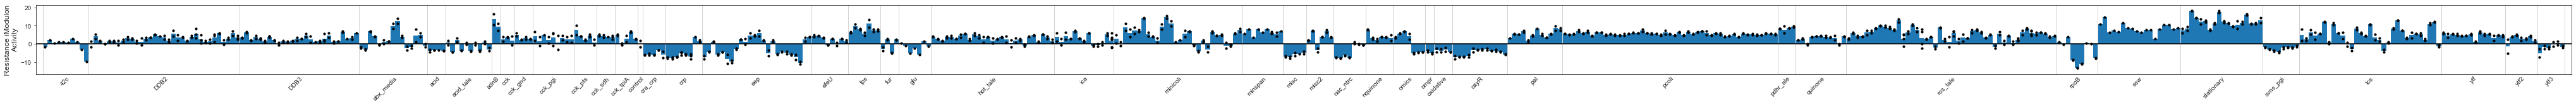

In [280]:
plot_activities(ica_data_1k36, 'Resistance')

<AxesSubplot:ylabel='Phage Shock iModulon\nActivity'>

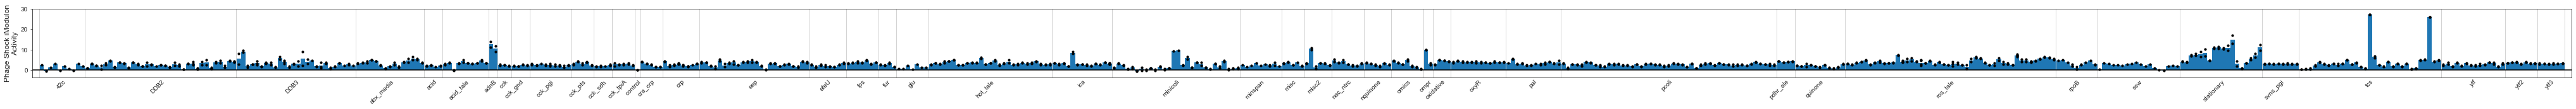

In [285]:
plot_activities(ica_data_1k36, 'Phage Shock')

<AxesSubplot:ylabel='Phage Shock iModulon\nActivity'>

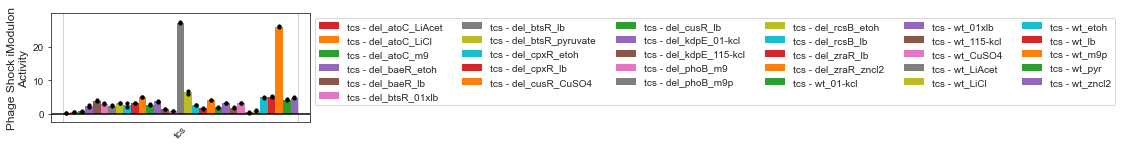

In [286]:
plot_activities(ica_data_1k36, 'Phage Shock', projects="tcs")

<AxesSubplot:xlabel='ppGpp iModulon Activity', ylabel='Resistance iModulon Activity'>

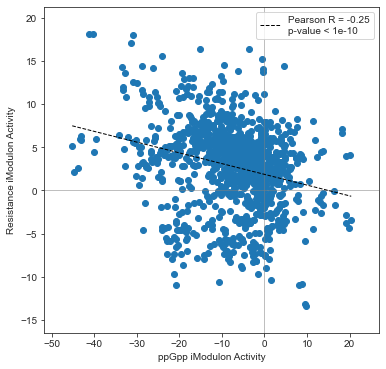

In [399]:
compare_activities(ica_data_1k36, 'ppGpp', 'Resistance')

In [18]:
ica_data_1k36_stationary.A

p1k_01056  p1k_01057  p1k_01058  p1k_01059  p1k_01060  p1k_01061  \
Resistance   8.520625   5.951351   9.570878   7.198545  18.205643  18.161984   
SSW SNPs     1.513314   1.304917   1.578510   1.374651   7.241384   6.835234   
cspH        -1.303021  -2.824689   0.040189  -1.143072  -0.534427  -0.125049   
Galactose   -3.697949  -4.205885  -4.461632  -3.452163   4.109179   1.154971   
NtrC-1      -4.047772  -4.575263  -4.056049  -3.991743   3.029758   8.644280   
...               ...        ...        ...        ...        ...        ...   
SlyA        -1.756812  -1.834416  -0.432550  -0.324127  22.669507  22.699455   
ymfR         1.792962   0.803490   2.947507   1.491486   4.971910   4.971912   
yqgC        -0.509388  -0.488326  -0.501704  -1.473316  -2.021982  -3.471034   
TreR        -0.911423  -2.267406  -3.095347  -3.820740  -4.960790  -0.150333   
pts ALE      2.341702   1.933878   1.797125   1.608888   5.208648   5.073167   

            p1k_01062  p1k_01063  p1k_01064  p1k_01065  ...  p1k_01082  \
Resistance  14.331543  14.461492  13.600475  10.875502  ...  10.847087   
SSW SNPs     8.174303   6.640530   4.927105   8.204780  ...   5.331542   
cspH        -0.823425  -1.857480  -0.119930   1.019626  ...  -1.002868   
Galactose    3.614602  -0.710764  -1.329661  -2.665598  ...  -8.802554   
NtrC-1      11.610459   8.950161   7.402609   6.467052  ...  -0.744213   
...               ...        ...        ...        ...  ...        ...   
SlyA        25.818640  19.582353  16.193424  12.875175  ...   0.640359   
ymfR         5.394593   2.689204   2.079246   6.346793  ...   3.616231   
yqgC        -4.764227  -0.150678  -0.895894  -3.232142  ...  -1.928742   
TreR       -11.108111  -8.713171  -6.857058  -4.553611  ... -10.258296   
pts ALE      4.926935   4.221347   3.292871   4.217501  ...   4.151518   

            p1k_01083  p1k_01084  p1k_01085  p1k_01086  p1k_01087  p1k_01088  \
Resistance  12.181044  16.387894  15.620917  11.163689  11.007613  10.956734   
SSW SNPs     4.483589   4.698019   6.118037   5.005690   4.176978   5.819787   
cspH        -3.176264  -1.707373   0.145767  -1.734044  -1.736984  -0.140959   
Galactose  -10.410393 -10.710225  -9.135924 -10.342823  -9.871681  -8.937033   
NtrC-1      -4.457810  -4.948142  -1.768657  -2.791550  -2.946945  -2.362347   
...               ...        ...        ...        ...        ...        ...   
SlyA         0.443889   0.716306   0.460494   1.859949   2.659145   3.143442   
ymfR         2.390338   1.899061   4.032913   4.455284   1.930653   3.696658   
yqgC        -1.698756  -1.456665  -1.922849   0.347295   0.557185  -0.529035   
TreR        -9.537595  -8.120201  -9.618396  -8.091875  -8.073036  -8.020628   
pts ALE      3.333268   3.728842   4.228370   4.252707   3.431779   3.066456   

            p1k_01089  p1k_01090  p1k_01091  
Resistance  11.444966  11.467835  14.230145  
SSW SNPs     4.233926   4.922234   8.599409  
cspH        -0.322709  -1.264080   0.924571  
Galactose   -9.569160  -8.861758  -4.949558  
NtrC-1      -2.726228  -1.474110   7.643152  
...               ...        ...        ...  
SlyA         2.071997   2.727190   7.751741  
ymfR         1.370401   2.454274   0.897922  
yqgC        -0.054976   0.247025  -5.841046  
TreR        -8.843984  -7.285400 -10.528102  
pts ALE      2.936616   2.189735   3.349115  

[247 rows x 36 columns]

# UC-1

In [290]:
ica_data_1k36.view_imodulon('UC-1').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name         synonyms  \
b1957     0.136809      yodC             yodC   
b1559     0.110773      ydfT        quuQ;ydfT   
b4126     0.110141      yjdI             yjdI   
b1795     0.107242      yeaQ             yeaQ   
b0498     0.103721      ybbC             ybbC   
b4224     0.090012      chpS  chpS;chpBI;yjfB   
b0901     0.088890      ycaK             ycaK   
b2377     0.088714      yfdY             yfdY   
b0119     0.084993      yacL             yacL   
b0132     0.084628      rpnC        rpnC;yadD   
b1051     0.083595      msyB             msyB   
b3635     0.083509      mutM         mutM;fpg   
b1952     0.081640      dsrB             dsrB   
b4225     0.078537      chpB  chpB;chpBK;yjfE   
b1920     0.075988      tcyJ        fliY;yzzR   
b4127     0.075404      yjdJ             yjdJ   
b1825     0.074900      yebO             yebO   
b3953     0.074362      frwD        frwD;yijN   
b1908     0.073890      yecA             yecA   
b1512     0.072943      lsrR        lsrR;ydeW   
b2448     0.072880      yffQ             yffQ   
b0838     0.072772      gstB        gstB;yliJ   
b1664     0.069601      ydhQ             ydhQ   
b1906     0.069258      yecH             yecH   
b1958     0.068161      yedI             yedI   
b3910     0.066076      yiiM             yiiM   
b1272     0.065960      sohB             sohB   
b1826     0.065021      mgrB        mgrB;yobG   
b0394     0.064484       mak         mak;yajF   
b4090     0.064276      rpiB        rpiB;yjcA   

                                            gene_product  \
b1957                                       protein YodC   
b1559  Qin prophage%3B putative antitermination prote...   
b4126                        PF06902 family protein YjdI   
b1795                        PF04226 family protein YeaQ   
b0498                        PF15631 family protein YbbC   
b4224  ChpS antitoxin of the ChpB-ChpS toxin-antitoxi...   
b0901     putative NAD(P)H-dependent oxidoreductase YcaK   
b2377             DUF2545 domain-containing protein YfdY   
b0119                        UPF0231 family protein YacL   
b0132              recombination-promoting nuclease RpnC   
b1051  acidic protein that suppresses heat sensitivit...   
b3635                DNA-formamidopyrimidine glycosylase   
b1952                                       protein DsrB   
b4225                        endoribonuclease toxin ChpB   
b1920  cystine ABC transporter periplasmic binding pr...   
b4127                  putative N-acetyltransferase YjdJ   
b1825                       uncharacterized protein YebO   
b3953             putative PTS enzyme IIB component FrwD   
b1908                        UPF0149 family protein YecA   
b1512         DNA-binding transcriptional repressor LsrR   
b2448    CPZ-55 prophage%3B uncharacterized protein YffQ   
b0838                     glutathione S-transferase GstB   
b1664                  adhesin-like autotransporter YdhQ   
b1906             DUF2492 domain-containing protein YecH   
b1958              conserved inner membrane protein YedI   
b3910  2-amino-6-N-hydroxylaminopurine resistance pro...   
b1272                       S49 peptidase family protein   
b1826                              PhoQ kinase inhibitor   
b0394                                manno(fructo)kinase   
b4090  allose-6-phosphate isomerase/ribose-5-phosphat...   

                                                     COG  \
b1957                                   Function unknown   
b1559                                      Transcription   
b4126                                   Function unknown   
b1795                                   Function unknown   
b0498                                   Function unknown   
b4224                                      Transcription   
b0901                                   Function unknown   
b2377                                   Function unknown   
b0119                                   Function unknown   
b0132              Replica

In [313]:
temp_list=[]
for i in ica_data_1k36.imodulon_table.index:
    pearR, pval = pearsonr(ica_data_1k36.A.loc[i], ica_data_1k36.A.loc['UC-1'])
    if abs(pearR)>0.5:
        print(i, pearR, pval)
        temp_list.append(i)

RelB 0.5097008128053839 7.039855567451549e-72
UC-1 1.0 0.0
yjiS 0.5372365001644649 4.0135187717000343e-81
ghoT 0.5717597276405064 5.428480209701387e-94
ytiC 0.5929133696422302 1.155945602561569e-102


<AxesSubplot:ylabel='UC-1 iModulon\nActivity'>

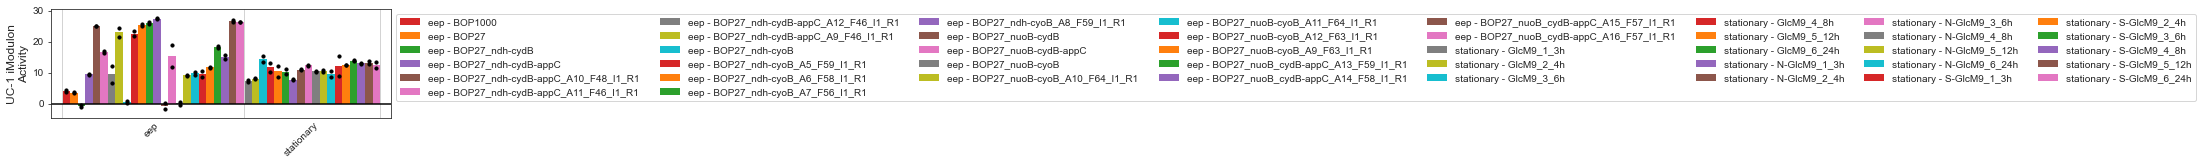

In [317]:
plot_activities(ica_data_1k36, 'UC-1', projects={'eep','stationary'}, highlight={'eep','stationary'})

In [318]:
ica_data_1k36.view_imodulon('ryhB').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name        synonyms  \
b0728     0.238459      sucC            sucC   
b0729     0.230188      sucD            sucD   
b0727     0.227680      sucB            sucB   
b0726     0.219568      sucA            sucA   
b4735     0.199820      ybgU             NaN   
b0720     0.113497      gltA  gltA;gluT;icdB   

                                            gene_product  \
b0728               succinyl-CoA synthetase subunit beta   
b0729              succinyl-CoA synthetase subunit alpha   
b0727                      dihydrolipoyltranssuccinylase   
b0726  subunit of E1(0) component of 2-oxoglutarate d...   
b4735                                       protein YbgU   
b0720                                   citrate synthase   

                                       COG  \
b0728  Nucleotide transport and metabolism   
b0729     Energy production and conversion   
b0727     Energy production and conversion   
b0726  Nucleotide transport and metabolism   
b4735                    No COG annotation   
b0720     Energy production and conversion   

                                          regulator        uniprot   start  \
b0728  RpoD,YfeD,RpoS,Fur,Fnr,IHF,Crp,ArcA,ryhB,spf         P0A836  763014   
b0729           RpoD,RpoS,Fur,Fnr,IHF,Crp,ArcA,ryhB         P0AGE9  764180   
b0727           RpoD,RpoS,Fur,Fnr,IHF,Crp,ArcA,ryhB         P0AFG6  761522   
b0726       RpoD,RpoS,Fur,Fnr,IHF,Crp,ArcA,Nac,ryhB         P0AFG3  758706   
b4735                                           NaN  UPI0001A5C00D  754674   
b0720          RpoD,YdcI,IHF,Crp,ArcA,ppGpp,Nac,spf         P0ABH7  753185   

          end strand  ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b0728  764180      +  ...  False   True          11692.5            6881.0   
b0729  765049      +  ...  False   True          12362.5            6452.0   
b0727  762739      +  ...  False   True           6105.0            5384.0   
b0726  761507      +  ...  False   True           2784.5            2979.0   
b4735  754781      -  ...  False  False              NaN               NaN   
b0720  754468      -  ...  False   True          18796.0            7960.0   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b0728       True  True        10.081118           9.490213        1.038186   
b0729       True  True         9.912776           9.653647        1.094604   
b0727       True  True        10.201474           9.369526        0.971274   
b0726       True  True         9.755455           8.737696        1.147602   
b4735      False  True         9.400950           7.552668        2.219529   
b0720       True  True        11.074862          10.203169        0.861426   

       in_iM  
b0728   True  
b0729   True  
b0727  False  
b0726  False  
b4735   True  
b0720   True  

[6 rows x 27 columns]

In [319]:
ica_data_1k36.view_imodulon('sdh KO').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name   synonyms  \
b0722     0.495484      sdhD       sdhD   
b0723     0.482432      sdhA       sdhA   
b0724     0.387354      sdhB       sdhB   
b0721     0.314986      sdhC  sdhC;cybA   
b2029    -0.145220       gnd        gnd   

                                            gene_product  \
b0722  succinate:quinone oxidoreductase%2C membrane p...   
b0723  succinate:quinone oxidoreductase%2C FAD bindin...   
b0724  succinate:quinone oxidoreductase%2C iron-sulfu...   
b0721  succinate:quinone oxidoreductase%2C membrane p...   
b2029  6-phosphogluconate dehydrogenase%2C decarboxyl...   

                                       COG  \
b0722     Energy production and conversion   
b0723     Energy production and conversion   
b0724     Energy production and conversion   
b0721     Energy production and conversion   
b2029  Nucleotide transport and metabolism   

                                               regulator uniprot    start  \
b0722                         RpoD,ryhB,Fur,Fnr,Crp,ArcA  P0AC44   755560   
b0723                         RpoD,Fur,Fnr,Crp,ArcA,ryhB  P0AC41   755907   
b0724                         RpoD,Fur,Fnr,Crp,ArcA,ryhB  P07014   757689   
b0721  RpoD,YdcI,YdiP,Fur,Fnr,Crp,ArcA,Nac,rybB,ryhB,spf  P69054   755177   
b2029                                  RpoD,Fur,GadE,Fnr  P00350  2099862   

           end strand  ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b0722   755907      +  ...  False   True             35.0             537.0   
b0723   757673      +  ...  False   True           4083.5            2923.0   
b0724   758405      +  ...  False   True           3756.0            2336.0   
b0721   755566      +  ...  False  False           1732.0               NaN   
b2029  2101268      -  ...  False   True           8118.5            5415.0   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b0722       True  True         9.642353           8.447304        1.713369   
b0723       True  True         9.888932           8.718672        1.505427   
b0724       True  True         9.984374           8.822050        1.487632   
b0721       True  True        10.952230           9.124262        1.623725   
b2029       True  True        10.124746           9.854772        0.595288   

       in_iM  
b0722   True  
b0723   True  
b0724   True  
b0721   True  
b2029   True  

[5 rows x 27 columns]

entire sample:  0.7 3.569337039595328e-161
0.79 7.146275502913568e-09


<AxesSubplot:xlabel='sdh KO activity', ylabel='ryhB activity'>

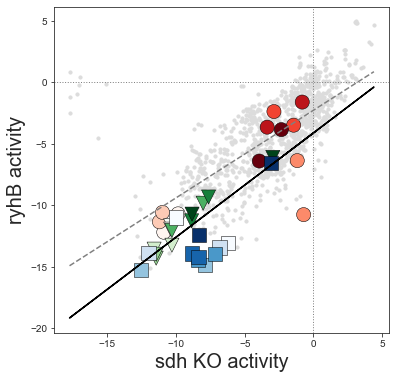

In [329]:
_plot_activities_R2(ica_data_1k36, 'sdh KO', 'ryhB', [])

<AxesSubplot:xlabel='sdh KO iModulon Activity', ylabel='ryhB iModulon Activity'>

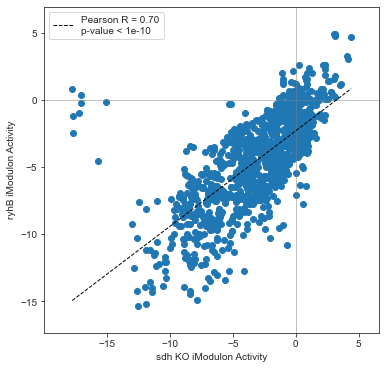

In [323]:
compare_activities(ica_data_1k36, 'sdh KO', 'ryhB')

In [320]:
ica_data_1k36.view_imodulon('SlyA').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name   synonyms  \
b4565     0.315788      sgcB       sgcB   
b4303     0.187429      sgcQ  sgcQ;yjhM   
b4304     0.178653      sgcC  sgcC;yjhN   
b4305     0.158575      sgcX  sgcX;yjhO   
b4302     0.131867      sgcA  sgcA;yjhL   

                                            gene_product  \
b4565             putative PTS enzyme IIB component SgcB   
b4303  KpLE2 phage-like element%3B putative nucleosid...   
b4304             putative PTS enzyme IIC component SgcC   
b4305  KpLE2 phage-like element%3B putative endogluca...   
b4302             putative PTS enzyme IIA component SgcA   

                                         COG      regulator uniprot    start  \
b4565  Carbohydrate transport and metabolism       Crp,SlyA  P58035  4530255   
b4303                       Function unknown       Crp,SlyA  P39364  4528111   
b4304  Carbohydrate transport and metabolism  Crp,SlyA,GlaR  P39365  4528930   
b4305  Carbohydrate transport and metabolism       Crp,SlyA  P39366  4530530   
b4302  Carbohydrate transport and metabolism       Crp,SlyA  P39363  4527549   

           end strand  ... y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b4565  4530533      -  ...  True  False              NaN               NaN   
b4303  4528917      -  ...  True  False              1.0               NaN   
b4304  4530243      -  ...  True  False              NaN               NaN   
b4305  4531651      -  ...  True  False              5.0               NaN   
b4302  4527980      -  ...  True  False              NaN               NaN   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b4565      False  True         1.343749           1.931621        0.962446   
b4303       True  True         2.173873           2.812029        0.582868   
b4304      False  True         2.126537           2.394817        0.639868   
b4305       True  True         1.969921           2.215832        0.851619   
b4302      False  True         4.049249           3.701362        0.781555   

       in_iM  
b4565   True  
b4303   True  
b4304   True  
b4305   True  
b4302   True  

[5 rows x 27 columns]

In [322]:
ica_data_1k36.view_imodulon('SlyA')

gene_weight gene_name   synonyms  \
b4302     0.131867      sgcA  sgcA;yjhL   
b4303     0.187429      sgcQ  sgcQ;yjhM   
b4304     0.178653      sgcC  sgcC;yjhN   
b4305     0.158575      sgcX  sgcX;yjhO   
b4565     0.315788      sgcB       sgcB   

                                            gene_product  \
b4302             putative PTS enzyme IIA component SgcA   
b4303  KpLE2 phage-like element%3B putative nucleosid...   
b4304             putative PTS enzyme IIC component SgcC   
b4305  KpLE2 phage-like element%3B putative endogluca...   
b4565             putative PTS enzyme IIB component SgcB   

                                         COG      regulator uniprot    start  \
b4302  Carbohydrate transport and metabolism       Crp,SlyA  P39363  4527549   
b4303                       Function unknown       Crp,SlyA  P39364  4528111   
b4304  Carbohydrate transport and metabolism  Crp,SlyA,GlaR  P39365  4528930   
b4305  Carbohydrate transport and metabolism       Crp,SlyA  P39366  4530530   
b4565  Carbohydrate transport and metabolism       Crp,SlyA  P58035  4530255   

           end strand  ... y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b4302  4527980      -  ...  True  False              NaN               NaN   
b4303  4528917      -  ...  True  False              1.0               NaN   
b4304  4530243      -  ...  True  False              NaN               NaN   
b4305  4531651      -  ...  True  False              5.0               NaN   
b4565  4530533      -  ...  True  False              NaN               NaN   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b4302      False  True         4.049249           3.701362        0.781555   
b4303       True  True         2.173873           2.812029        0.582868   
b4304      False  True         2.126537           2.394817        0.639868   
b4305       True  True         1.969921           2.215832        0.851619   
b4565      False  True         1.343749           1.931621        0.962446   

       in_iM  
b4302   True  
b4303   True  
b4304   True  
b4305   True  
b4565   True  

[5 rows x 27 columns]

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



<AxesSubplot:xlabel='Gene Start', ylabel='SlyA Gene Weight'>

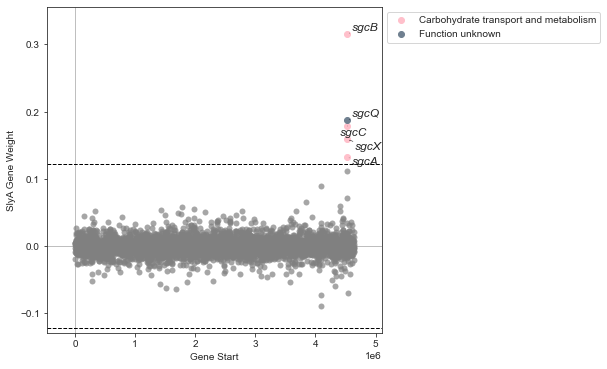

In [321]:
plot_gene_weights(ica_data_1k36,"SlyA")

In [330]:
ica_data_1k36.view_imodulon('Methionine').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name    synonyms  \
b3941     0.342498      metF        metF   
b4013     0.306644      metA  metAS;metA   
b3828     0.278522      metR        metR   
b3939     0.249394      metB        metB   
b0600     0.243961      ybdL        ybdL   
b0260     0.230753      mmuP   mmuP;ykfD   
b0199     0.218533      metN    metN;abc   
b0599     0.200105      hcxA   hcxA;ybdH   
b2942     0.200103      metK   metK;metX   
b3829     0.195742      metE        metE   
b3940     0.185854      metL   metL;metM   
b0198     0.163629      metI   metI;yaeE   
b3008     0.149242      metC        metC   
b0261     0.142307      mmuM   mmuM;yagD   
b3938     0.137596      metJ        metJ   
b3937     0.137031      yiiX        yiiX   
b0197     0.119076      metQ   metQ;yaeC   

                                            gene_product  \
b3941         5%2C10-methylenetetrahydrofolate reductase   
b4013                   homoserine O-succinyltransferase   
b3828    DNA-binding transcriptional dual regulator MetR   
b3939  O-succinylhomoserine(thiol)-lyase/O-succinylho...   
b0600  methionine-oxo-acid transaminase%2C PLP-dependent   
b0260                  S-methyl-L-methionine transporter   
b0199  L-methionine/D-methionine ABC transporter ATP ...   
b0599                 hydroxycarboxylate dehydrogenase A   
b2942                     methionine adenosyltransferase   
b3829  cobalamin-independent homocysteine transmethylase   
b3940  fused aspartate kinase/homoserine dehydrogenase 2   
b0198  L-methionine/D-methionine ABC transporter memb...   
b3008  cystathionine beta-lyase/L-cysteine desulfhydrase   
b0261                   homocysteine S-methyltransferase   
b3938         DNA-binding transcriptional repressor MetJ   
b3937                   putative lipid binding hydrolase   
b0197  L-methionine/D-methionine ABC transporter memb...   

                                          COG                     regulator  \
b3941     Amino acid transport and metabolism                     RpoD,MetJ   
b4013     Amino acid transport and metabolism                RpoD,RpoH,MetJ   
b3828                           Transcription  OxyR,YcfQ,YebK,MetJ,MetR,Nac   
b3939     Amino acid transport and metabolism           RpoD,PhoP,HypT,MetJ   
b0600     Amino acid transport and metabolism                           Lrp   
b0260     Amino acid transport and metabolism                           NaN   
b0199  Inorganic ion transport and metabolism          RpoD,MetJ,ppGpp,HypT   
b0599        Energy production and conversion                           NaN   
b2942       Coenzyme transport and metabolism        RpoD,RpoS,Crp,MetJ,Lrp   
b3829     Amino acid transport and metabolism  OxyR,YcjW,MetR,MetJ,Nac,fnrS   
b3940     Amino acid transport and metabolism      RpoD,PhoP,YcjW,HypT,MetJ   
b0198  Inorganic ion transport and metabolism          RpoD,MetJ,ppGpp,HypT   
b3008     Amino acid transport and metabolism                     RpoD,MetJ   
b0261     Amino acid transport and metabolism                           NaN   
b3938                           Transcription                      RpoD,Fur   
b3937                        Function unknown                         ppGpp   
b0197  Inorganic ion transport and metabolism                RpoD,MetJ,HypT   

      uniprot    start      end strand  ...  y_ome  k_eff schmidt_prot_med  \
b3941  P0AEZ1  4132616  4133506      +  ...  False   True           2273.0   
b4013  P07623  4214280  4215209      +  ...  False   True            831.0   
b3828  P0A9F9  4011863  4012816      -  ...  False   True             41.5   
b3939  P00935  4128672  4129832      +  ...  False   True            876.5   
b0600  P77806   633586   634746      +  ...  False   True             39.5   
b0260  Q47689   275325   276728      +  ...  False  False              NaN   
b0199  P30750   221614   222645      -  ...  False   True            889.5   
b0599  P45579   632389   633477      -  ...  False   True            386.0   
b2942  P

entire sample:  0.26 2.995195443235762e-18
-0.24 0.16339984419595305


<AxesSubplot:xlabel='Methionine activity', ylabel='ryhB activity'>

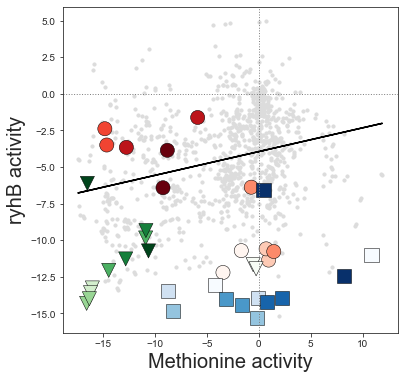

In [332]:
_plot_activities2(ica_data_1k36, "Methionine", 'ryhB', [])

entire sample:  0.52 1.1449634991871136e-74
0.33 0.04831966368474274


<AxesSubplot:xlabel='Methionine activity', ylabel='Arginine activity'>

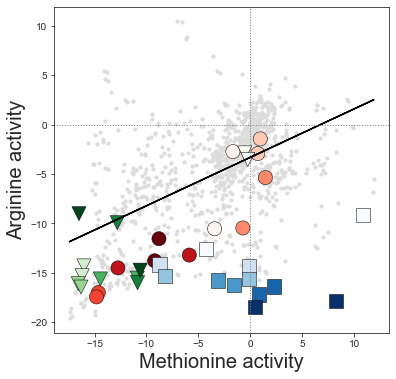

In [333]:
_plot_activities2(ica_data_1k36, "Methionine", 'Arginine', [])

# AA related iMs

## Leucine, alanine, valine, isoleucine,

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


<AxesSubplot:xlabel='Gene Start', ylabel='Lrp Gene Weight'>

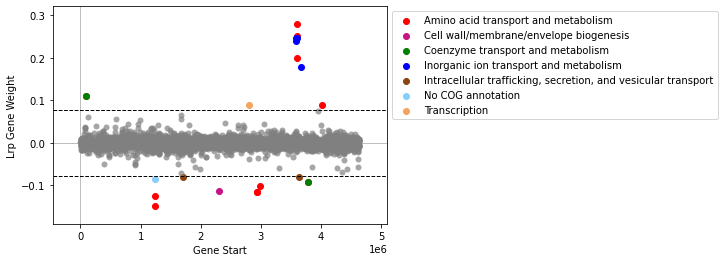

In [32]:
plot_gene_weights(ica_data_1k36, 'Lrp')

In [31]:
ica_data_1k36.view_imodulon('Lrp').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name        synonyms  \
b3458     0.278694      livK            livK   
b3457     0.252459      livH            livH   
b3455     0.246133      livG            livG   
b3456     0.245711      livM            livM   
b3454     0.238800      livF            livF   
b3460     0.199394      livJ            livJ   
b3523     0.178384      yhjE            yhjE   
b0077     0.111227      ilvI            ilvI   
b0078     0.110037      ilvH       ilvH;brnP   
b3829     0.090307      metE            metE   
b2669     0.088066      stpA       stpA;hnsB   
b3496    -0.079339      dtpB       dtpB;yhiP   
b1634    -0.080438      dtpA  dtpA;tppB;ydgR   
b4740    -0.084000      ymgM             NaN   
b3617    -0.091011       kbl             kbl   
b3616    -0.091475       tdh             tdh   
b2845    -0.100354      yqeG            yqeG   
b2209    -0.113146       eco         eco;eti   
b2797    -0.114972      sdaB            sdaB   
b2796    -0.116026      sdaC       sdaC;dcrA   
b1189    -0.125016      dadA       dadA;dadR   
b1190    -0.147782      dadX  dadX;alnB;dadB   

                                            gene_product  \
b3458  L-leucine/L-phenylalanine ABC transporter peri...   
b3457  branched chain amino acid/phenylalanine ABC tr...   
b3455  branched chain amino acid/phenylalanine ABC tr...   
b3456  branched chain amino acid/phenylalanine ABC tr...   
b3454  branched chain amino acid/phenylalanine ABC tr...   
b3460  branched chain amino acid/phenylalanine ABC tr...   
b3523                          putative transporter YhjE   
b0077  acetolactate synthase/acetohydroxybutanoate sy...   
b0078  acetolactate synthase/acetohydroxybutanoate sy...   
b3829  cobalamin-independent homocysteine transmethylase   
b2669  DNA-binding transcriptional repressor StpA wit...   
b3496           dipeptide/tripeptide:H(+) symporter DtpB   
b1634           dipeptide/tripeptide:H(+) symporter DtpA   
b4740                                       protein YmgM   
b3617                  2-amino-3-ketobutyrate CoA ligase   
b3616                            threonine dehydrogenase   
b2845                          putative transporter YqeG   
b2209                   serine protease inhibitor ecotin   
b2797                              L-serine deaminase II   
b2796                         serine:H(+) symporter SdaC   
b1189                         D-amino acid dehydrogenase   
b1190                                 alanine racemase 2   

                                                     COG  \
b3458                Amino acid transport and metabolism   
b3457                Amino acid transport and metabolism   
b3455             Inorganic ion transport and metabolism   
b3456             Inorganic ion transport and metabolism   
b3454             Inorganic ion transport and metabolism   
b3460                Amino acid transport and metabolism   
b3523             Inorganic ion transport and metabolism   
b0077                  Coenzyme transport and metabolism   
b0078                Amino acid transport and metabolism   
b3829                Amino acid transport and metabolism   
b2669                                      Transcription   
b3496  Intracellular trafficking, secretion, and vesi...   
b1634  Intracellular trafficking, secretion, and vesi...   
b4740                                  No COG annotation   
b3617                  Coenzyme transport and metabolism   
b3616                Amino acid transport and metabolism   
b2845                Amino acid transport and metabolism   
b2209             Cell wall/membrane/envelope biogenesis   
b2797                Amino acid transport and metabolism   
b2796                Amino acid transport and metabolism   
b1189                Amino acid transport and metabolism   
b1190                Amino acid transport and metabolism   

                           regulator        uniprot    start      end strand  \
b3458              RpoD,gcvB,Lrp,Nac         P04816  3596451

<AxesSubplot:ylabel='Lrp iModulon\nActivity'>

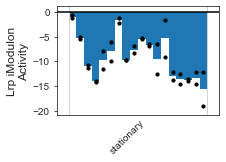

In [334]:
plot_activities(ica_data_1k36_stationary, 'Lrp')

In [33]:
ica_data_1k36.view_imodulon('Leucine').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name synonyms  \
b0072     0.314533      leuC     leuC   
b0073     0.311275      leuB     leuB   
b0071     0.294456      leuD     leuD   
b0074     0.293326      leuA     leuA   
b3670     0.116870      ilvN     ilvN   

                                     gene_product  \
b0072  3-isopropylmalate dehydratase subunit LeuC   
b0073             3-isopropylmalate dehydrogenase   
b0071  3-isopropylmalate dehydratase subunit LeuD   
b0074                  2-isopropylmalate synthase   
b3670   acetohydroxy acid synthase I subunit IlvN   

                                       COG  \
b0072  Amino acid transport and metabolism   
b0073     Energy production and conversion   
b0071  Amino acid transport and metabolism   
b0074  Amino acid transport and metabolism   
b3670  Amino acid transport and metabolism   

                                       regulator uniprot    start      end  \
b0072              RpoD,YeiE,LeuO,Leu-tRNA,ppGpp  P0A6A6    79464    80864   
b0073                   RpoD,LeuO,Leu-tRNA,ppGpp  P30125    80867    81958   
b0071                   RpoD,LeuO,Leu-tRNA,ppGpp  P30126    78848    79453   
b0074               RpoD,LeuO,Leu-tRNA,Lrp,ppGpp  P09151    81958    83529   
b3670  RpoD,YeiE,Crp,Leu-tRNA,Val-tRNA,Nac,ppGpp  P0ADF8  3850802  3851092   

      strand  ...  y_ome k_eff schmidt_prot_med heckmann_prot_med proteomics  \
b0072      -  ...  False  True           2280.0            3998.0       True   
b0073      -  ...  False  True           4854.0            3121.0       True   
b0071      -  ...  False  True           5155.5            2239.0       True   
b0074      -  ...  False  True           3424.5            2657.0       True   
b3670      -  ...  False  True           1813.5             387.0       True   

        p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  in_iM  
b0072  True         9.922261           9.552405        0.954644   True  
b0073  True         9.715227           9.402139        0.989027   True  
b0071  True         9.969492           9.649929        0.837590   True  
b0074  True         9.287032           9.282342        0.828215   True  
b3670  True         8.334615           7.737433        0.910853   True  

[5 rows x 27 columns]

<AxesSubplot:ylabel='Leucine iModulon\nActivity'>

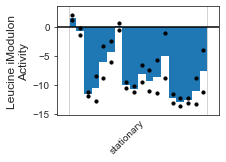

In [343]:
plot_activities(ica_data_1k36_stationary, 'Leucine')

## Methionine

In [40]:
ica_data_1k36.view_imodulon('Methionine').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name    synonyms  \
b3941     0.342498      metF        metF   
b4013     0.306644      metA  metAS;metA   
b3828     0.278522      metR        metR   
b3939     0.249394      metB        metB   
b0600     0.243961      ybdL        ybdL   
b0260     0.230753      mmuP   mmuP;ykfD   
b0199     0.218533      metN    metN;abc   
b0599     0.200105      hcxA   hcxA;ybdH   
b2942     0.200103      metK   metK;metX   
b3829     0.195742      metE        metE   
b3940     0.185854      metL   metL;metM   
b0198     0.163629      metI   metI;yaeE   
b3008     0.149242      metC        metC   
b0261     0.142307      mmuM   mmuM;yagD   
b3938     0.137596      metJ        metJ   
b3937     0.137031      yiiX        yiiX   
b0197     0.119076      metQ   metQ;yaeC   

                                            gene_product  \
b3941         5%2C10-methylenetetrahydrofolate reductase   
b4013                   homoserine O-succinyltransferase   
b3828    DNA-binding transcriptional dual regulator MetR   
b3939  O-succinylhomoserine(thiol)-lyase/O-succinylho...   
b0600  methionine-oxo-acid transaminase%2C PLP-dependent   
b0260                  S-methyl-L-methionine transporter   
b0199  L-methionine/D-methionine ABC transporter ATP ...   
b0599                 hydroxycarboxylate dehydrogenase A   
b2942                     methionine adenosyltransferase   
b3829  cobalamin-independent homocysteine transmethylase   
b3940  fused aspartate kinase/homoserine dehydrogenase 2   
b0198  L-methionine/D-methionine ABC transporter memb...   
b3008  cystathionine beta-lyase/L-cysteine desulfhydrase   
b0261                   homocysteine S-methyltransferase   
b3938         DNA-binding transcriptional repressor MetJ   
b3937                   putative lipid binding hydrolase   
b0197  L-methionine/D-methionine ABC transporter memb...   

                                          COG                     regulator  \
b3941     Amino acid transport and metabolism                     RpoD,MetJ   
b4013     Amino acid transport and metabolism                RpoD,RpoH,MetJ   
b3828                           Transcription  OxyR,YcfQ,YebK,MetJ,MetR,Nac   
b3939     Amino acid transport and metabolism           RpoD,PhoP,HypT,MetJ   
b0600     Amino acid transport and metabolism                           Lrp   
b0260     Amino acid transport and metabolism                           NaN   
b0199  Inorganic ion transport and metabolism          RpoD,MetJ,ppGpp,HypT   
b0599        Energy production and conversion                           NaN   
b2942       Coenzyme transport and metabolism        RpoD,RpoS,Crp,MetJ,Lrp   
b3829     Amino acid transport and metabolism  OxyR,YcjW,MetR,MetJ,Nac,fnrS   
b3940     Amino acid transport and metabolism      RpoD,PhoP,YcjW,HypT,MetJ   
b0198  Inorganic ion transport and metabolism          RpoD,MetJ,ppGpp,HypT   
b3008     Amino acid transport and metabolism                     RpoD,MetJ   
b0261     Amino acid transport and metabolism                           NaN   
b3938                           Transcription                      RpoD,Fur   
b3937                        Function unknown                         ppGpp   
b0197  Inorganic ion transport and metabolism                RpoD,MetJ,HypT   

      uniprot    start      end strand  ...  y_ome  k_eff schmidt_prot_med  \
b3941  P0AEZ1  4132616  4133506      +  ...  False   True           2273.0   
b4013  P07623  4214280  4215209      +  ...  False   True            831.0   
b3828  P0A9F9  4011863  4012816      -  ...  False   True             41.5   
b3939  P00935  4128672  4129832      +  ...  False   True            876.5   
b0600  P77806   633586   634746      +  ...  False   True             39.5   
b0260  Q47689   275325   276728      +  ...  False  False              NaN   
b0199  P30750   221614   222645      -  ...  False   True            889.5   
b0599  P45579   632389   633477      -  ...  False   True            386.0   
b2942  P

<AxesSubplot:ylabel='Methionine iModulon\nActivity'>

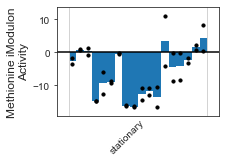

In [345]:
plot_activities(ica_data_1k36_stationary, 'Methionine')

## Histidine

<AxesSubplot:ylabel='Histidine iModulon\nActivity'>

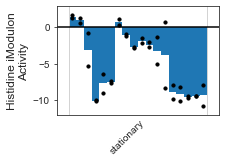

In [352]:
plot_activities(ica_data_1k36_stationary, 'Histidine')

<AxesSubplot:ylabel='Lysine/T2SS iModulon\nActivity'>

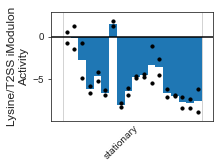

In [337]:
plot_activities(ica_data_1k36_stationary, 'Lysine/T2SS')

## Tryptophan

<AxesSubplot:ylabel='Tryptophan iModulon\nActivity'>

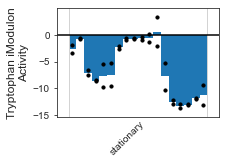

In [346]:
plot_activities(ica_data_1k36_stationary, 'Tryptophan')

## Serine

<AxesSubplot:ylabel='Thr/Ser-1 iModulon\nActivity'>

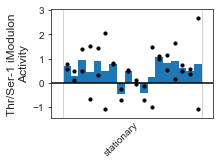

In [338]:
plot_activities(ica_data_1k36_stationary, 'Thr/Ser-1')

<AxesSubplot:ylabel='Purine iModulon\nActivity'>

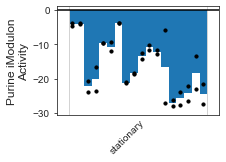

In [387]:
plot_activities(ica_data_1k36_stationary, 'Purine')

In [386]:
find_im(ica_data_1k36, 'serA')

Nitrogen
Purine


In [384]:
ica_data_1k36.view_imodulon('Thr/Ser-1')

gene_weight gene_name        synonyms  \
b3113     0.200414      tdcF       tdcF;yhaR   
b3114     0.221221      tdcE       tdcE;yhaS   
b3115     0.242336      tdcD       tdcD;yhaA   
b3116     0.221451      tdcC            tdcC   
b3117     0.256370      tdcB            tdcB   
b3118     0.133582      tdcA            tdcA   
b3666     0.083477      uhpT            uhpT   
b4130     0.082036      dtpC       dtpC;yjdL   
b4131     0.237635      cadA       cadA;ldcI   
b4132     0.233163      cadB            cadB   
b4471     0.192266      tdcG  tdcG;yhaP;yhaQ   

                                            gene_product  \
b3113                   putative enamine/imine deaminase   
b3114  2-ketobutyrate formate-lyase/pyruvate formate-...   
b3115                                  propionate kinase   
b3116                    threonine/serine:H(+) symporter   
b3117                    catabolic threonine dehydratase   
b3118         DNA-binding transcriptional activator TdcA   
b3666            hexose-6-phosphate:phosphate antiporter   
b4130           dipeptide/tripeptide:H(+) symporter DtpC   
b4131                             lysine decarboxylase 1   
b4132                       lysine:cadaverine antiporter   
b4471                             L-serine deaminase III   

                                          COG  \
b3113     Amino acid transport and metabolism   
b3114        Energy production and conversion   
b3115     Nucleotide transport and metabolism   
b3116     Amino acid transport and metabolism   
b3117     Amino acid transport and metabolism   
b3118                           Transcription   
b3666  Inorganic ion transport and metabolism   
b4130     Amino acid transport and metabolism   
b4131     Amino acid transport and metabolism   
b4132     Amino acid transport and metabolism   
b4471     Amino acid transport and metabolism   

                                               regulator uniprot    start  \
b3113                              Fnr,Crp,IHF,TdcA,TdcR  P0AGL2  3259721   
b3114                              Fnr,Crp,IHF,TdcA,TdcR  P42632  3260124   
b3115                              Fnr,Crp,IHF,TdcA,TdcR  P11868  3262452   
b3116                              Fnr,Crp,IHF,TdcA,TdcR  P0AAD8  3263686   
b3117                              Fnr,Crp,IHF,TdcA,TdcR  P0AGF6  3265039   
b3118                    Fnr,Crp,ppGpp,IHF,TdcA,TdcR,Nac  P0ACQ7  3266127   
b3666                       RpoD,oxyS,YeiE,UvrY,UhpA,Crp  P0AGC0  3845776   
b4130                                                NaN  P39276  4354954   
b4131  RpoD,GadX,ArcA,CadC,Lrp,OmpR,H-NS,GadE-RcsB,ppGpp  P0A9H3  4356470   
b4132   RpoD,YfeD,GadX,ArcA,CadC,Lrp,OmpR,H-NS,GadE-RcsB  P0AAE8  4358697   
b4471                              Fnr,Crp,IHF,TdcA,TdcR  P42630  3258285   

           end strand  ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med  \
b3113  3260110      -  ...   True   True              NaN             269.0   
b3114  3262418      -  ...  False  False              NaN               NaN   
b3115  3263660      -  ...  False  False              NaN               NaN   
b3116  3265017      -  ...  False  False              NaN               NaN   
b3117  3266028      -  ...  False  False              NaN               NaN   
b3118  3267065      -  ...  False  False              NaN               NaN   
b3666  3847167      -  ...  False  False              0.0               NaN   
b4130  4356411      -  ...  False  False              NaN               NaN   
b4131  4358617      -  ...  False  False              NaN               NaN   
b4132  4360031      -  ...  False  False              NaN               NaN   
b4471  3259649      -  ...  False  False              NaN               NaN   

      proteomics   p1k p1k_ctrl_log_tpm p1k_median_log_tpm p1k_mad_log_tpm  \
b3113       True  True         2.278856           2.815165        0.668304   
b3114      False  True         2.292200           2.174176        0.574686   
b3115      F

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning:

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.



<AxesSubplot:xlabel='Gene Start', ylabel='Thr/Ser-1 Gene Weight'>

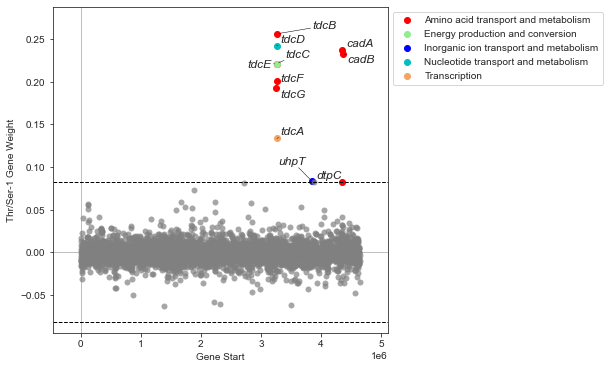

In [385]:
plot_gene_weights(ica_data_1k36, 'Thr/Ser-1')

## Arginine

<AxesSubplot:ylabel='Arginine iModulon\nActivity'>

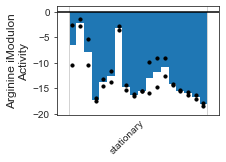

In [358]:
plot_activities(ica_data_1k36_stationary, 'Arginine')

## Glutamine

In [42]:
ica_data_1k36.view_imodulon('Glutamine').sort_values(by='gene_weight', ascending=False)

gene_weight gene_name        synonyms  \
b0811     0.293395      glnH            glnH   
b0810     0.288220      glnP            glnP   
b0809     0.284447      glnQ            glnQ   
b3870     0.188488      glnA            glnA   
b2310     0.148929      argT            argT   
b3744     0.118397      asnA            asnA   
b3869     0.114355      glnL  glnL;glnR;ntrB   
b2309     0.103402      hisJ            hisJ   
b2308     0.089969      hisQ            hisQ   
b0654     0.089799      gltJ            gltJ   
b0655     0.086369      gltI  gltI;ybeJ;yzzK   
b2306     0.085189      hisP            hisP   
b3868     0.084788      glnG  glnG;glnT;ntrC   

                                            gene_product  \
b0811  L-glutamine ABC transporter periplasmic bindin...   
b0810       L-glutamine ABC transporter membrane subunit   
b0809    L-glutamine ABC transporter ATP binding subunit   
b3870                               glutamine synthetase   
b2310  lysine/arginine/ornithine ABC transporter peri...   
b3744                            asparagine synthetase A   
b3869                      sensory histidine kinase NtrB   
b2309  histidine ABC transporter periplasmic binding ...   
b2308  lysine/arginine/ornithine ABC transporter/hist...   
b0654  glutamate/aspartate ABC transporter membrane s...   
b0655  glutamate/aspartate ABC transporter periplasmi...   
b2306  lysine/arginine/ornithine ABC transporter/hist...   
b3868    DNA-binding transcriptional dual regulator NtrC   

                                          COG  \
b0811     Amino acid transport and metabolism   
b0810  Inorganic ion transport and metabolism   
b0809     Amino acid transport and metabolism   
b3870     Nucleotide transport and metabolism   
b2310     Amino acid transport and metabolism   
b3744     Nucleotide transport and metabolism   
b3869     Nucleotide transport and metabolism   
b2309     Amino acid transport and metabolism   
b2308  Inorganic ion transport and metabolism   
b0654  Inorganic ion transport and metabolism   
b0655     Amino acid transport and metabolism   
b2306  Inorganic ion transport and metabolism   
b3868          Signal transduction mechanisms   

                                 regulator uniprot    start      end strand  \
b0811              RpoN,ppGpp,IHF,NtrC,Lrp  P0AEQ3   847258   848004      -   
b0810                  RpoN,ppGpp,IHF,NtrC  P0AEQ6   846460   847119      -   
b0809           RpoD,RpoN,Fis,IHF,NtrC,Lrp  P10346   845741   846463      -   
b3870           RpoD,RpoN,Crp,NtrC,Fis,Lrp  P0A9C5  4056625  4058034      -   
b2310   YcjW,RpoN,gcvB,NtrC,ppGpp,Lrp,ArcA  P09551  2427009  2427791      -   
b3744               RpoD,AsnC,Lrp,Nac,gcvB  P00963  3927155  3928147      +   
b3869           RpoD,RpoN,Crp,NtrC,Fis,Lrp  P0AFB5  4055290  4056339      -   
b2309  RpoD,YidZ,RpoN,H-NS,NtrC,ArgR,ppGpp  P0AEU0  2426006  2426788      -   
b2308       RpoD,RpoN,H-NS,NtrC,ArgR,ppGpp  P52094  2425230  2425916      -   
b0654                      RpoD,RpoN,FlhDC  P0AER3   685929   686669      -   
b0655                 RpoD,RpoN,gcvB,FlhDC  P37902   686839   687747      -   
b2306       RpoD,RpoN,H-NS,NtrC,ArgR,ppGpp  P07109  2423736  2424509      -   
b3868               RpoD,RpoN,Crp,NtrC,Fis  P0AFB8  4053869  4055278      -   

       ...  y_ome  k_eff schmidt_prot_med heckmann_prot_med proteomics   p1k  \
b0811  ...  False   True           9565.5            2069.0       True  True   
b0810  ...  False   True             64.5             321.0       True  True   
b0809  ...  False   True            951.0             705.0       True  True   
b3870  ...  False   True           7632.5            6002.0       True  True   
b2310  ...  False   True          12424.0            1106.0       True  True   
b3744  ...  False   True            706.5            1045.0       True  True   
b3869  ...  False   True             19.5             255.0       True  True   
b2309  ...  False   True           6537.0            3553.0

<AxesSubplot:ylabel='Glutamine iModulon\nActivity'>

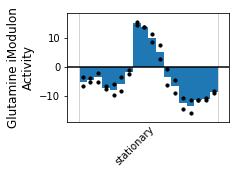

In [41]:
plot_activities(ica_data_1k36_stationary, 'Glutamine')

In [364]:
find_im(ica_data_1k36, 'proA')

No iM found


In [373]:
AA_iMs = [
    'Histidine',
    'Thr/Ser-1',
    'Lrp',
    'Leucine',
    'Arginine',
    'Lysine/T2SS',
    'Tryptophan',
    'Methionine',
    'Glutamine'
]

In [370]:
med_time = ['G_6', 'N_6', 'S_6']

In [374]:
ica_data_1k36_stationary.A.loc[AA_iMs]

p1k_01056  p1k_01057  p1k_01058  p1k_01059  p1k_01060  p1k_01061  \
Histidine     1.219128   1.568535   0.542085   1.240508  -0.885531  -5.326139   
Thr/Ser-1     0.594652   0.776354   0.481925   0.131675   1.392943   0.493861   
Lrp          -0.741952  -1.254966  -5.596758  -5.072694 -10.789830 -11.332835   
Leucine       1.965054   1.105892  -1.420779  -0.116560 -11.259101 -12.043782   
Arginine    -10.538005  -2.724376  -1.439205  -2.925651  -5.357315 -10.456613   
Lysine/T2SS  -0.680214   0.558163   1.200899  -1.483691  -0.733839  -4.801091   
Tryptophan   -3.349717  -1.807705  -0.831748  -0.475573  -7.501365  -6.649813   
Methionine   -3.437886  -1.676573   0.958274   0.718063   1.454369  -0.716214   
Glutamine    -6.622503  -3.622671  -3.939262  -5.039440  -5.098330  -2.034690   

             p1k_01062  p1k_01063  p1k_01064  p1k_01065  ...  p1k_01082  \
Histidine   -10.021700 -10.090852  -6.391416  -8.986665  ...  -9.771163   
Thr/Ser-1     1.526681  -0.652192   0.312711   1.459256  ...   0.517663   
Lrp         -13.929973 -14.161078  -7.860095 -11.543057  ... -13.744635   
Leucine     -12.794857  -8.496499  -3.362099  -8.850416  ... -11.651089   
Arginine    -17.004995 -17.440131 -13.203338 -14.500388  ... -14.160513   
Lysine/T2SS  -5.790772  -6.546506  -4.092511  -5.160707  ...  -6.165741   
Tryptophan   -8.453101  -8.683435  -5.504070  -9.833481  ... -12.241139   
Methionine  -14.629712 -14.812753  -5.876316 -12.742651  ...  -8.744091   
Glutamine    -6.503871  -7.747947  -6.047597  -9.645406  ... -10.604379   

             p1k_01083  p1k_01084  p1k_01085  p1k_01086  p1k_01087  p1k_01088  \
Histidine    -7.934856  -8.189040 -10.176203  -9.746841  -9.406579  -9.464760   
Thr/Ser-1     1.158739   1.638287   0.173939   0.726538   0.478724   0.376275   
Lrp         -12.207911 -12.596182 -14.684680 -14.087376 -13.600780 -12.202170   
Leucine     -13.100414 -13.716608 -12.309751 -12.308189 -13.184623  -8.924160   
Arginine    -14.352853 -15.624760 -15.327759 -16.251410 -15.769551 -16.386254   
Lysine/T2SS  -7.048089  -7.013479  -6.816050  -7.024712  -8.405263  -7.257309   
Tryptophan  -12.945074 -13.707026 -12.979272 -12.942375 -13.148254 -11.725708   
Methionine   -0.099778  -0.123882  -8.227910  -1.596900  -3.116143   2.265623   
Glutamine   -14.496710 -15.839800 -11.249157 -11.278338 -11.274566 -10.869540   

             p1k_01089  p1k_01090  p1k_01091  
Histidine    -9.383501  -7.880835 -10.806261  
Thr/Ser-1     0.587782   2.655084  -1.063714  
Lrp         -14.569375 -12.198159 -19.008744  
Leucine     -13.269760  -3.952401 -11.236386  
Arginine    -17.194990 -17.864420 -18.428097  
Lysine/T2SS  -8.380751  -6.161869  -8.843861  
Tryptophan  -12.067697  -9.440028 -13.043063  
Methionine    0.836660   8.243881   0.462409  
Glutamine   -11.320290  -8.330838  -8.986331  

[9 rows x 36 columns]

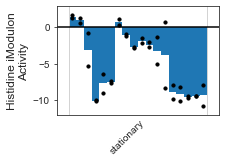

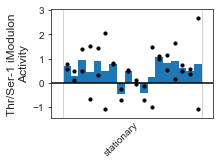

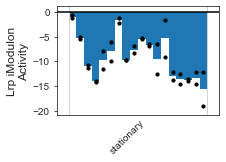

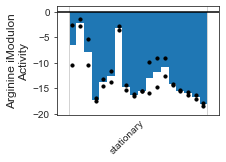

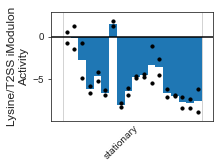

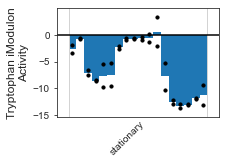

In [368]:
for i in AA_iMs:
    plot_activities(ica_data_1k36_stationary, i)

In [382]:
ica_data_1k36_stationary.A.loc[AA_iMs].to_csv("./AA_ims.csv")

In [37]:
find_im(ica_data_1k36,gene2id('bssR'))

RelB
Fnr-3
Fnr-2


<AxesSubplot:ylabel='b0836 Expression'>

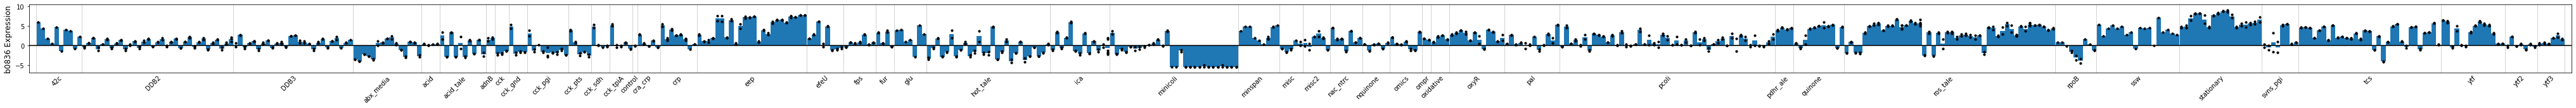

In [36]:
plot_expression(ica_data_1k36,gene2id('bssR'))

In [38]:
compare_expression(ica_data_1k36,gene2id('bssR'))

TypeError: compare_expression() missing 1 required positional argument: 'gene2'

/opt/anaconda3/envs/pymodulon/lib/python3.10/site-packages/pymodulon/plotting.py:836: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  mod_cogs = ica_data.gene_table.loc[component_genes].COG


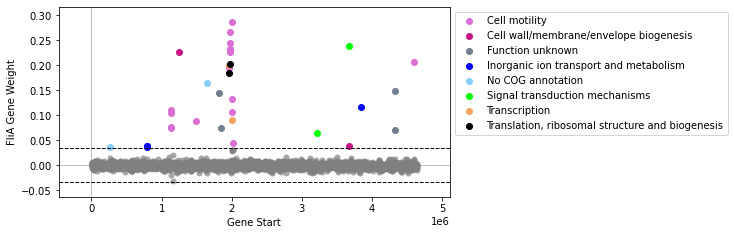

In [27]:
fig = plot_gene_weights(ica_data_1k36,'FliA')
fig.figure.set_size_inches(7,3.5)
fig.figure.savefig("../images/fliA.svg")

In [28]:
ica_data_1k36.view_imodulon("FliA")

gene_weight gene_name        synonyms  \
b0250     0.035636      ykfB            ykfB   
b0763     0.039065      modA            modA   
b0764     0.036971      modB       modB;chlJ   
b0765     0.037505      modC  modC;chlD;narD   
b1070     0.076227      flgN            flgN   
b1071     0.074144      flgM            flgM   
b1082     0.110017      flgK  flgK;flaS;flaW   
b1083     0.103904      flgL  flgL;flaT;flaU   
b1194     0.227128      ycgR            ycgR   
b1421     0.088265       trg             trg   
b1566     0.163554      flxA            flxA   
b1742     0.144251       ves        ves;ydjR   
b1760     0.074724      ynjH            ynjH   
b1881     0.184109      cheZ            cheZ   
b1882     0.199685      cheY            cheY   
b1883     0.193741      cheB            cheB   
b1884     0.203368      cheR       cheR;cheX   
b1885     0.244599       tap             tap   
b1886     0.267375       tar        tar;cheM   
b1887     0.233495      cheW            cheW   
b1888     0.230106      cheA            cheA   
b1889     0.226279      motB            motB   
b1890     0.233447      motA       motA;flaJ   
b1923     0.286025      fliC   fliC;flaF;hag   
b1924     0.132014      fliD  fliD;flaV;flbC   
b1925     0.107157      fliS            fliS   
b1926     0.091060      fliT            fliT   
b1943     0.043266      fliK  fliK;flaE;flaR   
b3072     0.064152       aer    aer;air;yqjJ   
b3524     0.038196      yhjG       yhjG;yhjF   
b3525     0.237948      pdeH       pdeH;yhjH   
b3666     0.115944      uhpT            uhpT   
b4109     0.070217      crfC       crfC;yjdA   
b4110     0.149110      yjcZ            yjcZ   
b4355     0.207363       tsr        tsr;cheD   

                                            gene_product  \
b0250                     CP4-6 prophage%3B protein YkfB   
b0763  molybdate ABC transporter periplasmic binding ...   
b0764         molybdate ABC transporter membrane subunit   
b0765      molybdate ABC transporter ATP binding subunit   
b1070                flagellar biosynthesis protein FlgN   
b1071             anti-sigma factor for FliA (sigma(28))   
b1082         flagellar hook-filament junction protein 1   
b1083         flagellar hook-filament junction protein 2   
b1194                       flagellar brake protein YcgR   
b1421            methyl-accepting chemotaxis protein Trg   
b1566                       Qin prophage%3B protein FlxA   
b1742                            HutD family protein Ves   
b1760             DUF1496 domain-containing protein YnjH   
b1881                            chemotaxis protein CheZ   
b1882                            chemotaxis protein CheY   
b1883  protein-glutamate methylesterase/protein gluta...   
b1884               chemotaxis protein methyltransferase   
b1885            methyl-accepting chemotaxis protein Tap   
b1886            methyl-accepting chemotaxis protein Tar   
b1887                            chemotaxis protein CheW   
b1888                            chemotaxis protein CheA   
b1889                                 motility protein B   
b1890                                 motility protein A   
b1923              flagellar filament structural protein   
b1924                 flagellar filament capping protein   
b1925                flagellar biosynthesis protein FliS   
b1926                flagellar biosynthesis protein FliT   
b1943              flagellar hook-length control protein   
b3072          aerotaxis sensor receptor%2C flavoprotein   
b3524                           AsmA family protein YhjG   
b3525                    c-di-GMP phosphodiesterase PdeH   
b3666            hexose-6-phosphate:phosphate antiporter   
b4109  clamp-binding sister replication fork colocali...   
b4110                       uncharacterized protein YjcZ   
b4355            methyl-accepting chemotaxis protein Tsr   

                                                   COG  \
b0250                                No COG annotation   
b